<a href="https://colab.research.google.com/github/suafle/Clase2/blob/master/upper_fractions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import time
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files
from scipy import stats
from scipy.interpolate import interpn
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from astropy.coordinates import SkyCoord
from astropy.table import Table
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import rc
from astropy import units as u
from astropy.io import fits
from sklearn import svm

In [0]:
def linea(x,n):
  return (20/3.)*x + n

def linea_m(x,m,n):
  y = m*x + n
  return y

def inv_linea(m,y,n):
  return (y-n)/m

def rombo(m,y1,y2,n1,n2):
  x1 = inv_linea(m,y1,n1)
  x2 = inv_linea(m,y1,n2)
  x3 = inv_linea(m,y2,n2)
  x4 = inv_linea(m,y2,n1)
  x5 = x1
  return [x1,x2,x3,x4,x5],[y1,y1,y2,y2,y1]

def rombod(y1,y2,x1,x4,dx): #y1 top line (smallest), y2 bottom line (largest), x1 upper-left corner, x4 bottom-left corner
  m = (y1-y2)/(x1-x4)
  n1 = y1 - m*x1
  n2 = y2 - m*(x1 + dx)
  x2 = (y1 - n2)/m
  x3 = (y2 - n2)/m
  return [x1,x2,x3,x4,x1],[y1,y1,y2,y2,y1]

def romboe(X,m,n,dx): #y1 top line (smallest), y2 bottom line (largest), x1 upper-left corner, x4 bottom-left corner
  x1 = X[0]
  x4 = X[1]
  y1 = m*x1 + n
  y2 = m+x4 + n
  x2 = x1 + dx 
  x3 = x4 + dx
  return [x1,x2,x3,x4,x1],[y1,y1,y2,y2,y1]

In [0]:
#GAIA passbands
gaia_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/GAIADR2/GaiaDR2_RevisedPassbands.dat'
gaia = np.loadtxt(gaia_data)
gaia = np.where(gaia==99.99,0,gaia)
gaia_w = gaia[:,0]*10 #Angstrom
gaia_g = gaia[:,1]
gaia_bp = gaia[:,3]
gaia_rp = gaia[:,5]

def inter_g(wavelength): 
  f = interp1d(gaia_w,gaia_g)
  return f(wavelength)
  
def inter_gbp(wavelength): 
  f = interp1d(gaia_w,gaia_bp)
  return f(wavelength)
  
def inter_grp(wavelength): 
  f = interp1d(gaia_w,gaia_rp)
  return f(wavelength)

#WISE passbands
wise1_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W1.txt'
wise2_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W2.txt'
wise3_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W3.txt'
wise4_data = 'https://raw.githubusercontent.com/suafle/useful_data/master/Passbands/WISE/RSR-W4.txt'

w1 = np.loadtxt(wise1_data)
w2 = np.loadtxt(wise2_data)
w3 = np.loadtxt(wise3_data)
w4 = np.loadtxt(wise4_data)

w1ww = w1[:,0]*1e4
w1r = w1[:,1]

w2ww = w2[:,0]*1e4
w2r = w2[:,1]

w3ww = w3[:,0]*1e4
w3r = w3[:,1]

w4ww = w4[:,0]*1e4
w4r = w4[:,1]

#wavelength must be between 25300 and 65000 A (W1)
#wavelength must be between 25300 and 80000 A (W1)
#wavelength must be between 25300 and 285000 A (W1)
#wavelength must be between 25300 and 285000 A (W1)


def inter_w1(wavelength): 
  f = interp1d(w1ww,w1r)
  return f(wavelength)
  
def inter_w2(wavelength): 
  f = interp1d(w2ww,w2r)
  return f(wavelength)

def inter_w3(wavelength): 
  f = interp1d(w3ww,w3r)
  return f(wavelength)

def inter_w4(wavelength): 
  f = interp1d(w4ww,w4r)
  return f(wavelength)


# T = 25 K

def BB_25_G(Lbol):
  x = np.log10(Lbol)
  g = -8.099458601996567e-11*x**4 + -1.3179948872740398e-08*x**3 + -4.306957502208598e-06*x**2 + -0.0019339763107174446*x + 2.7492729577328494
  return 10**g

def BB_25_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -1.3941407555334165e-07*x**4 + -6.914247253606078e-06*x**3 + -0.0002901192082677239*x**2 + -0.015872686943729748*x + 1.8350877154044967
  return 10**w3 - 50

def BB_25_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -2.4576609447861997e-07*x**4 + -1.0901888669851771e-05*x**3 + -0.0003947170220650011*x**2 + -0.01851317494659888*x + 1.7682676728438411
  return 10**w4 - 50

def BB_25_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.2096725977360303e-08*x**4 + -1.0036767760778252e-06*x**3 + -7.93312030342903e-05*x**2 + -0.00830084159668832*x + 2.116603417382132
  return 10**w2 - 50

def BB_25_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -7.642772021608343e-09*x**4 + -7.019942800148635e-07*x**3 + -6.245007714752754e-05*x**2 + -0.00736493093595547*x + 2.1685564167239257
  return 10**w1 - 50


# T = 30 K

def BB_30_G(Lbol):
  x = np.log10(Lbol)
  g = -1.2657224420109674e-10*x**4 + -2.261393194579711e-08*x**3 + -6.223679830663643e-06*x**2 + -0.0023248814636050294*x + 2.6693233255865367
  return 10**g

def BB_30_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -1.6706912409390038e-07*x**4 + -7.992990812347647e-06*x**3 + -0.0003199643339901093*x**2 + -0.016668877726591296*x + 1.813834520549138
  return 10**w3 - 50

def BB_30_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -3.071359960450833e-07*x**4 + -1.3051633938019438e-05*x**3 + -0.0004459258545040455*x**2 + -0.019676892350131252*x + 1.741798044247667
  return 10**w4 - 50

def BB_30_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.7725720565517864e-08*x**4 + -1.3528811145638191e-06*x**3 + -9.68941560658089e-05*x**2 + -0.00917374267637691*x + 2.07317955581914
  return 10**w2 - 50

def BB_30_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -1.1671707653939987e-08*x**4 + -9.760686191724443e-07*x**3 + -7.786349015829211e-05*x**2 + -0.008223699486642911*x + 2.1206582693263356
  return 10**w1 - 50


# T = 35 K

def BB_35_G(Lbol):
  x = np.log10(Lbol)
  g = -1.7950307259649541e-10*x**4 + -3.563995468794839e-08*x**3 + -8.49830807615839e-06*x**2 + -0.0027168221218270847*x + 2.601663042109779
  return 10**g

def BB_35_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -1.9309249805661915e-07*x**4 + -8.978121235569958e-06*x**3 + -0.0003461174023717185*x**2 + -0.017336495190998277*x + 1.7967821282840466
  return 10**w3 - 50

def BB_35_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -3.6165917737161633e-07*x**4 + -1.4897651871417116e-05*x**3 + -0.00048781422976271226*x**2 + -0.020579819105776734*x + 1.7223182946108169
  return 10**w4 - 50

def BB_35_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -2.38015031543656e-08*x**4 + -1.704457467257239e-06*x**3 + -0.00011312287520674432*x**2 + -0.00991221340719585*x + 2.0395560754688584
  return 10**w2 - 50

def BB_35_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -1.623019781397611e-08*x**4 + -1.2626902141362377e-06*x**3 + -9.251666133365199e-05*x**2 + -0.008964133384790752*x + 2.0832176486078553
  return 10**w1 - 50


# T = 40 K

def BB_40_G(Lbol):
  x = np.log10(Lbol)
  g = -2.7841559640632525e-10*x**4 + -5.32103878135262e-08*x**3 + -1.1133622530397849e-05*x**2 + -0.0031097098736585864*x + 2.5430044367142304
  return 10**g

def BB_40_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -2.205746196019544e-07*x**4 + -9.992303489747471e-06*x**3 + -0.00037210804895255984*x**2 + -0.01797537555849798*x + 1.7810681458487925
  return 10**w3 - 50

def BB_40_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -4.0929884857928943e-07*x**4 + -1.647069265411194e-05*x**3 + -0.0005222418093255769*x**2 + -0.021293201499670105*x + 1.7075234988748649
  return 10**w4 - 50

def BB_40_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.0089502985251506e-08*x**4 + -2.0491831254062708e-06*x**3 + -0.00012799992671475716*x**2 + -0.010543820315775611*x + 2.0127293517306657
  return 10**w2 - 50

def BB_40_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.113563925033447e-08*x**4 + -1.552812653414661e-06*x**3 + -0.0001062718087762639*x**2 + -0.009607391118316471*x + 2.0531209808421527
  return 10**w1 - 50



# T = 45 K

def BB_45_G(Lbol):
  x = np.log10(Lbol)
  g = -4.3029711513323576e-10*x**4 + -7.594409253172202e-08*x**3 + -1.4131451241526415e-05*x**2 + -0.0035034687782860728*x + 2.4912260961774257
  return 10**g

def BB_45_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -2.4919040141508325e-07*x**4 + -1.102419102125077e-05*x**3 + -0.00039771079203488837*x**2 + -0.018583218435633164*x + 1.7666279801541702
  return 10**w3 - 50

def BB_45_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -4.5053804132894477e-07*x**4 + -1.7806729241322752e-05*x**3 + -0.0005506851196988828*x**2 + -0.021864979860233672*x + 1.6960193690994794
  return 10**w4 - 50

def BB_45_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.6438028340341935e-08*x**4 + -2.3825884749557824e-06*x**3 + -0.00014162905725411876*x**2 + -0.011090909095772506*x + 1.9907608366189897
  return 10**w2 - 50

def BB_45_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.6240582871317593e-08*x**4 + -1.8401424015473541e-06*x**3 + -0.00011908574597640973*x**2 + -0.01017008079770195*x + 2.0284025596765956
  return 10**w1 - 50


  

# T = 50 K

def BB_50_G(Lbol):
  x = np.log10(Lbol)
  g = -6.467312007535776e-10*x**4 + -1.0450351944176388e-07*x**3 + -1.7493574109489342e-05*x**2 + -0.0038980321032496385*x + 2.4448789718010695
  return 10**g

def BB_50_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -2.771457716317666e-07*x**4 + -1.2011773394934934e-05*x**3 + -0.00042151582284816305*x**2 + -0.019131027189689582*x + 1.7540133470933106
  return 10**w3 - 50

def BB_50_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -4.860541270412358e-07*x**4 + -1.8940428923690245e-05*x**3 + -0.0005743044648025163*x**2 + -0.02232862440331759*x + 1.6869099110336774
  return 10**w4 - 50

def BB_50_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.289731533128489e-08*x**4 + -2.7098702353846917e-06*x**3 + -0.00015441549897251788*x**2 + -0.011580684599116438*x + 1.9719943911960276
  return 10**w2 - 50

def BB_50_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.142568690194107e-08*x**4 + -2.1204155356188776e-06*x**3 + -0.00013096861171815294*x**2 + -0.010665377991477674*x + 2.0077512287525683
  return 10**w1 - 50



# T = 55 K

def BB_55_G(Lbol):
  x = np.log10(Lbol)
  g = -9.423107984110914e-10*x**4 + -1.3957026025791784e-07*x**3 + -2.1221616671246323e-05*x**2 + -0.0042933403323147795*x + 2.4029290996004664
  return 10**g

def BB_55_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -3.034122580406219e-07*x**4 + -1.2923532811484148e-05*x**3 + -0.00044295254846377866*x**2 + -0.019611216732075543*x + 1.7432496525020849
  return 10**w3 - 50

def BB_55_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.165540285170844e-07*x**4 + -1.990270502138538e-05*x**3 + -0.0005940109824204975*x**2 + -0.022708193887103024*x + 1.6795922274318549
  return 10**w4 - 50

def BB_55_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.9999086961042554e-08*x**4 + -3.058591187528416e-06*x**3 + -0.0001675003665409591*x**2 + -0.012061308456181473*x + 1.9543349080352816
  return 10**w2 - 50

def BB_55_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.659972154899312e-08*x**4 + -2.3908833296396893e-06*x**3 + -0.00014195959900689754*x**2 + -0.011103841771014242*x + 1.9902547331331841
  return 10**w1 - 50




# T = 60 K

def BB_60_G(Lbol):
  x = np.log10(Lbol)
  g = -1.3292934701169907e-09*x**4 + -1.8178950232010575e-07*x**3 + -2.5316973497622273e-05*x**2 + -0.00468934017058692*x + 2.3646127178397287
  return 10**g

def BB_60_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -3.276479002597365e-07*x**4 + -1.3752413192774598e-05*x**3 + -0.00046203266973385656*x**2 + -0.020028913469224082*x + 1.7340991569887156
  return 10**w3 - 50

def BB_60_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.427101865443934e-07*x**4 + -2.0720225048431498e-05*x**3 + -0.0006105227794539079*x**2 + -0.023021394514777253*x + 1.6736457143328025
  return 10**w4 - 50

def BB_60_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -5.837117722127564e-08*x**4 + -3.4572705242131573e-06*x**3 + -0.00018188141354499572*x**2 + -0.0125683458149478*x + 1.9364520421723839
  return 10**w2 - 50

def BB_60_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.1698716909139584e-08*x**4 + -2.649926035204664e-06*x**3 + -0.00015211271296800273*x**2 + -0.01149401970980617*x + 1.9752565680952796
  return 10**w1 - 50



# T = 65 K

def BB_65_G(Lbol):
  x = np.log10(Lbol)
  g = -1.8235326465082868e-09*x**4 + -2.3183393991362128e-07*x**3 + -2.9780970127430313e-05*x**2 + -0.00508598346354774*x + 2.3293495630109287
  return 10**g

def BB_65_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -3.4982430813542585e-07*x**4 + -1.4501378993522379e-05*x**3 + -0.0004789657148683299*x**2 + -0.0203924240202692*x + 1.7262898468533079
  return 10**w3 - 50

def BB_65_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.651280889418739e-07*x**4 + -2.1415555491801396e-05*x**3 + -0.0006244088569035536*x**2 + -0.02328151591512938*x + 1.6687682448532875
  return 10**w4 - 50

def BB_65_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -6.778275914478877e-08*x**4 + -3.892252174378825e-06*x**3 + -0.00019697366181448348*x**2 + -0.013079322636810433*x + 1.9191458446944776
  return 10**w2 - 50

def BB_65_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.6674687623854095e-08*x**4 + -2.8966830337003217e-06*x**3 + -0.00016148888694872003*x**2 + -0.011842923162279608*x + 1.9622700900112537
  return 10**w1 - 50



# T = 70 K

def BB_70_G(Lbol):
  x = np.log10(Lbol)
  g = -2.443215158397026e-09*x**4 + -2.903885206510153e-07*x**3 + -3.461483640717238e-05*x**2 + -0.0054832265277647155*x + 2.296688380699421
  return 10**g

def BB_70_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -3.700348560266808e-07*x**4 + -1.517670613482368e-05*x**3 + -0.0004940011743298591*x**2 + -0.02070983670741659*x + 1.7195839850614125
  return 10**w3 - 50

def BB_70_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.843351967917824e-07*x**4 + -2.2007586737038012e-05*x**3 + -0.000636122872952944*x**2 + -0.023498701779269947*x + 1.6647374779431388
  return 10**w4 - 50

def BB_70_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -7.774894196268578e-08*x**4 + -4.340194098741557e-06*x**3 + -0.0002119573672947566*x**2 + -0.01356758630719847*x + 1.903229492485397
  return 10**w2 - 50

def BB_70_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -5.150019832278192e-08*x**4 + -3.130988610494078e-06*x**3 + -0.00017015489572870833*x**2 + -0.012156492784115113*x + 1.950921184835609
  return 10**w1 - 50



# T = 75 K

def BB_75_G(Lbol):
  x = np.log10(Lbol)
  g = -3.2058960961239337e-09*x**4 + -3.581214598762935e-07*x**3 + -3.981966501277245e-05*x**2 + -0.005881029671277779*x + 2.2662712757637817
  return 10**g

def BB_75_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -3.884208438549723e-07*x**4 + -1.578547377814366e-05*x**3 + -0.000507376915214544*x**2 + -0.02098816568395046*x + 1.7137879574058612
  return 10**w3 - 50

def BB_75_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.007882689702413e-07*x**4 + -2.2512110888710273e-05*x**3 + -0.0006460290535740739*x**2 + -0.023680808484409965*x + 1.6613864041230302
  return 10**w4 - 50

def BB_75_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -8.799670994141029e-08*x**4 + -4.7892460984979105e-06*x**3 + -0.00022648576460630588*x**2 + -0.014024775563127619*x + 1.8888371780582485
  return 10**w2 - 50

def BB_75_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -5.6168912793384405e-08*x**4 + -3.3535465798290337e-06*x**3 + -0.00017819383544082366*x**2 + -0.012440302998155812*x + 1.9408989866411384
  return 10**w1 - 50



# T = 80 K

def BB_80_G(Lbol):
  x = np.log10(Lbol)
  g = -4.131318216249364e-09*x**4 + -4.357121729175029e-07*x**3 + -4.539647826765492e-05*x**2 + -0.006279356677540297*x + 2.237809588321772
  return 10**g

def BB_80_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -4.0513639558545555e-07*x**4 + -1.6334584050873375e-05*x**3 + -0.0005193047496285474*x**2 + -0.021233280057156283*x + 1.7087469722452122
  return 10**w3 - 50

def BB_80_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.148771787446687e-07*x**4 + -2.2942292293648796e-05*x**3 + -0.0006544217672392987*x**2 + -0.0238339999800678*x + 1.6585873491385816
  return 10**w4 - 50

def BB_80_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -9.837780734960971e-08*x**4 + -5.2340238782328415e-06*x**3 + -0.0002404509003944947*x**2 + -0.014450599805410844*x + 1.875848249975727
  return 10**w2 - 50

def BB_80_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -6.071678260499403e-08*x**4 + -3.566893492706022e-06*x**3 + -0.00018574002414980755*x**2 + -0.012700944228850822*x + 1.9318943878148032
  return 10**w1 - 50



# T = 85 K

def BB_85_G(Lbol):
  x = np.log10(Lbol)
  g = -5.241869943805703e-09*x**4 + -5.238565290298836e-07*x**3 + -5.134625331285134e-05*x**2 + -0.006678174424220618*x + 2.2110670937968293
  return 10**g

def BB_85_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -4.2033450599229443e-07*x**4 + -1.683042250844613e-05*x**3 + -0.000529968592442975*x**2 + -0.02145004113632712*x + 1.7043374014063999
  return 10**w3 - 50

def BB_85_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.269354949056087e-07*x**4 + -2.33091406834574e-05*x**3 + -0.0006615405971942191*x**2 + -0.0239631683034717*x + 1.6562412040021999
  return 10**w4 - 50

def BB_85_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.0880282338828152e-07*x**4 + -5.671717889580611e-06*x**3 + -0.0002538266869454132*x**2 + -0.014846995264318439*x + 1.8640965824948412
  return 10**w2 - 50

def BB_85_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -6.527312141406608e-08*x**4 + -3.77748665279637e-06*x**3 + -0.0001930469945310138*x**2 + -0.012948320116941517*x + 1.9235174209216386
  return 10**w1 - 50



# T = 90 K

def BB_90_G(Lbol):
  x = np.log10(Lbol)
  g = -6.556403091096958e-09*x**4 + -6.232040033929561e-07*x**3 + -5.7669798409972386e-05*x**2 + -0.007077452704356857*x + 2.1858480103194107
  return 10**g

def BB_90_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -4.341598450906335e-07*x**4 + -1.7278748762655586e-05*x**3 + -0.0005395266105410198*x**2 + -0.021642473319663742*x + 1.7004599764179242
  return 10**w3 - 50

def BB_90_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.372439836305381e-07*x**4 + -2.3621838794970496e-05*x**3 + -0.0006675817066112528*x**2 + -0.024072236446916685*x + 1.6542699917538544
  return 10**w4 - 50

def BB_90_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.1920560711537721e-07*x**4 + -6.1005864223763035e-06*x**3 + -0.00026661585806664567*x**2 + -0.015216341375251508*x + 1.853425934730066
  return 10**w2 - 50

def BB_90_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -7.009374094159108e-08*x**4 + -3.997182769025781e-06*x**3 + -0.00020053113962477325*x**2 + -0.013196884195979667*x + 1.915259920603394
  return 10**w1 - 50




# T = 95 K

def BB_95_G(Lbol):
  x = np.log10(Lbol)
  g = -8.100497697748058e-09*x**4 + -7.344615678096652e-07*x**3 + -6.436797613845765e-05*x**2 + -0.007477163706953928*x + 2.1619882521946185
  return 10**g

def BB_95_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -4.467428142006765e-07*x**4 + -1.7684662728886687e-05*x**3 + -0.0005481143773064845*x**2 + -0.02181391934722562*x + 1.697034380344513
  return 10**w3 - 50

def BB_95_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.460459420247196e-07*x**4 + -2.38881384575025e-05*x**3 + -0.0006727068691295125*x**2 + -0.024164379672137797*x + 1.6526116263636053
  return 10**w4 - 50

def BB_95_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.2953503808339318e-07*x**4 + -6.51947042123691e-06*x**3 + -0.0002788327075683616*x**2 + -0.015560964355328505*x + 1.8437006866196102
  return 10**w2 - 50

def BB_95_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -7.54714381412359e-08*x**4 + -4.238833309406597e-06*x**3 + -0.00020861190845004597*x**2 + -0.013460106713951635*x + 1.9066833559567926
  return 10**w1 - 50


# T = 100
# x = np.log10(luminosity)
# g = np.log10(G)
# g = np.log10(G)
# g(x) = -8.66498571e-07*x**3 + -7.14467998e-05*x**2 + -7.87725331e-03*x + -1.00240305e-08*x**4 + 2.13934893e+00

# w3 = np.log10(W3+50)
# w3(x) = -1.89341831e-05*x**3 + -5.55241091e-04*x**2 + -2.19647781e-02*x + -7.28619280e-07*x**4 + 1.69399505e+00

# w4 = np.log10(W4+50)
# w4(x) = -1.11447856e-05*x**3 + -3.90867574e-04*x**2 + -1.84275660e-02*x + -3.58795811e-07*x**4 + 1.77025512e+00

def BB_100_G(Lbol):
  x = np.log10(Lbol)
  g = -9.895422582263497e-09*x**4 + -8.582824702971096e-07*x**3 + -7.144148401041269e-05*x**2 + -0.007877282046516451*x + 2.139348927843833
  return 10**g

def BB_100_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -4.5820455973309133e-07*x**4 + -1.8052701783010206e-05*x**3 + -0.0005558482265349644*x**2 + -0.02196716926676166*x + 1.6939950945650848
  return 10**w3 - 50

def BB_100_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.535431897707118e-07*x**4 + -2.411451280494682e-05*x**3 + -0.0006770500977813015*x**2 + -0.024242190034236905*x + 1.6512161458336736
  return 10**w4 - 50

def BB_100_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.3974966545186152e-07*x**4 + -6.927574677269176e-06*x**3 + -0.0002904966918236082*x**2 + -0.01588300702027654*x + 1.8348054715788404
  return 10**w2 - 50

def BB_100_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -8.150705276103485e-08*x**4 + -4.506131820845083e-06*x**3 + -0.00021737988799797303*x**2 + -0.013740007041810689*x + 1.897745501748766
  return 10**w1 - 50


# T = 125 K

def BB_125_G(Lbol):
  x = np.log10(Lbol)
  g = -2.3538711390316717e-08*x**4 + -1.6896407028762894e-06*x**3 + -0.00011246223018234378*x**2 + -0.009883228675660695*x + 2.0408278480614865
  return 10**g

def BB_125_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.021483397546376e-07*x**4 + -1.944945380392972e-05*x**3 + -0.0005847664230908524*x**2 + -0.022530932494268126*x + 1.682994265752685
  return 10**w3 - 50

def BB_125_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.767831499601722e-07*x**4 + -2.4813457466314773e-05*x**3 + -0.0006903816740125691*x**2 + -0.024479477713651034*x + 1.6469880797390546
  return 10**w4 - 50

def BB_125_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -1.8818845097467389e-07*x**4 + -8.794426958667744e-06*x**3 + -0.00034131240864723625*x**2 + -0.017215780971632497*x + 1.7998162223559322
  return 10**w2 - 50

def BB_125_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -1.1615584083998153e-07*x**4 + -5.975615143443327e-06*x**3 + -0.0002629196369858556*x**2 + -0.015110524607250283*x + 1.856456334766309
  return 10**w1 - 50


# T = 150 K

def BB_150_G(Lbol):
  x = np.log10(Lbol)
  g = -4.7475678593747594e-08*x**4 + -2.9359013785238143e-06*x**3 + -0.00016295483015046303*x**2 + -0.011896547945822315*x + 1.9603081221065763
  return 10**g

def BB_150_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.303806472151613e-07*x**4 + -2.0335706847719873e-05*x**3 + -0.0006027819462899076*x**2 + -0.022875099800947474*x + 1.676413156001487
  return 10**w3 - 50

def BB_150_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.85293717988866e-07*x**4 + -2.5068422984753524e-05*x**3 + -0.0006952162591004292*x**2 + -0.024564959671297258*x + 1.6454749886797186
  return 10**w4 - 50

def BB_150_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -2.310605735664588e-07*x**4 + -1.0373093533295935e-05*x**3 + -0.0003816489014057044*x**2 + -0.01820426545542658*x + 1.7755739831749224
  return 10**w2 - 50

def BB_150_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -1.5084132010551467e-07*x**4 + -7.364423474993914e-06*x**3 + -0.0003027420786208611*x**2 + -0.01621421133622954*x + 1.8258434596772204
  return 10**w1 - 50


# T = 175 K

def BB_175_G(Lbol):
  x = np.log10(Lbol)
  g = -8.546839938953734e-08*x**4 + -4.6794559293876035e-06*x**3 + -0.00022297575686206324*x**2 + -0.013915698077287696*x + 1.892227851232719
  return 10**g

def BB_175_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.487430094117558e-07*x**4 + -2.090781818376548e-05*x**3 + -0.0006142830906541482*x**2 + -0.023092125129004156*x + 1.6723140204595062
  return 10**w3 - 50

def BB_175_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.861424346753677e-07*x**4 + -2.509380243281478e-05*x**3 + -0.0006956965180048593*x**2 + -0.024573434639501696*x + 1.6453252629193476
  return 10**w4 - 50

def BB_175_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -2.680488126924358e-07*x**4 + -1.1692458423559146e-05*x**3 + -0.0004138886923477617*x**2 + -0.01895723667933817*x + 1.7579757178416993
  return 10**w2 - 50

def BB_175_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -1.83098101715272e-07*x**4 + -8.602837256870879e-06*x**3 + -0.000336267046838319*x**2 + -0.01708810899839934*x + 1.8030484467465762
  return 10**w1 - 50


# T = 200 K

def BB_200_G(Lbol):
  x = np.log10(Lbol)
  g = -1.4160386512016043e-07*x**4 + -7.001034164505938e-06*x**3 + -0.00029257259961895866*x**2 + -0.015939639665331573*x + 1.8332598820585555
  return 10**g

def BB_200_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.606738705864558e-07*x**4 + -2.1277800849910818e-05*x**3 + -0.0006216691939915441*x**2 + -0.02323042703647427*x + 1.6697218782331218
  return 10**w3 - 50

def BB_200_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.829017687277456e-07*x**4 + -2.4996807487363452e-05*x**3 + -0.0006938597511588049*x**2 + -0.02454100477883805*x + 1.6458984743741003
  return 10**w4 - 50

def BB_200_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -2.9957554308416354e-07*x**4 + -1.2791253856316026e-05*x**3 + -0.00043987258470697897*x**2 + -0.019542951983649075*x + 1.7447636536153428
  return 10**w2 - 50

def BB_200_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.1236678472384317e-07*x**4 + -9.69195537377279e-06*x**3 + -0.00036450164301263634*x**2 + -0.01779078045401125*x + 1.7855503163682975
  return 10**w1 - 50


# T = 225 K

def BB_225_G(Lbol):
  x = np.log10(Lbol)
  g = -2.2022658184125607e-07*x**4 + -9.97962015109232e-06*x**3 + -0.0003717884068679022*x**2 + -0.017967656828829552*x + 1.7812546407005545
  return 10**g

def BB_225_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.682755855377002e-07*x**4 + -2.151280625022362e-05*x**3 + -0.0006263398856718645*x**2 + -0.023317458399974348*x + 1.668098592012242
  return 10**w3 - 50

def BB_225_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.77472644210295e-07*x**4 + -2.4834133159894406e-05*x**3 + -0.0006907742789588717*x**2 + -0.024486430643051938*x + 1.6468648103729162
  return 10**w4 - 50

def BB_225_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.2629842192907555e-07*x**4 + -1.3706539267858184e-05*x**3 + -0.0004609861489363379*x**2 + -0.020006229610262282*x + 1.7345911670628167
  return 10**w2 - 50

def BB_225_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.385804356469913e-07*x**4 + -1.0644229962944842e-05*x**3 + -0.00038837500047274337*x**2 + -0.018363909884873613*x + 1.7717827238631134
  return 10**w1 - 50


# T = 250 K

def BB_250_G(Lbol):
  x = np.log10(Lbol)
  g = -3.25882630131481e-07*x**4 + -1.3692413769221062e-05*x**3 + -0.0004606638300648791*x**2 + -0.01999923836034118*x + 1.7347429192292128
  return 10**g

def BB_250_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.728812452851973e-07*x**4 + -2.1654932592292836e-05*x**3 + -0.0006291570098317214*x**2 + -0.023369794005868836*x + 1.6671253612545072
  return 10**w3 - 50

def BB_250_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.709041926234073e-07*x**4 + -2.4637032822353218e-05*x**3 + -0.0006870275595776429*x**2 + -0.024419996097632048*x + 1.6480440731138506
  return 10**w4 - 50

def BB_250_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.489009266867345e-07*x**4 + -1.4470379280932535e-05*x**3 + -0.00047827049770437927*x**2 + -0.02037762775994718*x + 1.7266049857081691
  return 10**w2 - 50

def BB_250_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.618854213240652e-07*x**4 + -1.1475019718878417e-05*x**3 + -0.00040865755830354666*x**2 + -0.018837112027879993*x + 1.7607358291714743
  return 10**w1 - 50


# T = 275 K

def BB_275_G(Lbol):
  x = np.log10(Lbol)
  g = -4.632668960721811e-07*x**4 + -1.82147442273286e-05*x**3 + -0.0005592377883255414*x**2 + -0.02203399803945493*x + 1.692676373350082
  return 10**g

def BB_275_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.753697466190109e-07*x**4 + -2.1731661617611953e-05*x**3 + -0.0006306756510908991*x**2 + -0.023397958372774086*x + 1.6666025213420237
  return 10**w3 - 50

def BB_275_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.637931141576241e-07*x**4 + -2.4423288729000645e-05*x**3 + -0.0006829540913168872*x**2 + -0.024347561358991802*x + 1.6493335120925636
  return 10**w4 - 50

def BB_275_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.6801269229423907e-07*x**4 + -1.5109442601913e-05*x**3 + -0.0004925131971939314*x**2 + -0.020678642115461693*x + 1.7202384469687968
  return 10**w2 - 50

def BB_275_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.8252342675841425e-07*x**4 + -1.219965859553742e-05*x**3 + -0.00042597392947650657*x**2 + -0.01923188014208528*x + 1.7517304159685658
  return 10**w1 - 50




# T = 300
# x = np.log10(luminosity)
# g = np.log10(G)
# g = np.log10(G)
# g(x) = -2.49649566e-05*x**3 + -6.66586021e-04*x**2 + -2.40679889e-02*x + -1.05452859e-06*x**4 + 1.65428099e+00

# w3 = np.log10(W3+50)
# w3(x) = -2.29440595e-05*x**3 + -6.30431088e-04*x**2 + -2.34057136e-02*x + -9.41970700e-07*x**4 + 1.66639928e+00

# w4 = np.log10(W4+50)
# w4(x) = -2.22563577e-05*x**3 + -6.17879406e-04*x**2 + -2.31713853e-02*x + -9.04408975e-07*x**4 + 1.67076929e+0

def BB_300_G(Lbol):
  x = np.log10(Lbol)
  g = -6.371855575796432e-07*x**4 + -2.3620067696778187e-05*x**3 + -0.0006675475604489429*x**2 + -0.024071621404505205*x + 1.6542810824136107
  return 10**g

def BB_300_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.763404766524099e-07*x**4 + -2.1761558589953176e-05*x**3 + -0.0006312667803485798*x**2 + -0.023408911815357182*x + 1.6663993527850458
  return 10**w3 - 50

def BB_300_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.564858020142553e-07*x**4 + -2.4203239129346348e-05*x**3 + -0.0006787489536200213*x**2 + -0.024272557378372184*x + 1.6506727432338626
  return 10**w4 - 50

def BB_300_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.8417943018806497e-07*x**4 + -1.5645491884793984e-05*x**3 + -0.0005043156782828504*x**2 + -0.020924793583428223*x + 1.7151008478677998
  return 10**w2 - 50

def BB_300_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.0076203139571866e-07*x**4 + -1.2832212120222642e-05*x**3 + -0.0004408274864576676*x**2 + -0.019564142501271798*x + 1.7442931169999947 
  return 10**w1 - 50


# T = 325 K

def BB_325_G(Lbol):
  x = np.log10(Lbol)
  g = -4.632668960721811e-07*x**4 + -1.82147442273286e-05*x**3 + -0.0005592377883255414*x**2 + -0.02203399803945493*x + 1.692676373350082
  return 10**g

def BB_325_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.753697466190109e-07*x**4 + -2.1731661617611953e-05*x**3 + -0.0006306756510908991*x**2 + -0.023397958372774086*x + 1.6666025213420237
  return 10**w3 - 50

def BB_325_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.637931141576241e-07*x**4 + -2.4423288729000645e-05*x**3 + -0.0006829540913168872*x**2 + -0.024347561358991802*x + 1.6493335120925636
  return 10**w4 - 50

def BB_325_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -3.6801269229423907e-07*x**4 + -1.5109442601913e-05*x**3 + -0.0004925131971939314*x**2 + -0.020678642115461693*x + 1.7202384469687968
  return 10**w2 - 50

def BB_325_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -2.8252342675841425e-07*x**4 + -1.219965859553742e-05*x**3 + -0.00042597392947650657*x**2 + -0.01923188014208528*x + 1.7517304159685658
  return 10**w1 - 50



# T = 350 K

def BB_350_G(Lbol):
  x = np.log10(Lbol)
  g = -1.114206621207932e-06*x**4 + -3.736394115620762e-05*x**3 + -0.0009135130677374497*x**2 + -0.028154365138248802*x + 1.5862862292346984
  return 10**g

def BB_350_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.752676166461678e-07*x**4 + -2.172850319068429e-05*x**3 + -0.0006306130813544652*x**2 + -0.0233967984392937*x + 1.6666240415488547
  return 10**w3 - 50

def BB_350_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.420044025210513e-07*x**4 + -2.37659553770371e-05*x**3 + -0.0006703576830138269*x**2 + -0.02412218882984153*x + 1.6533701767981028
  return 10**w4 - 50

def BB_350_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.094591198833226e-07*x**4 + -1.647593267681269e-05*x**3 + -0.0005223547852254275*x**2 + -0.02129550322417548*x + 1.70747657127305
  return 10**w2 - 50

def BB_350_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.310907576672247e-07*x**4 + -1.3869264513894728e-05*x**3 + -0.0004646931552434685*x**2 + -0.020086464318124234*x + 1.732853384045418
  return 10**w1 - 50



# T = 375 K

def BB_375_G(Lbol):
  x = np.log10(Lbol)
  g = -1.4271928465610888e-06*x**4 + -4.5839719595758116e-05*x**3 + -0.0010512312450333219*x**2 + -0.03019896394940391*x + 1.5558695709126442
  return 10**g

def BB_375_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.737347760254069e-07*x**4 + -2.1681264576669704e-05*x**3 + -0.0006296784376437634*x**2 + -0.02337946828154836*x + 1.6669456982345738
  return 10**w3 - 50

def BB_375_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.350157335982079e-07*x**4 + -2.3554328076847067e-05*x**3 + -0.0006662796101629294*x**2 + -0.024048770128478354*x + 1.6546933474340668
  return 10**w4 - 50

def BB_375_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.1928750667374366e-07*x**4 + -1.679635153555061e-05*x**3 + -0.0005292388731498385*x**2 + -0.021435278140705234*x + 1.7046363059690939
  return 10**w2 - 50

def BB_375_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.4365363196472254e-07*x**4 + -1.4293846678292666e-05*x**3 + -0.00047430171814879363*x**2 + -0.020292951219925755*x + 1.7284128897605686
  return 10**w1 - 50


# T = 400

def BB_400_G(Lbol):
  x = np.log10(Lbol)
  g = -1.7964321583315334e-06*x**4 + -5.5472867220223706e-05*x**3 + -0.0011988091439345608*x**2 + -0.03224536344711941*x + 1.5274291285988688
  return 10**g

def BB_400_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.71768362608942e-07*x**4 + -2.1620602980726266e-05*x**3 + -0.0006284770303890462*x**2 + -0.023357172219496118*x + 1.6673598755377512
  return 10**w3 - 50

def BB_400_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.282532970476299e-07*x**4 + -2.3349175058154668e-05*x**3 + -0.0006623155249838579*x**2 + -0.023977187221561627*x + 1.655987334499996
  return 10**w4 - 50

def BB_400_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.2761940133546127e-07*x**4 + -1.706697159103187e-05*x**3 + -0.0005350214030556095*x**2 + -0.021551984485191498*x + 1.7022789694579636
  return 10**w2 - 50

def BB_400_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.547563793676541e-07*x**4 + -1.4666822544280992e-05*x**3 + -0.00048266918622899595*x**2 + -0.020471066331130293*x + 1.7246187132123094
  return 10**w1 - 50

# T = 425

def BB_425_G(Lbol):
  x = np.log10(Lbol)
  g = -2.2268561756200202e-06*x**4 + -6.632693641504516e-05*x**3 + -0.0013562691219277372*x**2 + -0.03429329177795952*x + 1.5007275753997857
  return 10**g

def BB_425_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.694824906457027e-07*x**4 + -2.1550082163472022e-05*x**3 + -0.0006270794006639674*x**2 + -0.023331208478376022*x + 1.6678426847093828
  return 10**w3 - 50

def BB_425_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.217335169371475e-07*x**4 + -2.3151038543899184e-05*x**3 + -0.0006584769067238704*x**2 + -0.023907664980370814*x + 1.6572477811949133
  return 10**w4 - 50

def BB_425_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.346799915314712e-07*x**4 + -1.7295598349438325e-05*x**3 + -0.0005398845846372514*x**2 + -0.02164964767221463*x + 1.700316085209829
  return 10**w2 - 50

def BB_425_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.645761845355586e-07*x**4 + -1.4994977567000324e-05*x**3 + -0.0004899762255868682*x**2 + -0.020625346728067064*x + 1.7213588727874933
  return 10**w1 - 50

# T = 450

def BB_450_G(Lbol):
  x = np.log10(Lbol)
  g = -2.7233588343645477e-06*x**4 + -7.84634027933764e-05*x**3 + -0.0015236294306649823*x**2 + -0.03634246852816836*x + 1.4755686289139072
  return 10**g

def BB_450_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.669688427388462e-07*x**4 + -2.147243871695588e-05*x**3 + -0.0006255386347333064*x**2 + -0.02330255126696777*x + 1.6683762046946378
  return 10**w3 - 50

def BB_450_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.15461745684764e-07*x**4 + -2.296011230796513e-05*x**3 + -0.0006547684418623299*x**2 + -0.023840306667046465*x + 1.6584725025640459
  return 10**w4 - 50

def BB_450_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.40659987289119e-07*x**4 + -1.7488688229742865e-05*x**3 + -0.0005439759514408295*x**2 + -0.021731469303344818*x + 1.6986784048006474
  return 10**w2 - 50

def BB_450_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.732661165706556e-07*x**4 + -1.5284085623304983e-05*x**3 + -0.0004963725988318954*x**2 + -0.020759455701985095*x + 1.7185450107999536
  return 10**w1 - 50


# T = 475

def BB_475_G(Lbol):
  x = np.log10(Lbol)
  g = -3.2907851367171178e-06*x**4 + -9.194168388017315e-05*x**3 + -0.001700904127710415*x**2 + -0.03839260521273458*x + 1.4517881193787547
  return 10**g

def BB_475_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.642916464512208e-07*x**4 + -2.1389692759248002e-05*x**3 + -0.0006238948510021214*x**2 + -0.023271939273143777*x + 1.6689468441250999
  return 10**w3 - 50

def BB_475_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.094368979881619e-07*x**4 + -2.2776377946071653e-05*x**3 + -0.0006511905748836132*x**2 + -0.02377513854647554*x + 1.659660704481322
  return 10**w4 - 50

def BB_475_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.4571278267254995e-07*x**4 + -1.7651524579261178e-05*x**3 + -0.0005474157212919343*x**2 + -0.021800022228288366*x + 1.6973110478177946
  return 10**w2 - 50

def BB_475_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.8096000378111547e-07*x**4 + -1.5539086275317373e-05*x**3 + -0.0005019832363287498*x**2 + -0.02087637959132303*x + 1.7161065341263666
  return 10**w1 - 50



# T = 500 K

def BB_500_G(Lbol):
  x = np.log10(Lbol)
  g = -3.933915303838856e-06*x**4 + -0.00010681909868780658*x**3 + -0.0018881029252928285*x**2 + -0.040443406658060836*x + 1.4292473523895262
  return 10**g

def BB_500_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.615022148503017e-07*x**4 + -2.1303410560175015e-05*x**3 + -0.0006221787398389355*x**2 + -0.023239937077059788*x + 1.6695442028098146
  return 10**w3 - 50

def BB_500_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -6.036501783807275e-07*x**4 + -2.2599650017043837e-05*x**3 + -0.0006477410525217613*x**2 + -0.02371213854113119*x + 1.6608124814643037
  return 10**w4 - 50

def BB_500_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.499734712992888e-07*x**4 + -1.778856494268291e-05*x**3 + -0.0005503027759486002*x**2 + -0.02185739294169392*x + 1.6961700357196072
  return 10**w2 - 50

def BB_500_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.8777653784790643e-07*x**4 + -1.576423274984684e-05*x**3 + -0.0005069129902313947*x**2 + -0.0209785741921045*x + 1.7139864109365837
  return 10**w1 - 50


# T = 525 K

def BB_525_G(Lbol):
  x = np.log10(Lbol)
  g = -4.6574547799125495e-06*x**4 + -0.00012315087968307105*x**3 + -0.002085231222619534*x**2 + -0.042494572671926835*x + 1.407828095881479
  return 10**g

def BB_525_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.586396889218881e-07*x**4 + -2.121478893984802e-05*x**3 + -0.0006204138524187084*x**2 + -0.02320697909600879*x + 1.6701602640251625
  return 10**w3 - 50

def BB_525_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.980961309033392e-07*x**4 + -2.2429724038622516e-05*x**3 + -0.0006444161589492103*x**2 + -0.023651254475282744*x + 1.6619284900305975
  return 10**w4 - 50

def BB_525_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.5355112825512224e-07*x**4 + -1.790348851768586e-05*x**3 + -0.0005527187943903378*x**2 + -0.021905287982581238*x + 1.6952197745716842
  return 10**w2 - 50

def BB_525_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.9381576334415213e-07*x**4 + -1.5963143148431452e-05*x**3 + -0.0005112502340663752*x**2 + -0.021068075285856185*x + 1.7121381023773574
  return 10**w1 - 50

# T = 550 K

def BB_550_G(Lbol):
  x = np.log10(Lbol)
  g = -5.466015858672279e-06*x**4 + -0.00014099008332470365*x**3 + -0.002292289919083277*x**2 + -0.0445457999712639*x + 1.3874287376561596
  return 10**g

def BB_550_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.55733229170425e-07*x**4 + -2.1124741186192465e-05*x**3 + -0.0006186183478318529*x**2 + -0.02317340134169308*x + 1.6707888122858463
  return 10**w3 - 50

def BB_550_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.927623181542098e-07*x**4 + -2.226629466500755e-05*x**3 + -0.0006412111437655298*x**2 + -0.02359241640757251*x + 1.6630097330888287
  return 10**w4 - 50

def BB_550_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.5654214259890494e-07*x**4 + -1.7999426218704504e-05*x**3 + -0.0005547318137193814*x**2 + -0.021945113497199333*x + 1.6944311990986602
  return 10**w2 - 50

def BB_550_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -3.9916799483027993e-07*x**4 + -1.6138969118896606e-05*x**3 + -0.0005150699869473912*x**2 + -0.02114658262968279*x + 1.7105232882560988
  return 10**w1 - 50


# T = 575 K

def BB_575_G(Lbol):
  x = np.log10(Lbol)
  g = -6.364133094122601e-06*x**4 + -0.00016038784469746132*x**3 + -0.002509276028388984*x**2 + -0.04659678337934698*x + 1.3679613027948934
  return 10**g

def BB_575_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.528079824364943e-07*x**4 + -2.1033998949076477e-05*x**3 + -0.0006168063327393267*x**2 + -0.023139464601866014*x + 1.6714250073586892
  return 10**w3 - 50

def BB_575_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.876377685988831e-07*x**4 + -2.210905651793925e-05*x**3 + -0.0006381208246507338*x**2 + -0.023535544369195*x + 1.664057417649946
  return 10**w4 - 50

def BB_575_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.5902508001872953e-07*x**4 + -1.8078987163373925e-05*x**3 + -0.0005563986982068633*x**2 + -0.02197803631767841*x + 1.6937803833341625
  return 10**w2 - 50

def BB_575_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.039094481758233e-07*x**4 + -1.629440254628449e-05*x**3 + -0.000518436094812254*x**2 + -0.021215525064822677*x + 1.7091101564352948
  return 10**w1 - 50


# T = 600
# x = np.log10(luminosity)
# g = np.log10(G)
# g(x) = -2.10765326e-04*x**3 + -2.70349708e-03*x**2 + -4.85683779e-02*x + -1.96879505e-05*x**4 + 1.34934221e+00

# w3 = np.log10(W3+50)
# w3(x) = -2.20564619e-05*x**3 + -6.14206009e-04*x**2 + -2.31023587e-02*x + -8.93567103e-07*x**4 +   1.67206500e+00

# w4 = np.log10(W4+50)
# w4(x) = -2.41939823e-05*x**3 + -6.52916717e-04*x**2 + -2.38197555e-02*x + -1.01120707e-06*x**4 + 1.65878364e+0

def BB_600_G(Lbol):
  x = np.log10(Lbol)
  g = -7.3562307588874076e-06*x**4 + -0.0001813931298549037*x**3 + -0.002736182209649957*x**2 + -0.04864721797306782*x + 1.3493491081036846
  return 10**g

def BB_600_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.498785690150402e-07*x**4 + -2.094307905510116e-05*x**3 + -0.0006149886400431887*x**2 + -0.023105371919705135*x + 1.6720650680877895
  return 10**w3 - 50

def BB_600_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.827129147748059e-07*x**4 + -2.1957713155203806e-05*x**3 + -0.0006351398583097649*x**2 + -0.023480553574680704*x + 1.665072860030338
  return 10**w4 - 50

def BB_600_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6106721513764036e-07*x**4 + -1.814438431647688e-05*x**3 + -0.0005577672826955428*x**2 + -0.022005030743378323*x + 1.6932474880401476
  return 10**w2 - 50

def BB_600_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.081090080891214e-07*x**4 + -1.643180062192201e-05*x**3 + -0.000521403271522918*x**2 + -0.02127611096886187*x + 1.707872100681478
  return 10**w1 - 50

  
# T=625 K

def BB_625_G(Lbol):
  x = np.log10(Lbol)
  g = -8.446631799725984e-06*x**4 + -0.0002040529097192954*x**3 + -0.0029729972314803256*x**2 + -0.050696800174007704*x + 1.3315249001752276
  return 10**g

def BB_625_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.469619673522783e-07*x**4 + -2.085243839022964e-05*x**3 + -0.0006131737867906193*x**2 + -0.023071281297119346*x + 1.6727060359162758
  return 10**w3 - 50

def BB_625_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.779761755046676e-07*x**4 + -2.1811951184048018e-05*x**3 + -0.0006322628684353553*x**2 + -0.023427357942853284*x + 1.666057422838925
  return 10**w4 - 50

def BB_625_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6272812223462276e-07*x**4 + -1.8197521195566918e-05*x**3 + -0.0005588780367694339*x**2 + -0.02202691494558902*x + 1.6928159532650617
  return 10**w2 - 50

def BB_625_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.118257998826942e-07*x**4 + -1.6553200164798052e-05*x**3 + -0.0005240185379180737*x**2 + -0.021329368140637378*x + 1.7067867170047966
  return 10**w1 - 50


# T=650 K

def BB_650_G(Lbol):
  x = np.log10(Lbol)
  g = -9.639548764538604e-06*x**4 + -0.0002284121399012374*x**3 + -0.0032197060055028964*x**2 + -0.0527452290653811*x + 1.31442936083306
  return 10**g

def BB_650_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.440643490753999e-07*x**4 + -2.0762358911317715e-05*x**3 + -0.0006113682171535867*x**2 + -0.02303731587262773*x + 1.673345594886237
  return 10**w3 - 50

def BB_650_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.734181684604356e-07*x**4 + -2.1671482193062517e-05*x**3 + -0.0006294846070162847*x**2 + -0.023375872167320802*x + 1.667012473450036
  return 10**w4 - 50

def BB_650_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.640561239768091e-07*x**4 + -1.8239995090606245e-05*x**3 + -0.0005597652650033607*x**2 + -0.022044379764695525*x + 1.6924718723067578
  return 10**w2 - 50

def BB_650_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.1511078823995185e-07*x**4 + -1.6660365210411002e-05*x**3 + -0.0005263224562898543*x**2 + -0.021376175361435826*x + 1.7058350221524083
  return 10**w1 - 50


# T=675 K

def BB_675_G(Lbol):
  x = np.log10(Lbol)
  g = -1.093908181704676e-05*x**4 + -0.0002545138127404429*x**3 + -0.003476289805663883*x**2 + -0.05479220743645488*x + 1.2980098972868839
  return 10**g

def BB_675_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.411968995058976e-07*x**4 + -2.0673122254632053e-05*x**3 + -0.0006095770334119913*x**2 + -0.02300357107809215*x + 1.673981934892384
  return 10**w3 - 50

def BB_675_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.690266775624218e-07*x**4 + -2.153599728570234e-05*x**3 + -0.0006267999453320479*x**2 + -0.023326013252472955*x + 1.667939356873019
  return 10**w4 - 50

def BB_675_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.650951248030084e-07*x**4 + -1.8273197286972955e-05*x**3 + -0.0005604582606250995*x**2 + -0.022058011297542885*x + 1.6922035017304913
  return 10**w2 - 50

def BB_675_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.180137681461506e-07*x**4 + -1.6754889286996356e-05*x**3 + -0.000528350289390082*x**2 + -0.021417287492440734*x + 1.7050008393176064
  return 10**w1 - 50


# T=700 K

def BB_700_G(Lbol):
  x = np.log10(Lbol)
  g = -1.2349216593479505e-05*x**4 + -0.0002823989972693058*x**3 + -0.0037427264290580834*x**2 + -0.05683744263743362*x + 1.2822196541521411
  return 10**g

def BB_700_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.383673641944411e-07*x**4 + -2.0584935551037872e-05*x**3 + -0.0006078041337883696*x**2 + -0.022970120692100932*x + 1.674613645531509
  return 10**w3 - 50

def BB_700_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.647950730777102e-07*x**4 + -2.140525404878356e-05*x**3 + -0.0006242040924451552*x**2 + -0.023277701178895188*x + 1.6688393788195444
  return 10**w4 - 50

def BB_700_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.658813080881139e-07*x**4 + -1.829830805303313e-05*x**3 + -0.0005609820692681191*x**2 + -0.02206830909271794*x + 1.6920008741253107
  return 10**w2 - 50

def BB_700_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.2057046518231247e-07*x**4 + -1.683808546983815e-05*x**3 + -0.0005301325347775435*x**2 + -0.02145335619258022*x + 1.7042703099422365
  return 10**w1 - 50



# T=725 K

def BB_725_G(Lbol):
  x = np.log10(Lbol)
  g = -1.3873821653525428e-05*x**4 + -0.0003121068740503089*x**3 + -0.0040189903662124415*x**2 + -0.0588806473546473*x + 1.2670167004348505
  return 10**g

def BB_725_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.355749099884445e-07*x**4 + -2.049788676215978e-05*x**3 + -0.0006060523307302852*x**2 + -0.022937021447118264*x + 1.675239633629058
  return 10**w3 - 50

def BB_725_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.60712357132281e-07*x**4 + -2.127897371772095e-05*x**3 + -0.0006216923846563808*x**2 + -0.0232308595973334*x + 1.6697137948189396
  return 10**w4 - 50

def BB_725_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6644621595045406e-07*x**4 + -1.8316345749080982e-05*x**3 + -0.0005613581992047417*x**2 + -0.02207570068305699*x + 1.6918554896415807
  return 10**w2 - 50

def BB_725_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.2281872733550505e-07*x**4 + -1.6911171660264082e-05*x**3 + -0.0005316959400903512*x**2 + -0.02148494603539739*x + 1.7036315039477143
  return 10**w1 - 50


# T=750 K

def BB_750_G(Lbol):
  x = np.log10(Lbol)
  g = -1.551664580607712e-05*x**4 + -0.0003436747671770284*x**3 + -0.004305052972747799*x**2 + -0.06092154027416261*x + 1.2523633556379838
  return 10**g

def BB_750_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.328261526537401e-07*x**4 + -2.0412114385709462e-05*x**3 + -0.0006043238786414229*x**2 + -0.02290431617599143*x + 1.67585905949285
  return 10**w3 - 50

def BB_750_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.567715496250497e-07*x**4 + -2.11569283955379e-05*x**3 + -0.0006192604932562291*x**2 + -0.023185415912021345*x + 1.670563804720426
  return 10**w4 - 50

def BB_750_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.668165496430439e-07*x**4 + -1.832818650634342e-05*x**3 + -0.0005616051904533214*x**2 + -0.022080553422948422*x + 1.6917600683985086
  return 10**w2 - 50

def BB_750_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.2479134771190954e-07*x**4 + -1.6975213481130762e-05*x**3 + -0.0005330639064895759*x**2 + -0.021512548207880053*x + 1.7030741047725932
  return 10**w1 - 50


# T=775 K

def BB_775_G(Lbol):
  x = np.log10(Lbol)
  g = -1.551664580607712e-05*x**4 + -0.0003436747671770284*x**3 + -0.004305052972747799*x**2 + -0.06092154027416261*x + 1.2523633556379838
  return 10**g

def BB_775_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.328261526537401e-07*x**4 + -2.0412114385709462e-05*x**3 + -0.0006043238786414229*x**2 + -0.02290431617599143*x + 1.67585905949285
  return 10**w3 - 50

def BB_775_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.567715496250497e-07*x**4 + -2.11569283955379e-05*x**3 + -0.0006192604932562291*x**2 + -0.023185415912021345*x + 1.670563804720426
  return 10**w4 - 50

def BB_775_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.668165496430439e-07*x**4 + -1.832818650634342e-05*x**3 + -0.0005616051904533214*x**2 + -0.022080553422948422*x + 1.6917600683985086
  return 10**w2 - 50

def BB_775_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.2479134771190954e-07*x**4 + -1.6975213481130762e-05*x**3 + -0.0005330639064895759*x**2 + -0.021512548207880053*x + 1.7030741047725932
  return 10**w1 - 50


# 800 K

def BB_800_G(Lbol):
  x = np.log10(Lbol)
  g = -1.9171334440332565e-05*x**4 + -0.0004125307594428233*x**3 + -0.004906444580695534*x**2 + -0.06499529840207967*x + 1.2245727385706422
  return 10**g

def BB_800_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.274689513059477e-07*x**4 + -2.024468373775316e-05*x**3 + -0.000600942987009872*x**2 + -0.02284020698334847*x + 1.6770758376855641
  return 10**w3 - 50

def BB_800_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.492851624614239e-07*x**4 + -2.09246532907067e-05*x**3 + -0.0006146199868260981*x**2 + -0.02309845132845253*x + 1.672195111740959
  return 10**w4 - 50

def BB_800_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.670701353803045e-07*x**4 + -1.8336280123922138e-05*x**3 + -0.0005617738690930779*x**2 + -0.022083866613741437*x + 1.6916949316922318
  return 10**w2 - 50

def BB_800_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.280123749747803e-07*x**4 + -1.7079717486287197e-05*x**3 + -0.0005352930875375682*x**2 + -0.021557452270490572*x + 1.7021688400188384
  return 10**w1 - 50


# 825 K

def BB_825_G(Lbol):
  x = np.log10(Lbol)
  g = -2.119010051501668e-05*x**4 + -0.00044988468751640015*x**3 + -0.005221702236919131*x**2 + -0.06702763475813518*x + 1.2113767305512522
  return 10**g

def BB_825_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.248610272322321e-07*x**4 + -2.0163089374383684e-05*x**3 + -0.0005992923938852406*x**2 + -0.022808842750542305*x + 1.6776723706795007
  return 10**w3 - 50

def BB_825_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.457253675647982e-07*x**4 + -2.081401084313689e-05*x**3 + -0.0006124038811690188*x**2 + -0.023056804511103427*x + 1.6729785142282547
  return 10**w4 - 50

def BB_825_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6699135637952266e-07*x**4 + -1.8333768134156456e-05*x**3 + -0.000561721546989649*x**2 + -0.022082839047588582*x + 1.6917151324405146
  return 10**w2 - 50

def BB_825_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.293094287020515e-07*x**4 + -1.712174905031882e-05*x**3 + -0.0005361883751285106*x**2 + -0.021575460186331823*x + 1.7018063307926927
  return 10**w1 - 50


# 850 K

def BB_850_G(Lbol):
  x = np.log10(Lbol)
  g = -2.33408805561097e-05*x**4 + -0.0004892302892065824*x**3 + -0.005546615992207354*x**2 + -0.06905660234925283*x + 1.198612121937182
  return 10**g

def BB_850_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.223019726057372e-07*x**4 + -2.008294829956978e-05*x**3 + -0.0005976691095972683*x**2 + -0.02277795494404415*x + 1.678260645494288
  return 10**w3 - 50

def BB_850_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.422787046072655e-07*x**4 + -2.0706774607076345e-05*x**3 + -0.0006102525895922438*x**2 + -0.023016303509021285*x + 1.673741723766645
  return 10**w4 - 50

def BB_850_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6679714983250284e-07*x**4 + -1.8327581490846982e-05*x**3 + -0.0005615927042677138*x**2 + -0.022080308435521334*x + 1.6917648854680134
  return 10**w2 - 50

def BB_850_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.304243535351619e-07*x**4 + -1.7157857978715338e-05*x**3 + -0.0005369569239520446*x**2 + -0.021590906650925116*x + 1.701495626371453
  return 10**w1 - 50


# 875 K

def BB_875_G(Lbol):
  x = np.log10(Lbol)
  g = -2.56268316654223e-05*x**4 + -0.0005305963787752259*x**3 + -0.005881144236389204*x**2 + -0.07108195530089334*x + 1.1862556209069501
  return 10**g

def BB_875_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.197906591831278e-07*x**4 + -2.0004253689666676e-05*x**3 + -0.0005960733314357265*x**2 + -0.02274754988413375*x + 1.6788405072746961
  return 10**w3 - 50

def BB_875_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.389387410020114e-07*x**4 + -2.0602765606383277e-05*x**3 + -0.0006081629139652791*x**2 + -0.02297689427541352*x + 1.674485652338284
  return 10**w4 - 50

def BB_875_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.66502819464787e-07*x**4 + -1.8318177333510536e-05*x**3 + -0.0005613965936226108*x**2 + -0.022076455522756992*x + 1.691840645966298
  return 10**w2 - 50

def BB_875_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.3137438523503396e-07*x**4 + -1.718861759085517e-05*x**3 + -0.0005376112604975424*x**2 + -0.02160404907195213*x + 1.7012314427183617
  return 10**w1 - 50


# 900 K

def BB_900_G(Lbol):
  x = np.log10(Lbol)
  g = -2.8050981754622098e-05*x**4 + -0.0005740100794503921*x**3 + -0.006225242981224047*x**2 + -0.07310345574067309*x + 1.1742858761907533
  return 10**g

def BB_900_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.173295843819573e-07*x**4 + -1.9927030650151502e-05*x**3 + -0.0005945051594633759*x**2 + -0.02271763021928681*x + 1.6794118693550486
  return 10**w3 - 50

def BB_900_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.357017850222082e-07*x**4 + -2.0501840077942163e-05*x**3 + -0.0006061319063903295*x**2 + -0.0229385259521455*x + 1.6752111599593091
  return 10**w4 - 50

def BB_900_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6611957357755665e-07*x**4 + -1.830593490710203e-05*x**3 + -0.0005611412816899882*x**2 + -0.02207143855517452*x + 1.6919393154252864
  return 10**w2 - 50

def BB_900_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.321749290957312e-07*x**4 + -1.7214540589596096e-05*x**3 + -0.0005381625406664298*x**2 + -0.021615115640290367*x + 1.7010091120890019
  return 10**w1 - 50


# 925 K

def BB_925_G(Lbol):
  x = np.log10(Lbol)
  g = -3.061625309949263e-05*x**4 + -0.0006194971000375828*x**3 + -0.006578866511799291*x**2 + -0.07512087338938625*x + 1.1626832641332723
  return 10**g

def BB_925_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.149136775288758e-07*x**4 + -1.985122230130157e-05*x**3 + -0.0005929643901094559*x**2 + -0.022688195928946817*x + 1.679974699517424
  return 10**w3 - 50

def BB_925_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.325616356116152e-07*x**4 + -2.040383570885903e-05*x**3 + -0.0006041567459353125*x**2 + -0.02290115079859168*x + 1.6759190572479699
  return 10**w4 - 50

def BB_925_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6565816011767013e-07*x**4 + -1.8291196190299027e-05*x**3 + -0.0005608338685762998*x**2 + -0.022065396342289705*x + 1.6920581783547035
  return 10**w2 - 50

def BB_925_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.3284098765456455e-07*x**4 + -1.7236097727649346e-05*x**3 + -0.0005386207341340269*x**2 + -0.021624309091936376*x + 1.7008244995302864
  return 10**w1 - 50


# 950 K

def BB_950_G(Lbol):
  x = np.log10(Lbol)
  g = -3.332546113257439e-05*x**4 + -0.0006670817513688734*x**3 + -0.0069419674504941475*x**2 + -0.07713398564053535*x + 1.1514297035102956
  return 10**g

def BB_950_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.125470438355556e-07*x**4 + -1.9776859960863118e-05*x**3 + -0.0005914508915504143*x**2 + -0.022659244481906753*x + 1.680529009769771
  return 10**w3 - 50

def BB_950_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.295140951235762e-07*x**4 + -2.030861651821972e-05*x**3 + -0.0006022348188309493*x**2 + -0.02286472389695926*x + 1.676610108339313
  return 10**w4 - 50

def BB_950_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6512850168040494e-07*x**4 + -1.8274267471170597e-05*x**3 + -0.0005604806163843414*x**2 + -0.022058450942477353*x + 1.6921948490035752
  return 10**w2 - 50

def BB_950_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.3338507939774897e-07*x**4 + -1.7253700286266416e-05*x**3 + -0.0005389947200711263*x**2 + -0.021631810026673366*x + 1.7006739322895812
  return 10**w1 - 50


# 975 K

def BB_975_G(Lbol):
  x = np.log10(Lbol)
  g = -3.618128984623947e-05*x**4 + -0.0007167867326940908*x**3 + -0.007314496384718362*x**2 + -0.07914257821134918*x + 1.1405084938698755
  return 10**g

def BB_975_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.102267347044138e-07*x**4 + -1.9703901745440082e-05*x**3 + -0.0005899643059236892*x**2 + -0.02263077174197741*x + 1.6810748469584427
  return 10**w3 - 50

def BB_975_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.265526810838711e-07*x**4 + -2.0216029887885015e-05*x**3 + -0.0006003636238497152*x**2 + -0.02282920307437301*x + 1.67728503352126
  return 10**w4 - 50

def BB_975_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.645389483856986e-07*x**4 + -1.8255413722459632e-05*x**3 + -0.0005600870326250926*x**2 + -0.022050709927983032*x + 1.6923472264550254
  return 10**w2 - 50

def BB_975_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.338186586503111e-07*x**4 + -1.726772000537081e-05*x**3 + -0.0005392924564880318*x**2 + -0.021637779671554266*x + 1.7005541401002806
  return 10**w1 - 50


#1000 K

def BB_1000_G(Lbol):
  x = np.log10(Lbol)
  g = -3.918633801213251e-05*x**4 + -0.0007686336229003995*x**3 + -0.007696402904806053*x**2 + -0.08114644405808755*x + 1.1299041767967088
  return 10**g

def BB_1000_W3(Lbol):
  x = np.log10(Lbol)
  w3 = -5.079516185751273e-07*x**4 + -1.9632321237530647e-05*x**3 + -0.0005885042383990053*x**2 + -0.0226027721005713*x + 1.681612285902474
  return 10**w3 - 50

def BB_1000_W4(Lbol):
  x = np.log10(Lbol)
  w4 = -5.236758601426472e-07*x**4 + -2.01259779579728e-05*x**3 + -0.000598540902879064*x**2 + -0.022794548545652625*x + 1.6779445121637624
  return 10**w4 - 50

def BB_1000_W2(Lbol):
  x = np.log10(Lbol)
  w2 = -4.6389552557529656e-07*x**4 + -1.823485747210817e-05*x**3 + -0.000559657964095247*x**2 + -0.022042268297816855*x + 1.6925134565243587
  return 10**w2 - 50

def BB_1000_W1(Lbol):
  x = np.log10(Lbol)
  w1 = -4.3415180524286355e-07*x**4 + -1.7278488363561636e-05*x**3 + -0.0005395210730230824*x**2 + -0.02164236226914538*x + 1.7004622041659883
  return 10**w1 - 50






def BB_W3(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w3(ww) * ww, x=ww) / np.trapz(inter_w3(ww) * cA / ww, x=ww)
  w3 =  -2.5 * np.log10(f) - 48.60
  return w3 - 5.174
  
def BB_W4(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w4(ww) * ww, x=ww) / np.trapz(inter_w4(ww) * cA / ww, x=ww)
  w4 =  -2.5 * np.log10(f) - 48.60
  return w4 - 6.620







def BB_W3(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w3(ww) * ww, x=ww) / np.trapz(inter_w3(ww) * cA / ww, x=ww)
  w3 =  -2.5 * np.log10(f) - 48.60
  return w3 - 5.174
  
def BB_W4(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(25200,285100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(25300,285000,1)
  f = np.trapz(fgaia(ww) * inter_w4(ww) * ww, x=ww) / np.trapz(inter_w4(ww) * cA / ww, x=ww)
  w4 =  -2.5 * np.log10(f) - 48.60
  return w4 - 6.620
 
def BB_G(Teff,Lbol):
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  delta_wave = 10 #Å
  d = 10 #pc
  wave_vector = np.arange(2900,11100,delta_wave) #Check the graph above (also in A)
  
  flambda_BB_SI = (2.*np.pi*h*c**2)/((wave_vector*1e-10)**5)*(1./(np.exp(h*c/(wave_vector*1e-10*k*Teff))-1)) # W m^-2 m^-1 (Flux at the surface)
  flambda_BB_SI = flambda_BB_SI/1e7 # erg s**-1 cm**-2 A**-1
  R = np.sqrt(Lbol*Lsun/(4.*np.pi*sigma_SB*Teff**4)) # m Source radius (considering we know Lbol and Teff)
  flux = flambda_BB_SI*(R/(d*pc))**2 #Flux from the source at 10 pc
  
  #AB magnitude
  fgaia = interp1d(wave_vector,flux)

  ww = np.arange(3000,11000,1)
  f = np.trapz(fgaia(ww) * inter_g(ww) * ww, x=ww) / np.trapz(inter_g(ww) * cA / ww, x=ww)
  g =  -2.5 * np.log10(f) - 48.60
  return g - 25.7915509947 + 25.6914396869

def W3_DS(W3,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  W3star = W3 - 2.5*np.log10(1 - eta)
  
  ww3 = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    if TDS==25:
      W3DS = BB_25_W3(Lbol_DS)
    elif TDS==30:
      W3DS = BB_30_W3(Lbol_DS)
    elif TDS==35:
      W3DS = BB_35_W3(Lbol_DS)
    elif TDS==40:
      W3DS = BB_40_W3(Lbol_DS)
    elif TDS==45:
      W3DS = BB_45_W3(Lbol_DS)
    elif TDS==50:
      W3DS = BB_50_W3(Lbol_DS)
    elif TDS==55:
      W3DS = BB_55_W3(Lbol_DS)
    elif TDS==60:
      W3DS = BB_60_W3(Lbol_DS)
    elif TDS==65:
      W3DS = BB_65_W3(Lbol_DS)
    elif TDS==70:
      W3DS = BB_70_W3(Lbol_DS)
    elif TDS==75:
      W3DS = BB_75_W3(Lbol_DS)
    elif TDS==80:
      W3DS = BB_80_W3(Lbol_DS)
    elif TDS==85:
      W3DS = BB_85_W3(Lbol_DS)
    elif TDS==90:
      W3DS = BB_90_W3(Lbol_DS)
    elif TDS==95:
      W3DS = BB_95_W3(Lbol_DS)
    elif TDS==100:
      W3DS = BB_100_W3(Lbol_DS)
    elif TDS==125:
      W3DS = BB_125_W3(Lbol_DS)
    elif TDS==150:
      W3DS = BB_150_W3(Lbol_DS)
    elif TDS==175:
      W3DS = BB_175_W3(Lbol_DS)
    elif TDS==200:
      W3DS = BB_200_W3(Lbol_DS)
    elif TDS==225:
      W3DS = BB_225_W3(Lbol_DS)
    elif TDS==250:
      W3DS = BB_250_W3(Lbol_DS)
    elif TDS==275:
      W3DS = BB_275_W3(Lbol_DS)
    elif TDS==300:
      W3DS = BB_300_W3(Lbol_DS)
    elif TDS==325:
      W3DS = BB_325_W3(Lbol_DS)
    elif TDS==350:
      W3DS = BB_350_W3(Lbol_DS)
    elif TDS==375:
      W3DS = BB_375_W3(Lbol_DS)
    elif TDS==400:
      W3DS = BB_400_W3(Lbol_DS)
    elif TDS==425:
      W3DS = BB_425_W3(Lbol_DS)
    elif TDS==450:
      W3DS = BB_450_W3(Lbol_DS)
    elif TDS==475:
      W3DS = BB_475_W3(Lbol_DS)
    elif TDS==500:
      W3DS = BB_500_W3(Lbol_DS)
    elif TDS==525:
      W3DS = BB_525_W3(Lbol_DS)
    elif TDS==550:
      W3DS = BB_550_W3(Lbol_DS)
    elif TDS==575:
      W3DS = BB_575_W3(Lbol_DS)
    elif TDS==600:
      W3DS = BB_600_W3(Lbol_DS)
    elif TDS==625:
      W3DS = BB_625_W3(Lbol_DS)
    elif TDS==650:
      W3DS = BB_650_W3(Lbol_DS)
    elif TDS==675:
      W3DS = BB_675_W3(Lbol_DS)
    elif TDS==700:
      W3DS = BB_700_W3(Lbol_DS)
    elif TDS==725:
      W3DS = BB_725_W3(Lbol_DS)
    elif TDS==750:
      W3DS = BB_750_W3(Lbol_DS)
    elif TDS==775:
      W3DS = BB_775_W3(Lbol_DS)
    elif TDS==800:
      W3DS = BB_800_W3(Lbol_DS)
    elif TDS==825:
      W3DS = BB_825_W3(Lbol_DS)
    elif TDS==850:
      W3DS = BB_850_W3(Lbol_DS)
    elif TDS==875:
      W3DS = BB_875_W3(Lbol_DS)
    elif TDS==900:
      W3DS = BB_900_W3(Lbol_DS)
    elif TDS==925:
      W3DS = BB_925_W3(Lbol_DS)
    elif TDS==950:
      W3DS = BB_950_W3(Lbol_DS)
    elif TDS==975:
      W3DS = BB_975_W3(Lbol_DS)
    elif TDS==1000:
      W3DS = BB_1000_W3(Lbol_DS)
    
    else:
      W3DS = BB_W3(TDS,Lbol_DS)
    new_w3 = -2.5*np.log10(10**(W3star[i]/-2.5) + 10**(W3DS/-2.5))
    ww3 = np.append(ww3,new_w3) 
  
  return ww3
  
def W4_DS(W4,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  W4star = W4 - 2.5*np.log10(1 - eta)
  
  ww4 = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    if TDS==25:
      W4DS = BB_25_W4(Lbol_DS)
    elif TDS==30:
      W4DS = BB_30_W4(Lbol_DS)
    elif TDS==35:
      W4DS = BB_35_W4(Lbol_DS)
    elif TDS==40:
      W4DS = BB_40_W4(Lbol_DS)
    elif TDS==45:
      W4DS = BB_45_W4(Lbol_DS)
    elif TDS==50:
      W4DS = BB_50_W4(Lbol_DS)
    elif TDS==55:
      W4DS = BB_55_W4(Lbol_DS)
    elif TDS==60:
      W4DS = BB_60_W4(Lbol_DS)
    elif TDS==65:
      W4DS = BB_65_W4(Lbol_DS)
    elif TDS==70:
      W4DS = BB_70_W4(Lbol_DS)
    elif TDS==75:
      W4DS = BB_75_W4(Lbol_DS)
    elif TDS==80:
      W4DS = BB_80_W4(Lbol_DS)
    elif TDS==85:
      W4DS = BB_85_W4(Lbol_DS)
    elif TDS==90:
      W4DS = BB_90_W4(Lbol_DS)
    elif TDS==95:
      W4DS = BB_95_W4(Lbol_DS)
    elif TDS==100:
      W4DS = BB_100_W4(Lbol_DS)
    elif TDS==125:
      W4DS = BB_125_W4(Lbol_DS)
    elif TDS==150:
      W4DS = BB_150_W4(Lbol_DS)
    elif TDS==175:
      W4DS = BB_175_W4(Lbol_DS)
    elif TDS==200:
      W4DS = BB_200_W4(Lbol_DS)
    elif TDS==225:
      W4DS = BB_225_W4(Lbol_DS)
    elif TDS==250:
      W4DS = BB_250_W4(Lbol_DS)
    elif TDS==275:
      W4DS = BB_275_W4(Lbol_DS)
    elif TDS==300:
      W4DS = BB_300_W4(Lbol_DS)
    elif TDS==325:
      W4DS = BB_325_W4(Lbol_DS)
    elif TDS==350:
      W4DS = BB_350_W4(Lbol_DS)
    elif TDS==375:
      W4DS = BB_375_W4(Lbol_DS)
    elif TDS==400:
      W4DS = BB_400_W4(Lbol_DS)
    elif TDS==425:
      W4DS = BB_425_W4(Lbol_DS)
    elif TDS==450:
      W4DS = BB_450_W4(Lbol_DS)
    elif TDS==475:
      W4DS = BB_475_W4(Lbol_DS)
    elif TDS==500:
      W4DS = BB_500_W4(Lbol_DS)
    elif TDS==525:
      W4DS = BB_525_W4(Lbol_DS)
    elif TDS==550:
      W4DS = BB_550_W4(Lbol_DS)
    elif TDS==575:
      W4DS = BB_575_W4(Lbol_DS)
    elif TDS==600:
      W4DS = BB_600_W4(Lbol_DS)
    elif TDS==625:
      W4DS = BB_625_W4(Lbol_DS)
    elif TDS==650:
      W4DS = BB_650_W4(Lbol_DS)
    elif TDS==675:
      W4DS = BB_675_W4(Lbol_DS)
    elif TDS==700:
      W4DS = BB_700_W4(Lbol_DS)
    elif TDS==725:
      W4DS = BB_725_W4(Lbol_DS)
    elif TDS==750:
      W4DS = BB_750_W4(Lbol_DS)
    elif TDS==775:
      W4DS = BB_775_W4(Lbol_DS)
    elif TDS==800:
      W4DS = BB_800_W4(Lbol_DS)
    elif TDS==825:
      W4DS = BB_825_W4(Lbol_DS)
    elif TDS==850:
      W4DS = BB_850_W4(Lbol_DS)
    elif TDS==875:
      W4DS = BB_875_W4(Lbol_DS)
    elif TDS==900:
      W4DS = BB_900_W4(Lbol_DS)
    elif TDS==925:
      W4DS = BB_925_W4(Lbol_DS)
    elif TDS==950:
      W4DS = BB_950_W4(Lbol_DS)
    elif TDS==975:
      W4DS = BB_975_W4(Lbol_DS)
    elif TDS==1000:
      W4DS = BB_1000_W4(Lbol_DS)

    else:
      W4DS = BB_W4(TDS,Lbol_DS)
    new_w4 = -2.5*np.log10(10**(W4star[i]/-2.5) + 10**(W4DS/-2.5))
    ww4 = np.append(ww4,new_w4) 
  
  return ww4
  
def G_DS(G,TDS,LStar,eta): #W4 vega mag, TDS in K, LStar in Lsun, TStar in L, eta dimensionless
  c = 2.99792e8 #m s^-1
  cA = c*1e10 #A s**-1
  h = 6.62618e-34 #J s
  k = 1.38066e-23 #J K^-1
  pc = 3.0857e16 #m
  Rsun = 695e6 #m
  Lsun = 3.846e26 # W
  sigma_SB = 5.67e-8 #W m^-2 K^-4
  
  #Star magnitude after DS absorption
  Gstar = G - 2.5*np.log10(1 - eta)
  
  gg = np.array([])
  
  for i,ll in enumerate(LStar):
    #DS luminosity
    Lbol_DS=eta*ll #Lsun
    #DS magnitude
    if TDS==25:
      GDS = BB_25_G(Lbol_DS)
    elif TDS==30:
      GDS = BB_30_G(Lbol_DS)
    elif TDS==35:
      GDS = BB_35_G(Lbol_DS)
    elif TDS==40:
      GDS = BB_40_G(Lbol_DS)
    elif TDS==45:
      GDS = BB_45_G(Lbol_DS)
    elif TDS==50:
      GDS = BB_50_G(Lbol_DS)
    elif TDS==55:
      GDS = BB_55_G(Lbol_DS)
    elif TDS==60:
      GDS = BB_60_G(Lbol_DS)
    elif TDS==65:
      GDS = BB_65_G(Lbol_DS)
    elif TDS==70:
      GDS = BB_70_G(Lbol_DS)
    elif TDS==75:
      GDS = BB_75_G(Lbol_DS)
    elif TDS==80:
      GDS = BB_80_G(Lbol_DS)
    elif TDS==85:
      GDS = BB_85_G(Lbol_DS)
    elif TDS==90:
      GDS = BB_90_G(Lbol_DS)
    elif TDS==95:
      GDS = BB_95_G(Lbol_DS)
    elif TDS==100:
      GDS = BB_100_G(Lbol_DS)
    elif TDS==125:
      GDS = BB_125_G(Lbol_DS)
    elif TDS==150:
      GDS = BB_150_G(Lbol_DS)
    elif TDS==175:
      GDS = BB_175_G(Lbol_DS)
    elif TDS==200:
      GDS = BB_200_G(Lbol_DS)
    elif TDS==225:
      GDS = BB_225_G(Lbol_DS)
    elif TDS==250:
      GDS = BB_250_G(Lbol_DS)
    elif TDS==275:
      GDS = BB_275_G(Lbol_DS)
    elif TDS==300:
      GDS = BB_300_G(Lbol_DS)
    elif TDS==325:
      GDS = BB_325_G(Lbol_DS)
    elif TDS==350:
      GDS = BB_350_G(Lbol_DS)
    elif TDS==375:
      GDS = BB_375_G(Lbol_DS)
    elif TDS==400:
      GDS = BB_400_G(Lbol_DS)
    elif TDS==425:
      GDS = BB_425_G(Lbol_DS)
    elif TDS==450:
      GDS = BB_450_G(Lbol_DS)
    elif TDS==475:
      GDS = BB_475_G(Lbol_DS)
    elif TDS==500:
      GDS = BB_500_G(Lbol_DS)
    elif TDS==525:
      GDS = BB_525_G(Lbol_DS)
    elif TDS==550:
      GDS = BB_550_G(Lbol_DS)
    elif TDS==575:
      GDS = BB_575_G(Lbol_DS)
    elif TDS==600:
      GDS = BB_600_G(Lbol_DS)
    elif TDS==625:
      GDS = BB_625_G(Lbol_DS)
    elif TDS==650:
      GDS = BB_650_G(Lbol_DS)
    elif TDS==675:
      GDS = BB_675_G(Lbol_DS)
    elif TDS==700:
      GDS = BB_700_G(Lbol_DS)
    elif TDS==725:
      GDS = BB_725_G(Lbol_DS)
    elif TDS==750:
      GDS = BB_750_G(Lbol_DS)
    elif TDS==775:
      GDS = BB_775_G(Lbol_DS)
    elif TDS==800:
      GDS = BB_800_G(Lbol_DS)
    elif TDS==825:
      GDS = BB_825_G(Lbol_DS)
    elif TDS==850:
      GDS = BB_850_G(Lbol_DS)
    elif TDS==875:
      GDS = BB_875_G(Lbol_DS)
    elif TDS==900:
      GDS = BB_900_G(Lbol_DS)
    elif TDS==925:
      GDS = BB_925_G(Lbol_DS)
    elif TDS==950:
      GDS = BB_950_G(Lbol_DS)
    elif TDS==975:
      GDS = BB_975_G(Lbol_DS)
    elif TDS==1000:
      GDS = BB_1000_G(Lbol_DS)


    else:
      GDS = BB_G(TDS,Lbol_DS)
    new_g = -2.5*np.log10(10**(Gstar[i]/-2.5) + 10**(GDS/-2.5))
    gg = np.append(gg,new_g) 
  
  return gg

In [6]:
file1 = '/content/drive/My Drive/PhD_data/_10-result.fits.gz'
ruwe = '/content/drive/My Drive/PhD_data/_10ruwe-result.fits.gz'

#data and ruwe
dat = Table.read(file1,format='fits')
dat_ruwe = Table.read(ruwe,format='fits')

df = dat.to_pandas()
df_ruwe = dat_ruwe.to_pandas()
df['ruwe'] = df_ruwe['ruwe']

print('All stars = ',len(df))

All stars =  268570


In [7]:
#Wiping out data with no bp - rg magnitude calculation (i.e. color)
df = df.dropna(subset=['bp_rp'])

print('All stars with bp-rp colors = ',len(df))

All stars with bp-rp colors =  266330


In [8]:
df['dist'] = 1000./df['parallax']

#calculating absolute magnitude
df['g_abs'] = df['phot_g_mean_mag'] - 5*np.log10(df['dist']/10)

#creating colors
df['w1_w2'] = df['w1mpro'] - df['w2mpro']
df['w2_w3'] = df['w2mpro'] - df['w3mpro']
df['w3_w4'] = df['w3mpro'] - df['w4mpro']
df['g_w3'] = df['phot_g_mean_mag'] - df['w3mpro']
df['g_w4'] = df['phot_g_mean_mag'] - df['w4mpro']

print(len(df))
print(len(np.where(df['g_abs']>15)[0]))

266330
22314


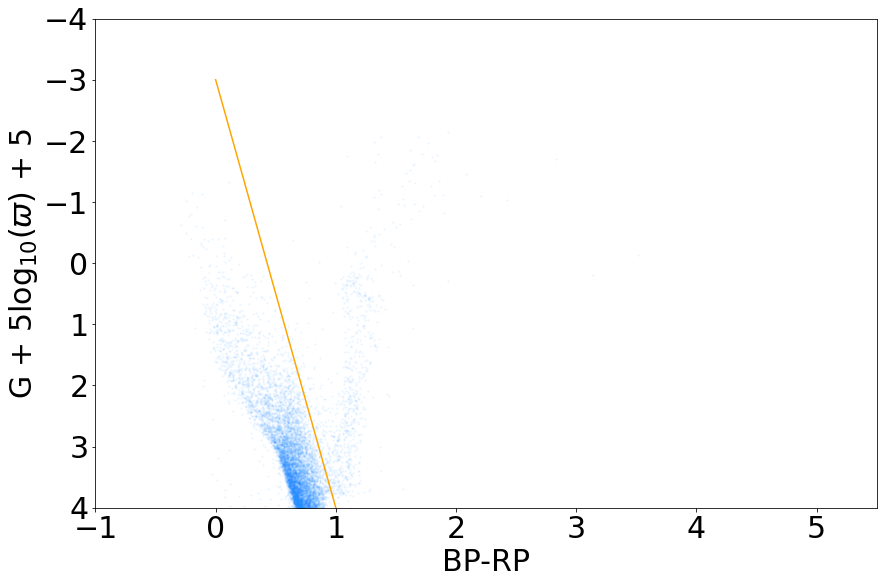

In [9]:
#Checking line to cut
x = np.linspace(0,2,10)
y = 7*x - 3.0

matplotlib.rcParams.update({'font.size': 30})

plt.figure(figsize=(14,9))
plt.plot(x,y,c='orange')
plt.scatter(df['bp_rp'],df['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.xlabel('BP-RP')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(4,-4)
plt.xlim(-1,5.5)
plt.show()
plt.close()

In [0]:
#splitting data
#Massive star
df_mas = df[(df['g_abs'] < 4)]
#Not massive
df_sma = df[(df['g_abs'] >= 4)]

#Filtering for massive stars
df_mas = df_mas[(df_mas['g_abs'] > 7*df_mas['bp_rp'] - 3.0)]

#Reseting index
df_mas = df_mas.reset_index(drop=True)
df_sma = df_sma.reset_index(drop=True)

frames = [df_mas,df_sma]
df_new = pd.concat(frames)

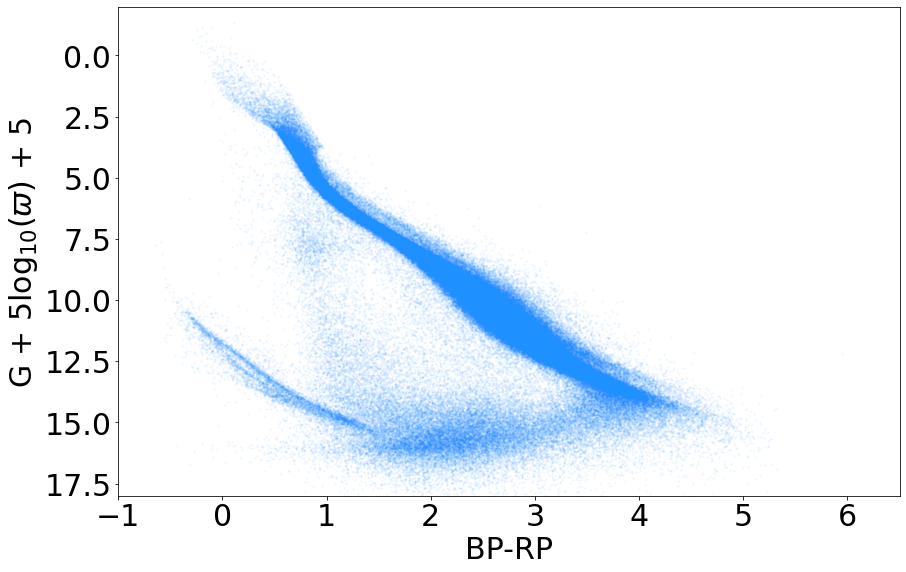

Cleaning RGB =  265452


In [11]:
#Cleaning RGS

#Massive star
df_mas = df[(df['g_abs'] < 4)]
#Not massive
df_sma = df[(df['g_abs'] >= 4)]

#Filtering for massive stars
df_mas = df_mas[(df_mas['g_abs'] > 7*df_mas['bp_rp'] - 3.0)]

#Reseting index
df_mas = df_mas.reset_index(drop=True)
df_sma = df_sma.reset_index(drop=True)

frames = [df_mas,df_sma]
df_new = pd.concat(frames)

x = np.linspace(0,2,10)
y = 7*x - 3

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_new['bp_rp'],df_new['g_abs'],alpha=0.05,c='dodgerblue',s=2)
#aplt.plot(x,y)
plt.xlabel('BP-RP')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(18,-2)
plt.xlim(-1,6.5)
plt.show()
plt.close()
print('Cleaning RGB = ',len(df_new))


In [0]:
m_30 =  {0: 1.1396005433164311, 1: 1.1398465833158444, 2: 1.140152879011894, 3: 1.1425528649146075, 4: 1.145438132500803, 5: 1.1654062595534107, 6: 1.1859407958663892, 7: 1.3149291026852064}
n_30 =  {0: 3.468418042650719, 1: 3.466760114920985, 2: 3.4646964127544706, 3: 3.4485467171259523, 4: 3.4291766210720036, 5: 3.2966220069331413, 6: 3.163303242694796, 7: 2.3842099462708677}
a_30 =  {0: -0.051179602261641394, 1: -0.05126486167026877, 2: -0.051370762049359205, 3: -0.052193364294646695, 4: -0.053167047770163046, 5: -0.059553036653806124, 6: -0.06564773807507811, 7: -0.09661575619559215}
b_30 =  {0: 1.6875392360316288, 1: 1.688815333507482, 2: 1.690401710960337, 3: 1.7027681952033462, 4: 1.717503200840745, 5: 1.816556251162629, 6: 1.9147115683528517, 7: 2.4724182489352784}
c_30 =  {0: 2.311373467461527, 1: 2.3069894239411752, 2: 2.301534977548113, 3: 2.258881572804663, 4: 2.2077645198044173, 5: 1.8572171866941583, 6: 1.5004216859402084, 7: -0.665415751690865}
d_30 =  {0: 0.009065209103791428, 1: 0.009092589300039063, 2: 0.009126430386538162, 3: 0.009383183955740736, 4: 0.009673928670620125, 5: 0.011283180199064699, 6: 0.012417030317000416, 7: 0.013701526921472916}
e_30 =  {0: -0.20491742196760893, 1: -0.2055035038684759, 2: -0.20622886441224103, 3: -0.2117677856755721, 4: -0.2181184851969582, 5: -0.2550901091822736, 6: -0.28392701446538293, 7: -0.35396115062656097}
f_30 =  {0: 2.435891763764071, 1: 2.4399067229850666, 2: 2.444884511597076, 3: 2.4832065806522534, 4: 2.5278302901115137, 5: 2.803676402236144, 6: 3.0429719505128183, 7: 3.9473894797288187}
g_30 =  {0: 1.3879330854524854, 1: 1.3793268578487663, 2: 1.3686341183298845, 3: 1.2855244113144917, 4: 1.1870153983040497, 5: 0.5376812000875096, 6: -0.0834663515377943, 7: -3.162862936567234}

#**Plotting some curves**

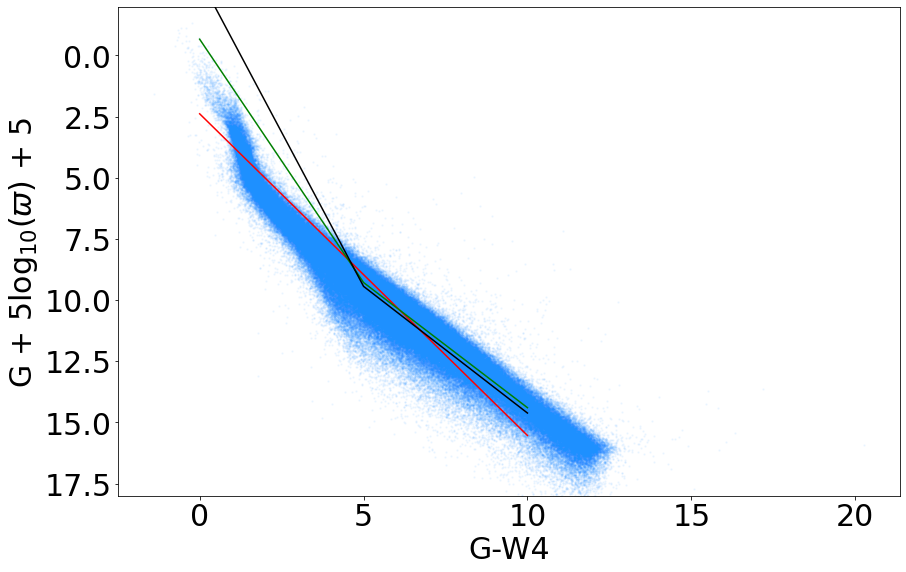

Cleaning RGB =  265452


In [13]:
x = np.linspace(0,10,3)
y = m_30[7]*x + n_30[7]
y2 = a_30[7]*x**2 + b_30[7]*x + c_30[7]
y3 = d_30[7]*x**3 + e_30[7]*x**2 + f_30[7]*x + g_30[7]

matplotlib.rcParams.update({'font.size': 30})
plt.figure(figsize=(14,9))
plt.scatter(df_new['g_w4'],df_new['g_abs'],alpha=0.05,c='dodgerblue',s=2)
plt.plot(x,y,c='r')
plt.plot(x,y2,c='g')
plt.plot(x,y3,c='k')
plt.xlabel('G-W4')
plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
plt.ylim(18,-2)
#plt.xlim(-1,6.5)
plt.show()
plt.close()
print('Cleaning RGB = ',len(df_new))

#**Counting Stars**

In [0]:
#T = 30
m_30 =  {0: 1.1396005433164311, 1: 1.1398465833158444, 2: 1.140152879011894, 3: 1.1425528649146075, 4: 1.145438132500803, 5: 1.1654062595534107, 6: 1.1859407958663892, 7: 1.3149291026852064}
n_30 =  {0: 3.468418042650719, 1: 3.466760114920985, 2: 3.4646964127544706, 3: 3.4485467171259523, 4: 3.4291766210720036, 5: 3.2966220069331413, 6: 3.163303242694796, 7: 2.3842099462708677}
a_30 =  {0: -0.051179602261641394, 1: -0.05126486167026877, 2: -0.051370762049359205, 3: -0.052193364294646695, 4: -0.053167047770163046, 5: -0.059553036653806124, 6: -0.06564773807507811, 7: -0.09661575619559215}
b_30 =  {0: 1.6875392360316288, 1: 1.688815333507482, 2: 1.690401710960337, 3: 1.7027681952033462, 4: 1.717503200840745, 5: 1.816556251162629, 6: 1.9147115683528517, 7: 2.4724182489352784}
c_30 =  {0: 2.311373467461527, 1: 2.3069894239411752, 2: 2.301534977548113, 3: 2.258881572804663, 4: 2.2077645198044173, 5: 1.8572171866941583, 6: 1.5004216859402084, 7: -0.665415751690865}
d_30 =  {0: 0.009065209103791428, 1: 0.009092589300039063, 2: 0.009126430386538162, 3: 0.009383183955740736, 4: 0.009673928670620125, 5: 0.011283180199064699, 6: 0.012417030317000416, 7: 0.013701526921472916}
e_30 =  {0: -0.20491742196760893, 1: -0.2055035038684759, 2: -0.20622886441224103, 3: -0.2117677856755721, 4: -0.2181184851969582, 5: -0.2550901091822736, 6: -0.28392701446538293, 7: -0.35396115062656097}
f_30 =  {0: 2.435891763764071, 1: 2.4399067229850666, 2: 2.444884511597076, 3: 2.4832065806522534, 4: 2.5278302901115137, 5: 2.803676402236144, 6: 3.0429719505128183, 7: 3.9473894797288187}
g_30 =  {0: 1.3879330854524854, 1: 1.3793268578487663, 2: 1.3686341183298845, 3: 1.2855244113144917, 4: 1.1870153983040497, 5: 0.5376812000875096, 6: -0.0834663515377943, 7: -3.162862936567234}
#T = 35
m_35 =  {0: 1.140109300506598, 1: 1.142333127329325, 2: 1.1449944728114403, 3: 1.162962486062958, 4: 1.1804445498732528, 5: 1.260578636687699, 6: 1.3176383791542772, 7: 1.534942384393018}
n_35 =  {0: 3.464540082333268, 1: 3.4477773308597577, 2: 3.4276676484202278, 3: 3.290637202531358, 4: 3.155422803046733, 5: 2.51523008932666, 6: 2.0405043895011765, 7: 0.0722671555893313}
a_35 =  {0: -0.05135568305046906, 1: -0.052118645582636916, 2: -0.05301842541721306, 3: -0.058799101300555094, 4: -0.06405509530995294, 5: -0.0849896251640391, 6: -0.0971384395633251, 7: -0.12180396213227242}
b_35 =  {0: 1.690175813945748, 1: 1.7016414518532625, 2: 1.7152471048606284, 3: 1.8046544435389142, 4: 1.8887324298822015, 5: 2.2496736957329815, 6: 2.4829743560175097, 7: 3.152467184020035}
c_35 =  {0: 2.3018617491505124, 1: 2.260531955411764, 2: 2.2111278206739966, 3: 1.8778380947711388, 4: 1.5523812795069405, 5: 0.04107120335614834, 6: -1.0370351383693237, 7: -4.92174236062513}
d_35 =  {0: 0.00912162734328048, 1: 0.009360299390482172, 2: 0.009630427505169362, 3: 0.011117324569541665, 4: 0.012154341212798108, 5: 0.014008867737042706, 6: 0.01366386176642562, 7: 0.007408745970102259}
e_35 =  {0: -0.2061258322312406, 1: -0.21127148464597575, 2: -0.21716280672850885, 3: -0.2511080473401073, 4: -0.2769403481415907, 5: -0.34165342234408186, 6: -0.3540771402461381, 7: -0.2743699314621587}
f_35 =  {0: 2.444176830796752, 1: 2.4797497824881565, 2: 2.5210673203614444, 3: 2.772503080695333, 4: 2.98254523165529, 5: 3.666686289167941, 6: 3.9581572095437205, 7: 4.144151188711779}
g_35 =  {0: 1.369705726304051, 1: 1.2908334583189407, 2: 1.1975807401821879, 3: 0.5924906325779944, 4: 0.03545225720941593, 5: -2.2116040946779107, 6: -3.541801612504015, 7: -6.933296291928164}
#T = 40
m_40 =  {0: 1.1423819337995271, 1: 1.1525183276091606, 2: 1.1632424384186715, 3: 1.2180307885572577, 4: 1.259029064183396, 5: 1.3997835330409796, 6: 1.4768500622102936, 7: 1.662079245525565}
n_40 =  {0: 3.4471870195273233, 1: 3.3694367007027575, 2: 3.2862699780446922, 3: 2.848137596351635, 4: 2.5061396521581765, 5: 1.2285324737914194, 6: 0.44302691238842506, 7: -1.9622193338281306}
a_40 =  {0: -0.05213527653352441, 1: -0.05549544730702416, 2: -0.05888606987715987, 3: -0.07445798506340728, 4: -0.0846278262340929, 5: -0.11054710239667641, 6: -0.11863111928187, 7: -0.11957061276736787}
b_40 =  {0: 1.7018921059802297, 1: 1.753146704695674, 2: 1.8060235049755262, 3: 2.0626648800876213, 4: 2.2430446658539456, 5: 2.7785633376100094, 6: 3.0089094022398095, 7: 3.3985356088188836}
c_40 =  {0: 2.2594033110429117, 1: 2.070489607468218, 2: 1.8704155522228698, 3: 0.8356232984062111, 4: 0.04869875634639211, 5: -2.6546018999798395, 6: -4.105753643326883, 7: -7.953377562916205}
d_40 =  {0: 0.009365416003232789, 1: 0.010317051258759943, 2: 0.01113678529290508, 3: 0.01348570210314061, 4: 0.01400332617235539, 5: 0.011861907150826976, 6: 0.009407342204446051, 7: 0.003991379230523332}
e_40 =  {0: -0.21138234207889234, 1: -0.23248894404557063, 2: -0.2515725849515677, 3: -0.31614096595708985, 4: -0.3409961467590536, 5: -0.3413204832490057, 6: -0.3074912459007308, 7: -0.20866921784957648}
f_40 =  {0: 2.4805209515567586, 1: 2.631623264113493, 2: 2.776116709211398, 3: 3.351538463523552, 4: 3.6567775296843887, 5: 4.169513338199685, 6: 4.1966897168451975, 7: 4.0368048830159164}
g_40 =  {0: 1.288888243407633, 1: 0.9384011423376875, 2: 0.5811102035351999, 3: -1.0878985103945351, 4: -2.194166013134327, 5: -5.198872074267093, 6: -6.412170445024943, 7: -9.4113012776619}
#T = 45
m_45 =  {0: 1.1487010245696785, 1: 1.176004947093481, 2: 1.2002179547372636, 3: 1.2978633071295982, 4: 1.358623874843479, 5: 1.5260957969799207, 6: 1.5953645257803837, 7: 1.706859212650904}
n_45 =  {0: 3.3986877453013067, 1: 3.1855003349356568, 2: 2.991643288155658, 3: 2.164039506285201, 4: 1.6076131169986656, 5: -0.16566073143505194, 6: -1.0780404267392236, 7: -3.3509808646915933}
a_45 =  {0: -0.05425029450588746, 1: -0.06274963282670153, 2: -0.06966640208408444, 3: -0.09318585519224101, 4: -0.10443948481821078, 5: -0.12147652141972369, 6: -0.12234115024517257, 7: -0.11581136282437283}
b_45 =  {0: 1.734015169834432, 1: 1.867607548206581, 2: 1.981296645533849, 3: 2.404534562718014, 4: 2.6367179567859975, 5: 3.132096813139762, 6: 3.2766243742012224, 7: 3.5217857843971423}
c_45 =  {0: 2.1414860985885977, 1: 1.6307538645955133, 2: 1.1732319147136456, 3: -0.7073969426188429, 4: -1.8830977057992886, 5: -5.094082727186998, 6: -6.5058030978860755, 7: -10.17364037558417}
d_45 =  {0: 0.009981932512866835, 1: 0.011921980352189545, 2: 0.012981900095059559, 3: 0.01389026943532736, 4: 0.012911523049703024, 5: 0.007708791902640535, 6: 0.00549143401647581, 7: 0.003580387833423207}
e_45 =  {0: -0.22494222515438353, 1: -0.270933699520214, 2: -0.29992698558828595, 3: -0.3521230238520003, 4: -0.35145694560184326, 5: -0.2795778543037641, 6: -0.23898824315778544, 7: -0.20153481046625552}
f_45 =  {0: 2.5766130767407622, 1: 2.9319303065492766, 2: 3.1889894569235144, 3: 3.87216649367247, 4: 4.09085562081533, 5: 4.1544445183223395, 6: 4.064710405337252, 7: 4.185559409106105}
g_45 =  {0: 1.0685914193503347, 1: 0.16984319067918768, 2: -0.5722223010942938, 3: -3.147475112739526, 4: -4.450905972654101, 5: -7.153917662175494, 6: -8.184304495102547, 7: -11.828494020413864}
#T = 50
m_50 =  {0: 1.160852521439799, 1: 1.2116647693456675, 2: 1.2502442971738341, 3: 1.382767886272794, 4: 1.4538708854899969, 5: 1.6116993320086235, 6: 1.6609894934478828, 7: 1.7213437233770112}
n_50 =  {0: 3.3044581882283706, 1: 2.8980391645801338, 2: 2.5762415178630533, 3: 1.3718660164267193, 4: 0.6443326653367821, 5: -1.363398193308923, 6: -2.257248487290694, 7: -4.329786023050658}
a_50 =  {0: -0.05814335409664948, 1: -0.07277377429232748, 2: -0.08254902338543726, 3: -0.10817327445968865, 4: -0.11667944942667972, 5: -0.12198942479715945, 6: -0.11963150817480295, 7: -0.11440425531916402}
b_50 =  {0: 1.7943440035134983, 1: 2.0338092447453042, 2: 2.2052415645185874, 3: 2.7214977731166003, 4: 2.9450384819102395, 5: 3.3067360874810614, 6: 3.3962524238074576, 7: 3.6252063021050716}
c_50 =  {0: 1.91461484329088, 1: 0.9548501574275157, 2: 0.21363190721311406, 3: -2.352022015323659, 4: -3.715443797568083, 5: -6.911366850316436, 6: -8.235965726046803, 7: -11.9707320753807}
d_50 =  {0: 0.010968382970471192, 1: 0.013329014693012451, 2: 0.013956111400031704, 3: 0.012325641385878775, 4: 0.010182221494724256, 5: 0.0050449117791733, 6: 0.004007560322659287, 7: 0.0035362828153359268}
e_50 =  {0: -0.24757001997152964, 1: -0.3107896094486544, 2: -0.33694721119719034, 3: -0.3463209784645267, 4: -0.31916182302267204, 5: -0.23022164792281147, 6: -0.20899472154645501, 7: -0.20405774199500562}
f_50 =  {0: 2.7451175708186155, 1: 3.2958245991718322, 2: 3.59872337503509, 3: 4.143148269251105, 4: 4.202480686423742, 5: 4.046815179458525, 6: 4.035625266682299, 7: 4.36332855957618}
g_50 =  {0: 0.6592195770235447, 1: -0.9079967940765868, 2: -1.9709516451101208, 3: -4.915872903232561, 4: -6.115180458522057, 5: -8.511004117268952, 6: -9.694312655678573, 7: -13.937394758068097}
#T = 55
m_55 =  {0: 1.178562625999019, 1: 1.2537741326132428, 2: 1.3046583961329976, 3: 1.4591105014163972, 4: 1.5308083295100379, 5: 1.6610555137589607, 6: 1.6931875209809442, 7: 1.7265791898164036}
n_55 =  {0: 3.1649902445293607, 1: 2.5459155138592378, 2: 2.1011317366208484, 3: 0.5847808803635768, 4: -0.2465893419372278, 5: -2.288045587629961, 6: -3.1248259976107966, 7: -5.067087968571526}
a_55 =  {0: -0.06350498165532158, 1: -0.08339267570555567, 2: -0.09457813629439879, 3: -0.1171605294632668, 4: -0.12165305603205849, 5: -0.11962347271478191, 6: -0.11707312909622461, 7: -0.11390239910616312}
b_55 =  {0: 1.8798071141915973, 1: 2.2205103494529452, 2: 2.4318227426418773, 3: 2.9599764211128567, 4: 3.142932133637286, 5: 3.3963209242493333, 6: 3.471018122920064, 7: 3.712110591489711}
c_55 =  {0: 1.5823896194944724, 1: 0.14509778799909318, 2: -0.841640188777305, 3: -3.818815693212904, 4: -5.209725012095938, 5: -8.267248301525514, 6: -9.578522343774708, 7: -13.44296558028939}
d_55 =  {0: 0.012058685113890228, 1: 0.0139793797104486, 2: 0.013824504977170072, 3: 0.010007819322838759, 4: 0.00754752143197257, 5: 0.00400642227284371, 6: 0.00365244060283679, 7: 0.003523934961042573}
e_55 =  {0: -0.2744464903613276, 1: -0.3386630219475215, 2: -0.35306777138850953, 3: -0.3166024624593562, 4: -0.2767789693137674, 5: -0.20896680949709429, 6: -0.20199473398623358, 7: -0.20735626074899416}
f_55 =  {0: 2.96136243299365, 1: 3.6225852353680046, 2: 3.9035185008231315, 3: 4.202101265918477, 4: 4.148793108550875, 5: 4.035596713318268, 6: 4.107828760286941, 7: 4.518998410622829}
g_55 =  {0: 0.08890435317785571, 1: -2.0636494410556487, 2: -3.30667106864126, 3: -6.198743266518862, 4: -7.243579741837055, 5: -9.725493285619757, 6: -11.110771727013715, 7: -15.704616191417935}
#T = 60
m_60 =  {0: 1.1999342452475181, 1: 1.297048821001982, 2: 1.357240786231595, 3: 1.5208951604539187, 4: 1.5867820161976596, 5: 1.6880387703606294, 6: 1.7089660026996483, 7: 1.7287676423887777}
n_60 =  {0: 2.99345787425014, 1: 2.1688718846109696, 2: 1.6159021635128106, 3: -0.12667067872566135, 4: -1.0016066104217531, 5: -2.9873417403733242, 6: -3.775725602253432, 7: -5.645049867657643}
a_60 =  {0: -0.06958961281031115, 1: -0.09302180698032524, 2: -0.10421862913959175, 3: -0.1212651676344649, 4: -0.12243648631239605, 5: -0.11752550049162803, 6: -0.11559177670542112, 7: -0.11369623621003165}
b_60 =  {0: 1.9800039895233936, 1: 2.401304699752681, 2: 2.631799956692621, 3: 3.1199591434206795, 4: 3.2602421130321027, 5: 3.4563094340924243, 6: 3.531910682770535, 7: 3.783576954428371}
c_60 =  {0: 1.178088196710493, 1: -0.6941555618693616, 2: -1.8614010104610124, 3: -5.016411702585892, 4: -6.367246274822972, 5: -9.340029391246096, 6: -10.676205271303628, 7: -14.653262155382624}
d_60 =  {0: 0.012972902363923773, 1: 0.013898697889163307, 2: 0.012943456552744686, 3: 0.007887283411992069, 4: 0.0057407289977115285, 5: 0.0036906998188623117, 6: 0.003572916304334371, 7: 0.0035199966895723186}
e_60 =  {0: -0.29965190631538446, 1: -0.3520221798292804, 2: -0.3517054179731199, 3: -0.2826459873626251, 4: -0.24378331143666743, 5: -0.20260920785085576, 6: -0.20164538150819836, 7: -0.21040175056640673}
f_60 =  {0: 3.1863273707108357, 1: 3.8684999297953104, 2: 4.0875114016815015, 3: 4.160359820687892, 4: 4.0751866933375425, 5: 4.088348631838482, 6: 4.202535762783725, 7: 4.650056945018182}
g_60 =  {0: -0.5644515145292097, 1: -3.1313219412615965, 2: -4.428785513338331, 3: -7.104357443905734, 4: -8.090140875547814, 5: -10.84480197143024, 6: -12.359948802084581, 7: -17.17892070856668}
#T = 65
m_65 =  {0: 1.2228211550040122, 1: 1.338110657942703, 2: 1.4045832437620571, 3: 1.5677935870604351, 4: 1.6253566744761387, 5: 1.70297169899788, 6: 1.7171187055453703, 7: 1.72980818442505}
n_65 =  {0: 2.805886795993113, 1: 1.7954056869179793, 2: 1.1531609351154097, 3: -0.7341897348271407, 4: -1.6146252251089463, 5: -3.5246742291490105, 6: -4.2799879950870245, 7: -6.108536348029698}
a_65 =  {0: -0.07571053089897048, 1: -0.10094316847119512, 2: -0.11118632261278093, 3: -0.12244813042313593, 4: -0.12153309241111002, 5: -0.11616237754485759, 6: -0.11479769074758724, 7: -0.11359888653718044}
b_65 =  {0: 2.0842814448424494, 1: 2.561372131986991, 2: 2.794348544565769, 3: 3.2227277498003843, 4: 3.33127218835641, 5: 3.504760791911888, 6: 3.584095390723828, 7: 3.8421916954204427}
c_65 =  {0: 0.7410785905417703, 1: -1.4912903772839678, 2: -2.7743387496710343, 3: -5.964388385992467, 4: -7.267887449694138, 5: -10.221431074611582, 6: -11.588584368390254, 7: -15.653264269858655}
d_65 =  {0: 0.013589973598882957, 1: 0.01333237403608997, 2: 0.011725708034309333, 3: 0.006324643312295373, 4: 0.004705977146290377, 5: 0.003597293308383826, 6: 0.003547864943421283, 7: 0.0035188574437726265}
e_65 =  {0: -0.31990999895941385, 1: -0.353843816718354, 2: -0.33975095816574014, 3: -0.25478719967207686, 4: -0.22341812215079998, 5: -0.20146415989652375, 6: -0.20278043897994513, 7: -0.2130163814925137}
f_65 =  {0: 3.3920992031109614, 1: 4.031975056218115, 2: 4.1756788714511, 3: 4.100414126080735, 4: 4.035576499493486, 5: 4.158380407729167, 6: 4.291620915602344, 7: 4.759392536065092}
g_65 =  {0: -1.226351077670521, 1: -4.039305934032282, 2: -5.310880447812727, 3: -7.791027718868692, 4: -8.81037309854675, 5: -11.832277549654085, 6: -13.426612792651184, 7: -18.410203617661157}
#T = 70
m_70 =  {0: 1.2455752451510855, 1: 1.3752008215255567, 2: 1.4453305795604416, 3: 1.6022316395855907, 4: 1.6514647744874575, 5: 1.7115846969205535, 6: 1.7216265561807365, 7: 1.7303577157738796}
n_70 =  {0: 2.6153622128681855, 1: 1.4432377428493075, 2: 0.7312119383965522, 3: -1.237681572804467, 4: -2.105339915080754, 5: -3.9470714732843946, 6: -4.6808604036369275, 7: -6.485632391351152}
a_70 =  {0: -0.08142438333642672, 1: -0.10705788082328338, 2: -0.1158652400482245, 3: -0.12222271031866538, 4: -0.12023798694484976, 5: -0.11533303436847384, 6: -0.11435897816646162, 7: -0.1135475374268775}
b_70 =  {0: 2.184989346875869, 1: 2.6955156681879475, 2: 2.920394930438517, 3: 3.2894121225187263, 4: 3.378206901979831, 5: 3.546069813855405, 6: 3.628570373387515, 7: 3.890443793861314}
c_70 =  {0: 0.3032052653075202, 1: -2.2087826429726025, 2: -3.556674763980429, 3: -6.71524900825616, 4: -7.985738059350646, 5: -10.956652808947604, 6: -12.350805981669371, 7: -16.483821693205932}
d_70 =  {0: 0.01391919469929403, 1: 0.012521036900720057, 2: 0.010465083791910735, 3: 0.005298403637036951, 4: 0.004164651929550329, 5: 0.0035642392074104194, 6: 0.0035362231656661408, 7: 0.003518592814496007}
e_70 =  {0: -0.33455528565187, 1: -0.3482374623658826, 2: -0.3232472592459729, 3: -0.2352248523898707, 4: -0.21227288612161901, 5: -0.20187379539326658, 6: -0.2041850919224507, 7: -0.21521196820511795}
f_70 =  {0: 3.5664757977728816, 1: 4.129042632260148, 2: 4.202235531070985, 3: 4.056628029131522, 4: 4.0299116617588915, 5: 4.226397263590563, 6: 4.36963859644938, 7: 4.850542706395184}
g_70 =  {0: -1.8484374036848548, 1: -4.777402422294479, 2: -5.9870865451730335, 3: -8.35919303874393, 4: -9.454366952003312, 5: -12.681092032767076, 6: -14.329678584989628, 7: -19.44121950636047}
#T = 75
m_75 =  {0: 1.2671518776573794, 1: 1.4076526139537253, 2: 1.4794111270744714, 3: 1.6272274922987247, 4: 1.6692070553810001, 5: 1.7168056255441775, 6: 1.7242880230072821, 7: 1.7306734271154045}
n_75 =  {0: 2.4308445619077945, 1: 1.1219460394263412, 2: 0.35776963948672985, 3: -1.6497914102564728, 4: -2.4984345577878457, 5: -4.285659623974607, 6: -5.005355069165452, 7: -6.795534047883704}
a_75 =  {0: -0.08651075508878225, 1: -0.11158535784592445, 2: -0.11883463339511657, 3: -0.12146338489985124, 4: -0.11904720448611644, 5: -0.11482351920957774, 6: -0.11410223612093173, 7: -0.11351800786959848}
b_75 =  {0: 2.2776865736205396, 1: 2.8043453201470467, 2: 3.015888183704302, 3: 3.3346520855158404, 4: 3.4125109513264675, 5: 3.581459113903817, 6: 3.6661919948239095, 7: 3.9303640963849875}
c_75 =  {0: -0.11422657311027658, 1: -2.8337523629287875, 2: -4.211853643971369, 3: -7.318063133778653, 4: -8.571359279160909, 5: -11.573509089292937, 6: -12.989459451132511, 7: -17.176827637643004}
d_75 =  {0: 0.014023467779936991, 1: 0.011637301922002559, 2: 0.009320753804470398, 3: 0.004662355274251695, 4: 0.003890065024053822, 5: 0.0035489301103177363, 6: 0.0035297922731081463, 7: 0.00351858629707404}
e_75 =  {0: -0.34425740949332256, 1: -0.3387082112236827, 2: -0.3061545070050222, 3: -0.22253619687702939, 4: -0.20653992436049054, 5: -0.20270906646629536, 6: -0.2055535922322327, 7: -0.21704553000065588}
f_75 =  {0: 3.7076204074006753, 1: 4.179316995786992, 2: 4.195629939639162, 3: 4.034427996546978, 4: 4.044675822881044, 5: 4.287141712075175, 6: 4.43661479221695, 7: 4.926694647410483}
g_75 =  {0: -2.4068428065943244, 1: -5.364897780895616, 2: -6.507010422399567, 3: -8.853494197748455, 4: -10.029716132656016, 5: -13.40377630971482, 6: -15.093206559775503, 7: -20.307012652385506}
#T = 80
m_80 =  {0: 1.2869814808703706, 1: 1.4354588118963545, 2: 1.50742591674456, 3: 1.6454022717098618, 4: 1.6814545560282732, 5: 1.7201273214962316, 6: 1.7259528638532373, 7: 1.7308674818643677}
n_80 =  {0: 2.25781425505167, 1: 0.8354525224730842, 2: 0.03366605872346157, 3: -1.9862134724372187, 4: -2.81546806886348, 5: -4.561060713620058, 6: -5.271301003382103, 7: -7.05207613128063}
a_80 =  {0: -0.09090124212597023, 1: -0.11484883806576121, 2: -0.12062649745331726, 3: -0.12059296750554252, 4: -0.1180864789899786, 5: -0.11449961251334179, 6: -0.11394295862425094, 7: -0.11349982639010656}
b_80 =  {0: 2.3603527449014776, 1: 2.8911074573281166, 2: 3.0876938955114497, 3: 3.367178327600232, 4: 3.439555055531582, 5: 3.61164957530804, 6: 3.6979055334847226, 7: 3.9635465103179897}
c_80 =  {0: -0.49898792697962113, 1: -3.367681422132389, 2: -4.75489377052019, 3: -7.809541917847017, 4: -9.056895361419775, 5: -12.092526138396982, 6: -13.525896476040229, 7: -17.75724354402931}
d_80 =  {0: 0.013972488704280375, 1: 0.010784755132139801, 2: 0.00835366267954585, 3: 0.004276564080763476, 4: 0.003749316557390373, 5: 0.003540240530240399, 6: 0.0035260344345863118, 7: 0.0035186462866100368}
e_80 =  {0: -0.3500970825517453, 1: -0.32771065856169074, 2: -0.2905328631260265, 3: -0.21460706074489236, 4: -0.2036922553708321, 5: -0.20362159780650418, 6: -0.20679688118757972, 7: -0.21857692472153553}
f_80 =  {0: 3.818679187287695, 1: 4.199707602872194, 2: 4.174653182350413, 3: 4.028859475964742, 4: 4.068672140846861, 5: 4.339906060112855, 6: 4.49369777106474, 7: 4.990490137796286}
g_80 =  {0: -2.893986724704165, 1: -5.830064750797233, 2: -6.914296750575976, 3: -9.290023247130982, 4: -10.536629356290725, 5: -14.017324935585734, 6: -15.738987242313526, 7: -21.035894868645528}
#T = 85
m_85 =  {0: 1.304816177806971, 1: 1.4589633269214302, 2: 1.5302359122876452, 3: 1.6587392730683241, 4: 1.6900845392583306, 5: 1.7223343823174222, 6: 1.7270466047190765, 7: 1.7309934323208094}
n_85 =  {0: 2.099230720828194, 1: 0.5840605201000476, 2: -0.24409766830604676, 3: -2.2614175681619058, 4: -3.073249105318879, 5: -4.787415734008782, 6: -5.49112667708325, 7: -7.265577096747627}
a_85 =  {0: -0.09461577164398989, 1: -0.11716182807580312, 2: -0.12164859276535708, 3: -0.11978495946021249, 4: -0.11734753519321173, 5: -0.11428546972447029, 6: -0.11383894129386068, 7: -0.1134880030765725}
b_85 =  {0: 2.432528528773305, 1: 2.9597456059110225, 2: 3.141817752431762, 3: 3.391866440579997, 4: 3.4618267536507155, 5: 3.637305794837976, 6: 3.72461137453155, 7: 3.99123518592775}
c_85 =  {0: -0.8454204794588887, 1: -3.818858862418506, 2: -5.203556716230391, 3: -8.215358598406295, 4: -9.46336311040153, 5: -12.529988068128889, 6: -13.977379503095857, 7: -18.24475337239873}
d_85 =  {0: 0.01382478484433242, 1: 0.010015200011814284, 2: 0.007568765980655113, 3: 0.004042116647890013, 4: 0.003674377585549649, 5: 0.003534753035173496, 6: 0.0035237770709851063, 7: 0.00351871473147536}
e_85 =  {0: -0.3531306246193222, 1: -0.3167384761531018, 2: -0.2771685154029101, 3: -0.20971454472415202, 4: -0.20232594888173153, 5: -0.2044950147180891, 6: -0.20789236856822269, 7: -0.219858151002303}
f_85 =  {0: 3.9045362047129717, 1: 4.202607159007217, 2: 4.149881553646466, 3: 4.033620437885541, 4: 4.095325832202869, 5: 4.38523769280074, 6: 4.542192018183622, 7: 5.044064189456982}
g_85 =  {0: -3.311435814787396, 1: -6.1999337996022, 2: -7.240947192632808, 3: -9.674721857858339, 4: -10.977634924730316, 5: -14.537821891595696, 6: -16.285494206612338, 7: -21.65069720927336}
#T = 90
m_90 =  {0: 1.3206090216203847, 1: 1.4786606362728218, 2: 1.5487264433631605, 3: 1.668650159136549, 4: 1.6962978310318368, 5: 1.7238566904988597, 6: 1.727795120938545, 7: 1.731078864446608}
n_90 =  {0: 1.956348911756168, 1: 0.3659858494086525, 2: -0.48024236084803956, 3: -2.487392399006272, 4: -3.2844114804564857, 5: -4.974808503536561, 6: -5.673882599065698, 7: -7.443922085519247}
a_90 =  {0: -0.0977178802342858, 1: -0.11878430605055541, 2: -0.12218602038828706, 3: -0.11909398346279713, 4: -0.11678749149537333, 5: -0.11413857352318545, 6: -0.11376802823376324, 7: -0.11347996853250254}
b_90 =  {0: 2.4946461529545925, 1: 3.0139592304932914, 2: 3.1829435888005735, 3: 3.4113996647053177, 4: 3.4805588873679905, 5: 3.6590530003228663, 6: 3.747098412649585, 7: 4.014406211996285}
c_90 =  {0: -1.152152394635126, 1: -4.19786096528951, 2: -5.5743953570957645, 3: -8.55342808828774, 4: -9.805421877623015, 5: -12.899096188426581, 6: -14.35788374420673, 7: -18.655018895989095}
d_90 =  {0: 0.01362399961807778, 1: 0.009347454993238993, 2: 0.006945752717856324, 3: 0.003897247190401285, 4: 0.003632262296304457, 5: 0.0035311004859961983, 6: 0.003522388571250627, 7: 0.0035187754565078238}
e_90 =  {0: -0.3542362156099239, 1: -0.3065819679918572, 2: -0.2661489584065209, 3: -0.20669182517049126, 4: -0.20171375615493428, 5: -0.20528914852799904, 6: -0.20884218456011572, 7: -0.2209319977743157}
f_90 =  {0: 3.9701983376354026, 1: 4.196221315413363, 2: 4.126437192319658, 3: 4.043861740474788, 4: 4.1213432648284885, 5: 4.423973144115386, 6: 4.58331668148647, 7: 5.0891339307488925}
g_90 =  {0: -3.6651636119129156, 1: -6.496635992318213, 2: -7.508566719354999, 3: -10.01124535666048, 4: -11.357877331166227, 5: -14.97920927589126, 6: -16.748126273156608, 7: -22.169895420301508}
#T = 95
m_95 =  {0: 1.3344302456471486, 1: 1.4950776560431827, 2: 1.5636963907195993, 3: 1.6761150577938724, 4: 1.7008633747449244, 5: 1.7249402757457892, 6: 1.7283249379395604, 7: 1.7311389196576092}
n_95 =  {0: 1.8293246074724696, 1: 0.17840766247874584, 2: -0.6799496821682155, 3: -2.6736528642839392, 4: -3.4584048278499604, 5: -5.130683244120749, 6: -5.826381081495736, 7: -7.593249947702392}
a_95 =  {0: -0.10028709048247247, 1: -0.11991544108062967, 2: -0.12242790049133281, 3: -0.118524507588962, 4: -0.1163630708147384, 5: -0.1140345086526698, 6: -0.11371794715689788, 7: -0.11347430985994361}
b_95 =  {0: 2.547577302352277, 1: 3.0568622034107995, 2: 3.2145279398678572, 3: 3.427289111269597, 4: 3.4964487247694063, 5: 3.677452623794189, 6: 3.7660323896465258, 7: 4.033831837896755}
c_95 =  {0: -1.420369793710961, 1: -4.515236926059907, 2: -5.881453020422597, 3: -8.836598281790556, 4: -10.093963023740578, 5: -13.210632776427705, 6: -14.678759941015125, 7: -19.000614563135837}
d_95 =  {0: 0.013400467633317105, 1: 0.008781927215857587, 2: 0.0064566883436561525, 3: 0.003805451721101092, 4: 0.0036071213652911368, 5: 0.0035285931992171497, 6: 0.0035215140770596827, 7: 0.0035188254855158356}
e_95 =  {0: -0.35408733543147497, 1: -0.2975814546284576, 2: -0.257246458004695, 3: -0.20480852318469853, 4: -0.20148589309464168, 5: -0.20599259948871168, 6: -0.20965784308147922, 7: -0.22183313812233427}
f_95 =  {0: 4.02010868551086, 1: 4.18559458977402, 2: 4.106321348383651, 3: 4.056445889823072, 4: 4.1452685816392245, 5: 4.456957322045514, 6: 4.618143345355356, 7: 5.127084408719397}
g_95 =  {0: -3.962761577958335, 1: -6.7370251325316834, 2: -7.731330761299488, 3: -10.303302387943639, 4: -11.683697425008186, 5: -15.353264431392322, 6: -17.139664167743366, 7: -22.60852446366296}
#T = 100
m_100 =  {0: 1.3464125284820283, 1: 1.5087120370356133, 2: 1.5758206351083464, 3: 1.6818105664641712, 4: 1.7042797640464207, 5: 1.7257319356641623, 6: 1.7287104219257443, 7: 1.7311823750565132}
n_100 =  {0: 1.7176391932065946, 1: 0.018129265904379337, 2: -0.8482023444698273, 3: -2.8276406263892775, 4: -3.6023589368600497, 5: -5.260693694015358, 6: -5.953880061172066, 7: -7.718412671557958}
a_100 =  {0: -0.10240360359174072, 1: -0.12070120842018464, 2: -0.12249567753803135, 3: -0.11806301950312856, 4: -0.11603942707143312, 5: -0.11395876698427675, 6: -0.1136815524959225, 7: -0.11347020868195758}
b_100 =  {0: 2.592355885799833, 1: 3.0909371504158716, 2: 3.2390568386444487, 3: 3.4404307411605295, 4: 3.509955746270535, 5: 3.692992210782966, 6: 3.7819666503530995, 7: 4.05012884584262}
c_100 =  {0: -1.6526327836192098, 1: -4.7805116926576146, 2: -6.136158103753612, 3: -9.074425307847477, 4: -10.337465778570996, 5: -13.473446662040084, 6: -14.94927330731243, 7: -19.29172442243861}
d_100 =  {0: 0.013174155081148052, 1: 0.008310156777920881, 2: 0.006074420865471788, 3: 0.0037455732766380526, 4: 0.003591201211814962, 5: 0.003526832754504609, 6: 0.003520950265243189, 7: 0.003518865570920083}
e_100 =  {0: -0.3531751955967405, 1: -0.2898180203208837, 2: -0.25013116689551407, 3: -0.20362191164010301, 4: -0.20145291011228417, 5: -0.20660593961567283, 6: -0.2103537513854207, 7: -0.22258962164760762}
f_100 =  {0: 4.0579352391480334, 1: 4.1736359916073305, 2: 4.089949331725126, 3: 4.069521392801628, 4: 4.1665769528015755, 5: 4.484961400661775, 6: 4.647589909715753, 7: 5.159039324506366}
g_100 =  {0: -4.211944560752977, 1: -6.933529534548056, 2: -7.918616383650236, 3: -10.554947673299488, 4: -11.961561306592753, 5: -15.669864049526588, 6: -17.470718788170565, 7: -22.978896645862623}
#T = 125
m_125 =  {0: 1.384413811455675, 1: 1.5484586442988404, 2: 1.609543932558817, 3: 1.6961003618165242, 4: 1.7125912083059802, 5: 1.7275900812635703, 6: 1.729609719532485, 7: 1.7312827985737163}
n_125 =  {0: 1.3531063562510117, 1: -0.4769618950441323, 2: -1.3551172694760316, 3: -3.2792064772579192, 4: -4.025987031108474, 5: -5.648874564163728, 6: -6.335989683536471, 7: -8.094952943816534}
a_125 =  {0: -0.10842829501447769, 1: -0.12218794736392283, 2: -0.12207156656570199, 3: -0.11681205983109307, 4: -0.11523641748104367, 5: -0.11378195680900226, 6: -0.11359667412483189, 7: -0.11346069637278319}
b_125 =  {0: 2.7273303777936726, 1: 3.1824719643588923, 2: 3.303058974277304, 3: 3.4799118548203416, 4: 3.5517910126018495, 5: 3.7402743453186744, 6: 3.830192167500051, 7: 4.09922389788541}
c_125 =  {0: -2.387032452900961, 1: -5.5695269929563676, 2: -6.887401413769338, 3: -9.79522346254371, 4: -11.079821895436387, 5: -14.27304205113611, 6: -15.77143106574004, 7: -20.17528493399396}
d_125 =  {0: 0.012286456436393265, 1: 0.006955578184270204, 2: 0.00510211401561799, 3: 0.0036331203547454167, 4: 0.0035609003245146297, 5: 0.0035230986621579423, 6: 0.0035199531045014675, 7: 0.003518971288476069}
e_125 =  {0: -0.34598010534991874, 1: -0.2663360892943857, 2: -0.23137640908568918, 3: -0.2017220088173677, 4: -0.2019752968914638, 5: -0.2085589917861073, 6: -0.21250068519600473, 7: -0.22487041069402894}
f_125 =  {0: 4.146774407060133, 1: 4.127026713608949, 2: 4.049204274909073, 3: 4.120271899762839, 4: 4.236048215989219, 5: 4.570970552750275, 6: 4.737444306454993, 7: 5.255947585864136}
g_125 =  {0: -4.950528595559639, 1: -7.50547439752359, 2: -8.496824730199684, 3: -11.345840113358173, 4: -12.82079478991772, 5: -16.6387440683207, 6: -18.482116242123453, 7: -24.108009275391414}
#T = 150
m_150 =  {0: 1.3985195746462884, 1: 1.561925385184933, 2: 1.62041444131811, 3: 1.7002468734484302, 4: 1.7149320204262923, 5: 1.7280961819087797, 6: 1.7298532544542895, 7: 1.7313097021314305}
n_150 =  {0: 1.2134640625579065, 1: -0.6560963678730144, 2: -1.534210269157721, 3: -3.4355788170322867, 4: -4.173451806528226, 5: -5.785918087233376, 6: -6.471328028791107, 7: -8.228747328154235}
a_150 =  {0: -0.11039644629003656, 1: -0.12241665355676376, 2: -0.12174012358670193, 3: -0.11642750979124564, 4: -0.11500792844823791, 5: -0.11373400778120824, 6: -0.11357365324328635, 7: -0.11345813585409714}
b_150 =  {0: 2.7746422738132765, 1: 3.2109816274055807, 2: 3.322703067760767, 3: 3.4941527547050306, 4: 3.567101559130211, 5: 3.7572330982612563, 6: 3.847413301174266, 7: 4.116688414426227}
c_150 =  {0: -2.658715741941498, 1: -5.845317417004932, 2: -7.1492636169713455, 3: -10.053993439970652, 4: -11.347249491280714, 5: -14.560281604844795, 6: -16.066505732812143, 7: -20.492009410807867}
d_150 =  {0: 0.011901710903260719, 1: 0.0065145474902379005, 2: 0.004825386125657705, 3: 0.0036098945101139287, 4: 0.00355399351844541, 5: 0.0035222329473617066, 6: 0.0035197818102058404, 7: 0.003519002771186725}
e_150 =  {0: -0.3418273142675675, 1: -0.25832197207457613, 2: -0.22585167450803464, 3: -0.20149770987029064, 4: -0.20232294356775374, 5: -0.20928492944780014, 6: -0.21327866016748723, 7: -0.22568222912506844}
f_150 =  {0: 4.1685775419698885, 1: 4.108961787958345, 2: 4.039459635457627, 3: 4.14158921024833, 4: 4.26226839046266, 5: 4.6021035406559685, 6: 4.769787577137307, 7: 5.290653925924468}
g_150 =  {0: -5.205845533340377, 1: -7.705402110156456, 2: -8.711306321921436, 3: -11.637679397473978, 4: -13.133734583851789, 5: -16.988789789215485, 6: -18.846965035929006, 7: -24.51456671768602}
#T = 175
m_175 =  {0: 1.399926855109482, 1: 1.5632322480837542, 2: 1.6214542116682433, 3: 1.7006322749675173, 4: 1.7151479431477936, 5: 1.728142486018206, 6: 1.7298755038203733, 7: 1.7313121513931191}
n_175 =  {0: 1.1993943098841606, 1: -0.6738431490014811, 2: -1.5518395442059465, 3: -3.450910312105889, 4: -4.187935686026638, 5: -5.799429840030405, 6: -6.48468246436884, 7: -8.241959774753939}
a_175 =  {0: -0.11058479682012325, 1: -0.12243134701314366, 2: -0.12170340279445342, 3: -0.1163913554144429, 4: -0.11498683459013265, 5: -0.11372962408432774, 6: -0.11357154799717521, 7: -0.11345790202111149}
b_175 =  {0: 2.779278332151986, 1: 3.213684959034607, 2: 3.324567039755133, 3: 3.495568895472443, 4: 3.5686257930351553, 5: 3.758911605182414, 6: 3.8491159647537323, 7: 4.118413535884478}
c_175 =  {0: -2.6857952221464623, 1: -5.872401529493922, 2: -7.174995253973284, 3: -10.079635840525512, 4: -11.373762725287465, 5: -14.588733630057181, 6: -16.095727057684943, 7: -20.523364581727364}
d_175 =  {0: 0.011861930780782263, 1: 0.0064724869134350485, 2: 0.0048000315391181735, 3: 0.0036079288668585162, 4: 0.003553382298824155, 5: 0.0035221582749569687, 6: 0.003519768730451692, 7: 0.0035190057279670677}
e_175 =  {0: -0.3413733183394779, 1: -0.2575481912698065, 2: -0.22534101464754794, 3: -0.20148530424943625, 4: -0.2023608084274206, 5: -0.20935737850010927, 6: -0.21335583308151024, 7: -0.22576243021990783}
f_175 =  {0: 4.1704424448082404, 1: 4.107190450870793, 2: 4.038661345962384, 3: 4.1437699798686225, 4: 4.264894154335617, 5: 4.605192856869032, 6: 4.772992498595989, 7: 5.294088839980196}
g_175 =  {0: -5.230791687942012, 1: -7.725146914721325, 2: -8.732816905532163, 3: -11.666775204075162, 4: -13.164840781760853, 5: -17.02351849365594, 6: -18.883148034043813, 7: -24.55486697184096}
#T = 200
m_200 =  {0: 1.3945497930587418, 1: 1.558203305568844, 2: 1.617438354884472, 3: 1.6991330207432287, 4: 1.7143064026583519, 5: 1.7279616576715036, 6: 1.7297885834982722, 7: 1.7313025725972513}
n_200 =  {0: 1.2530162361653694, 1: -0.6059152527282428, 2: -1.4842529981497288, 3: -3.3920781303376284, 4: -4.132381736535066, 5: -5.747654110800224, 6: -6.433519808819424, 7: -8.191350881466477}
a_200 =  {0: -0.10985729777846272, 1: -0.12236751597365382, 2: -0.12184038089753846, 3: -0.11653162172662165, 4: -0.11506903563954814, 5: -0.11374674600246514, 6: -0.11357976975285765, 7: -0.1134588149314605}
b_200 =  {0: 2.7614820931207418, 1: 3.2032217670140737, 2: 3.317355695730337, 3: 3.490154581383353, 4: 3.562799222565229, 5: 3.7524858451184975, 6: 3.8425960141556748, 7: 4.111806066354827}
c_200 =  {0: -2.58230361865034, 1: -5.7685094644374315, 2: -7.076312421164048, 3: -9.981503282818803, 4: -11.272308064246795, 5: -14.479835140794805, 6: -15.983877629593868, 7: -20.403337734667904}
d_200 =  {0: 0.0120126056229336, 1: 0.00663510316137693, 2: 0.004899063612082713, 3: 0.0036157554700136526, 4: 0.003555787563577321, 5: 0.0035224544660907575, 6: 0.003519822389573314, 7: 0.0035189943081514008}
e_200 =  {0: -0.34306996710715953, 1: -0.2605306232738031, 2: -0.22733128573173964, 3: -0.20154183776194473, 4: -0.20221906389327632, 5: -0.20908058763133688, 6: -0.21306055522731382, 7: -0.22545525993011611}
f_200 =  {0: 4.163017481329879, 1: 4.1139973899148785, 2: 4.041882842244879, 3: 4.135487623187587, 4: 4.254870943353428, 5: 4.59337381976809, 6: 4.760726929756831, 7: 5.280939146396014}
g_200 =  {0: -5.134968026012447, 1: -7.649535962015844, 2: -8.650755609963296, 3: -11.555590648249062, 4: -13.045887325414192, 5: -16.890650218619452, 6: -18.744702096511954, 7: -24.400649090061233}
#T = 225
m_225 =  {0: 1.3855545130651252, 1: 1.5495727869223377, 2: 1.610454043957805, 3: 1.69645582049562, 4: 1.7127931395891813, 5: 1.7276340376249322, 6: 1.7296308961512064, 7: 1.731285143800057}
n_225 =  {0: 1.341905503081172, 1: -0.491535171959171, 2: -1.369767181623225, 3: -3.292045254502098, 4: -4.0380771234452215, 5: -5.66007390519018, 6: -6.3470419183486735, 7: -8.105871623956347}
a_225 =  {0: -0.10859287156361462, 1: -0.122212198182626, 2: -0.12204748491887331, 3: -0.1167794286667937, 4: -0.11521672686602374, 5: -0.11377778931190972, 6: -0.11359467353911391, 7: -0.11346047341949146}
b_225 =  {0: 2.7312131637508013, 1: 3.1848767133885807, 2: 3.30471687593017, 3: 3.4810677557690277, 4: 3.5530318641940335, 5: 3.741655573708536, 6: 3.831596071545408, 7: 4.10064879868908}
c_225 =  {0: -2.409020820729544, 1: -5.592135131949679, 2: -6.908863468351329, 3: -9.816281993336007, 4: -11.101573997926621, 5: -14.296422897960877, 6: -15.795454500672045, 7: -20.201078105294535}
d_225 =  {0: 0.012256331542488933, 1: 0.006918611488399732, 2: 0.005078161791623803, 3: 0.003630975492889872, 4: 0.00356028247652803, 5: 0.00352302014920437, 6: 0.0035199362669816737, 7: 0.003518973980568923}
e_225 =  {0: -0.3456719368269848, 1: -0.2656712913837249, 2: -0.23090168742402348, 3: -0.20169648021163175, 4: -0.20200106933748788, 5: -0.20861768339731962, 6: -0.2125639214564465, 7: -0.2249366382019868}
f_225 =  {0: 4.148751744904074, 1: 4.125553565572288, 2: 4.0482999146665914, 3: 4.121956384144613, 4: 4.238161718475807, 5: 4.573500741689371, 6: 4.740076060438723, 7: 5.2587746270964}
g_225 =  {0: -4.9715384768292, 1: -7.521806823727377, 2: -8.514111553555077, 3: -11.36946046239521, 4: -12.84619091828292, 5: -16.66719878509769, 6: -18.511784418242094, 7: -24.141082579817557}
#T = 250
m_250 =  {0: 1.3747103540801717, 1: 1.53879908773347, 2: 1.6015723453569854, 3: 1.6929208661204331, 4: 1.7107744879975513, 5: 1.7271920890175012, 6: 1.7294177699619364, 7: 1.7312614940571671}
n_250 =  {0: 1.4477556588701623, 1: -0.3523454222610923, 2: -1.2292412157928667, 3: -3.1684825356064032, 4: -3.9218392500190125, 5: -5.552673795626583, 6: -6.24111281736449, 7: -8.001281016832019}
a_250 =  {0: -0.1069898546921594, 1: -0.12193761263079536, 2: -0.12225394477244861, 3: -0.11710093299466712, 4: -0.1154133064026062, 5: -0.11381971903226755, 6: -0.11361480017511909, 7: -0.11346271963447616}
b_250 =  {0: 2.693899646796373, 1: 3.1612645596219004, 2: 3.288408042831261, 3: 3.470033623750091, 4: 3.541209703935349, 5: 3.7284462014868995, 6: 3.8181595844040297, 7: 4.0870022838240745}
c_250 =  {0: -2.199853409543912, 1: -5.37487050830436, 2: -6.702564928639568, 3: -9.614966954050596, 4: -10.893736105311744, 5: -14.072900746218293, 6: -15.565752134118632, 7: -19.954400423174313}
d_250 =  {0: 0.012535163108845419, 1: 0.007279105209588303, 2: 0.0053176064723434256, 3: 0.003653650150305685, 4: 0.003566672535606645, 5: 0.0035238347047747655, 6: 0.0035201213856649117, 7: 0.0035189473083825553}
e_250 =  {0: -0.3483955724049357, 1: -0.27210036323241116, 2: -0.23561868398296848, 3: -0.20200025858236145, 4: -0.20177533132338704, 5: -0.20805981227595743, 6: -0.21196020076094066, 7: -0.22430242805185688}
f_250 =  {0: 4.128384057317105, 1: 4.139535401633199, 2: 4.057700145919836, 3: 4.106261472642904, 4: 4.218122870990943, 5: 4.549343661764572, 6: 4.714924512985366, 7: 5.231733065739037}
g_250 =  {0: -4.769149630156676, 1: -7.365021543200307, 2: -8.349948002722195, 3: -11.144699639611023, 4: -12.60398804431094, 5: -16.395453054518953, 6: -18.228372887603353, 7: -23.825039222592814}
#T = 275
m_275 =  {0: 1.3630429065126608, 1: 1.5267455667959111, 2: 1.5914225082015403, 3: 1.6886976341096605, 4: 1.7083323964115598, 5: 1.7266499154620498, 6: 1.7291556864108575, 7: 1.7312322831739382}
n_275 =  {0: 1.5601091012791946, 1: -0.2009113072019254, 2: -1.0747632229556547, 3: -3.031446893973418, 4: -3.793212582814485, 5: -5.434548358354443, 6: -6.124769134024243, 7: -7.886567407694311}
a_275 =  {0: -0.10516934674751982, 1: -0.12152493728502599, 2: -0.12241229451493926, 3: -0.11747572481439635, 4: -0.11565008948287908, 5: -0.11387125272368123, 6: -0.113639535432663, 7: -0.11346548868402416}
b_275 =  {0: 2.652757513167427, 1: 3.133879471649596, 2: 3.2693616298197634, 3: 3.4580080986009003, 4: 3.5284090152125738, 5: 3.7140172804488856, 6: 3.8034544221944864, 7: 4.072042337181648}
c_275 =  {0: -1.974469477143927, 1: -5.134903032487499, 2: -6.474395629998511, 3: -9.395136258915526, 4: -10.667129999261359, 5: -13.828897327829372, 6: -15.31490256325927, 7: -19.68486995223165}
d_275 =  {0: 0.012815115337987551, 1: 0.007689004893745153, 2: 0.005605695602162314, 3: 0.00368480252179421, 4: 0.003575115599715387, 5: 0.0035249005524430233, 6: 0.0035203930789370276, 7: 0.003518915788411512}
e_275 =  {0: -0.3507908162770039, 1: -0.2792641703420775, 2: -0.24121203184945078, 3: -0.20250232372096622, 4: -0.2015880420817706, 5: -0.2074598740520328, 6: -0.21130369249896805, 7: -0.22360735491022568}
f_275 =  {0: 4.10244823909871, 1: 4.154249129762923, 2: 4.069735489614666, 3: 4.090275444095542, 4: 4.196714797970248, 5: 4.523060580911062, 6: 4.687492601165211, 7: 5.202174713835099}
g_275 =  {0: -4.544610461997278, 1: -7.191714158169684, 2: -8.173157651359283, 3: -10.902204340945564, 4: -12.341164815575006, 5: -16.099538134005975, 6: -17.919549448560563, 7: -23.48038010596207}
#T = 300
m_300 =  {0: 1.3511600940292223, 1: 1.5139642768771941, 2: 1.5804159144567693, 3: 1.683889868864155, 4: 1.7055124165600708, 5: 1.7260135665393828, 6: 1.728847226194522, 7: 1.7311977435856758}
n_300 =  {0: 1.6729728014649974, 1: -0.04479700531738536, 2: -0.9136794605146445, 3: -2.8869281911737423, 4: -3.6578325303117794, 5: -5.311051124921927, 6: -6.00333407789621, 7: -7.76703092544797}
a_300 =  {0: -0.10321357395948837, 1: -0.12096653223606521, 2: -0.12249115369232451, 3: -0.11788897808505105, 4: -0.11592156406162551, 5: -0.11393188246219217, 6: -0.1136686419468593, 7: -0.1134687564640901}
b_300 =  {0: 2.609807881946152, 1: 3.1036917393345194, 2: 3.248123052582504, 3: 3.4455148718897535, 4: 3.5152538479662274, 5: 3.699054644320336, 6: 3.788170425889749, 7: 4.056462574831371}
c_300 =  {0: -1.7445755492473847, 1: -4.88325165758134, 2: -6.234419399404176, 3: -9.166989966081792, 4: -10.43247881558423, 5: -13.575941878988699, 6: -15.054730066039545, 7: -19.405154236242105}
d_300 =  {0: 0.013076757490825682, 1: 0.008128641460024606, 2: 0.005933418005409063, 3: 0.00372589611554341, 4: 0.003586007936949779, 5: 0.003526225611460982, 6: 0.0035207674306289346, 7: 0.0035188805532875597}
e_300 =  {0: -0.3526232124294103, 1: -0.28677221997473235, 2: -0.2474710535858223, 3: -0.20324626421185407, 4: -0.2014727637521974, 5: -0.20684949193999444, 6: -0.21062675100057596, 7: -0.22288372271026527}
f_300 =  {0: 4.071571710124945, 1: 4.168370202939858, 2: 4.083847898417692, 3: 4.075167156319162, 4: 4.175124753093131, 5: 4.49592250605674, 6: 4.659087770681242, 7: 5.171487114745948}
g_300 =  {0: -4.308455278743232, 1: -7.008792446346683, 2: -7.991770982567702, 3: -10.654301012318985, 4: -12.070596592609368, 5: -15.793589156565888, 6: -17.600012645473885, 7: -23.123431705563352}
#T = 325
m_325 =  {0: 1.3630429065126608, 1: 1.5267455667959111, 2: 1.5914225082015403, 3: 1.6886976341096605, 4: 1.7083323964115598, 5: 1.7266499154620498, 6: 1.7291556864108575, 7: 1.7312322831739382}
n_325 =  {0: 1.5601091012791946, 1: -0.2009113072019254, 2: -1.0747632229556547, 3: -3.031446893973418, 4: -3.793212582814485, 5: -5.434548358354443, 6: -6.124769134024243, 7: -7.886567407694311}
a_325 =  {0: -0.10516934674751982, 1: -0.12152493728502599, 2: -0.12241229451493926, 3: -0.11747572481439635, 4: -0.11565008948287908, 5: -0.11387125272368123, 6: -0.113639535432663, 7: -0.11346548868402416}
b_325 =  {0: 2.652757513167427, 1: 3.133879471649596, 2: 3.2693616298197634, 3: 3.4580080986009003, 4: 3.5284090152125738, 5: 3.7140172804488856, 6: 3.8034544221944864, 7: 4.072042337181648}
c_325 =  {0: -1.974469477143927, 1: -5.134903032487499, 2: -6.474395629998511, 3: -9.395136258915526, 4: -10.667129999261359, 5: -13.828897327829372, 6: -15.31490256325927, 7: -19.68486995223165}
d_325 =  {0: 0.012815115337987551, 1: 0.007689004893745153, 2: 0.005605695602162314, 3: 0.00368480252179421, 4: 0.003575115599715387, 5: 0.0035249005524430233, 6: 0.0035203930789370276, 7: 0.003518915788411512}
e_325 =  {0: -0.3507908162770039, 1: -0.2792641703420775, 2: -0.24121203184945078, 3: -0.20250232372096622, 4: -0.2015880420817706, 5: -0.2074598740520328, 6: -0.21130369249896805, 7: -0.22360735491022568}
f_325 =  {0: 4.10244823909871, 1: 4.154249129762923, 2: 4.069735489614666, 3: 4.090275444095542, 4: 4.196714797970248, 5: 4.523060580911062, 6: 4.687492601165211, 7: 5.202174713835099}
g_325 =  {0: -4.544610461997278, 1: -7.191714158169684, 2: -8.173157651359283, 3: -10.902204340945564, 4: -12.341164815575006, 5: -16.099538134005975, 6: -17.919549448560563, 7: -23.48038010596207}  
#T = 350
m_350 =  {0: 1.3280499602057545, 1: 1.4875923632213848, 2: 1.5569209648525377, 3: 1.6727967645390498, 4: 1.6988461286860874, 5: 1.724465134424455, 6: 1.7280929270149643, 7: 1.7311126666839987}
n_350 =  {0: 1.8881979311031873, 1: 0.26463121812729246, 2: -0.588533266760194, 3: -2.5888957361259903, 4: -3.37922187963666, 5: -5.059576553082806, 6: -5.756763154386904, 7: -7.525025873167223}
a_350 =  {0: -0.09911803376795342, 1: -0.119424710465503, 2: -0.1223399765100894, 3: -0.11878271927838391, 4: -0.11655182571935316, 5: -0.11408008574263721, 6: -0.113739868356153, 7: -0.11347678511148344}
b_350 =  {0: 2.5233113146263144, 1: 3.037556343094301, 2: 3.20041623006352, 3: 3.4200676873811795, 4: 3.489161155519151, 5: 3.669026297319242, 6: 3.7573709493366696, 7: 4.024954215414111}
c_350 =  {0: -1.2965877367658833, 1: -4.370305103064036, 2: -5.741582557419842, 3: -8.707174313536635, 4: -9.961878469464516, 5: -13.06802374895199, 6: -14.531905571707226, 7: -18.84248741803993}
d_350 =  {0: 0.013508883657606285, 1: 0.009040409178455442, 2: 0.0066759746915751135, 3: 0.003844395218193369, 4: 0.0036176572617416724, 5: 0.003529680833934146, 6: 0.0035218841406916444, 7: 0.0035188028317806705}
e_350 =  {0: -0.3542802318296268, 1: -0.3017380597690334, 2: -0.2612657211236617, 3: -0.20560145768787205, 4: -0.20156190498525714, 5: -0.20566717310802612, 6: -0.20928308169494517, 7: -0.22142122589414082}
f_350 =  {0: 3.997921734175408, 1: 4.190989471026195, 2: 4.115488959918714, 3: 4.050268450371819, 4: 4.134119680344786, 5: 4.441828171643379, 6: 4.602189406242307, 7: 5.109722050587405}
g_350 =  {0: -3.826751462430826, 1: -6.628054383749751, 2: -7.629567719116919, 3: -10.168736415817966, 4: -11.534040574384354, 5: -15.181868062344137, 6: -16.960313420519952, 7: -22.407686161376894}
#T = 375
m_375 =  {0: 1.3171574274671, 1: 1.4744425183472807, 2: 1.5448151223347104, 3: 1.6666185200747154, 4: 1.6950381957859197, 5: 1.7235525297603238, 6: 1.727645954256146, 7: 1.7310618924983219}
n_375 =  {0: 1.9877788681457593, 1: 0.41329877751097843, 2: -0.42937786942006484, 3: -2.4392761065545274, 4: -3.239466048385715, 5: -4.934762764211404, 6: -5.634772816783395, 7: -7.4056973634812}
a_375 =  {0: -0.09705500494162694, 1: -0.11846116422539964, 2: -0.12209423939296202, 3: -0.11924177427020859, 4: -0.1169027576149711, 5: -0.11416786183967782, 6: -0.11378214400671412, 7: -0.11348156610230484}
b_375 =  {0: 2.481217324910317, 1: 3.002601986675122, 2: 3.1744432365130284, 3: 3.40727458690299, 4: 3.4765250730705692, 5: 3.6543699319406504, 6: 3.742266516077501, 7: 4.009437112351857}
c_375 =  {0: -1.0851313180582998, 1: -4.116572740130945, 2: -5.495269884823997, 3: -8.4809856591696, 4: -9.731886369765208, 5: -12.819709889681048, 6: -14.276077885585815, 7: -18.56685734476762}
d_375 =  {0: 0.013673075382716548, 1: 0.009491707467183055, 2: 0.007076057154772687, 3: 0.0039248286300171764, 4: 0.003640038814762015, 5: 0.0035318197913646425, 6: 0.0035226524127352984, 7: 0.0035187624193320616}
e_375 =  {0: -0.3541143987879636, 1: -0.30882116592496067, 2: -0.26848343827005705, 3: -0.20726483212574318, 4: -0.20181082759334518, 5: -0.2051144953094273, 6: -0.20863623870090908, 7: -0.22070160249426224}
f_375 =  {0: 3.9566494280230393, 1: 4.198206484950291, 2: 4.131569923670399, 3: 4.041210843269139, 4: 4.115515275921206, 5: 4.415608646364546, 6: 4.574458025138909, 7: 5.079450435448075}
g_375 =  {0: -3.5891126482844906, 1: -6.433956259527311, 2: -7.451445858702834, 3: -9.937972610154564, 4: -11.275533769820974, 5: -14.884111120941988, 6: -16.648509244307903, 7: -22.05818677336751}
#T = 400
m_400 =  {0: 1.3068097581287197, 1: 1.4615064083407523, 2: 1.5326554104783996, 3: 1.6600808495886545, 4: 1.6909356360656649, 5: 1.722546181689638, 6: 1.727151036191498, 7: 1.7310053912201888}
n_400 =  {0: 2.081323786164663, 1: 0.5563041578135057, 2: -0.2743975555622228, 3: -2.2907953856750374, 4: -3.1007172446444264, 5: -4.811686172402196, 6: -5.514758907878872, 7: -7.2885982967512}
a_400 =  {0: -0.09501709449104823, 1: -0.11738752599661822, 2: -0.12173381100410263, 3: -0.1196958791056404, 4: -0.11727212529094327, 5: -0.11426498761746223, 6: -0.11382903521147172, 7: -0.11348687951433373}
b_400 =  {0: 2.440464220270209, 1: 2.966914040897744, 2: 3.1473363781210626, 3: 3.3944335575765012, 4: 3.464233863413945, 5: 3.6400978215039754, 6: 3.727505577595257, 7: 3.994224186060371}
c_400 =  {0: -0.884148078367712, 1: -3.867720752595982, 2: -5.251652902776764, 3: -8.259020073061624, 4: -9.5073743990305, 5: -12.577448170438503, 6: -14.026326299383289, 7: -18.297557748410725}
d_400 =  {0: 0.01380288195765182, 1: 0.00992993913340028, 2: 0.007486345416141822, 3: 0.004021001857673988, 4: 0.003668040924952378, 5: 0.003534237612898492, 6: 0.0035235743509221583, 7: 0.003518722499279576}
e_400 =  {0: -0.3533490427028875, 1: -0.31547224222790804, 2: -0.2757313645186423, 3: -0.20927281390651173, 4: -0.20222278880194525, 5: -0.20459445207030255, 6: -0.2080133281214259, 7: -0.21999659926454965}
f_400 =  {0: 3.9133490878664507, 1: 4.20220880147624, 2: 4.146950283123507, 3: 4.034631815885831, 4: 4.098508533750175, 5: 4.390195268975629, 6: 4.547470250724969, 7: 5.049865952426419}
g_400 =  {0: -3.3569047598466604, 1: -6.238851364946873, 2: -7.275688992176714, 3: -9.717390384106588, 4: -11.02613904356061, 5: -14.594464301883097, 6: -16.344902455420975, 7: -21.717429720489932}
#T = 425
m_425 =  {0: 1.2970328345813216, 1: 1.4488741949349602, 2: 1.5205435797849043, 3: 1.6532262115423098, 4: 1.6865543065327226, 5: 1.7214446801147782, 6: 1.726606906783762, 7: 1.730942953459043}
n_425 =  {0: 2.168792773447324, 1: 0.6930796720999506, 2: -0.12438573821822806, 3: -2.1441539401548395, 4: -2.963527875139857, 5: -4.69076680706503, 6: -5.3971357567074065, 7: -7.174144659246496}
a_425 =  {0: -0.0930221293845963, 1: -0.11621912982703984, 2: -0.121262498155741, 3: -0.120136140489162, 4: -0.1176555989605096, 5: -0.11437164892391267, 6: -0.11388069856808973, 7: -0.11349274463719207}
b_425 =  {0: 2.4012894592881753, 1: 2.9308106631909445, 2: 3.119286446237206, 3: 3.3815040144710182, 4: 3.452284759041756, 5: 3.6262644613160955, 6: 3.713143561797371, 7: 3.97937019738437}
c_425 =  {0: -0.6942170658421866, 1: -3.625130864754488, 2: -5.011949590292821, 3: -8.041801710886231, 4: -9.288939267330216, 5: -12.342044853904891, 6: -13.783483954996042, 7: -18.035486603206817}
d_425 =  {0: 0.01390018803532301, 1: 0.010349938964193638, 2: 0.00790088543285181, 3: 0.004133700913597451, 4: 0.0037026562091485387, 5: 0.0035369401546322017, 6: 0.003524657344545765, 7: 0.0035186843521712585}
e_425 =  {0: -0.35205003167552995, 1: -0.32161610202282853, 2: -0.28289512737646166, 3: -0.21162989157140347, 4: -0.20281587504399803, 5: -0.2041098116356206, 6: -0.20741720132869867, 7: -0.21930882251580988}
f_425 =  {0: 3.8686378218495516, 1: 4.202855078517057, 2: 4.161091572169977, 3: 4.030549150062205, 4: 4.083253099874174, 5: 4.365678488828201, 6: 4.521321297897748, 7: 5.021069157020661}
g_425 =  {0: -3.1316288178649287, 1: -6.043514859184426, 2: -7.102143167875376, 3: -9.507538781906428, 4: -10.786779273828035, 5: -14.313846693439508, 6: -16.050461570040593, 7: -21.386501846054745}
  
m_450 =  {0: 1.2878292476975646, 1: 1.4366074680519334, 2: 1.5085593004953266, 3: 1.6460950721349212, 4: 1.6819103580964319, 5: 1.7202466188716379, 6: 1.726012239555163, 7: 1.7308743568535012}
n_450 =  {0: 2.2503406166872217, 1: 0.823373267059734, 2: 0.0201801291459841, 3: -1.9998362538541186, 4: -2.8282541618197965, 5: -4.572231397580625, 6: -5.282124131178402, 7: -7.062559218754607}
a_450 =  {0: -0.09108285241567952, 1: -0.11497137749820702, 2: -0.12068658051103288, 3: -0.12055449832892372, 4: -0.11804867443928467, 5: -0.11448800902844368, 6: -0.11393729922033786, 7: -0.11349918189112765}
b_450 =  {0: 2.3638310225517545, 1: 2.8945619004541867, 2: 3.090474006722818, 3: 3.3684336428278776, 4: 3.4406493617747533, 5: 3.6128987347075334, 6: 3.699210701511714, 7: 3.96490461550809}
c_450 =  {0: -0.5154511744620104, 1: -3.3897234169962287, 2: -4.777016480167411, 3: -7.829519618774739, 4: -9.076790445346937, 5: -12.113890770706334, 6: -13.54795960933023, 7: -17.781086905165026}
d_450 =  {0: 0.013967531189177467, 1: 0.010748045215571177, 2: 0.008314457337350431, 3: 0.004263321127087217, 4: 0.003744862682297854, 5: 0.003539938613444587, 6: 0.003525906541927265, 7: 0.0035186494144450534}
e_450 =  {0: -0.3502868754514141, 1: -0.3272074554371545, 2: -0.2898793934971902, 3: -0.21433186697811515, 4: -0.20360611659459238, 5: -0.20366227897997433, 6: -0.20684948233260078, 7: -0.21863970637745264}
f_450 =  {0: 3.823052941319613, 1: 4.200139217617187, 2: 4.173563960251828, 3: 4.028894844042054, 4: 4.069850549084699, 5: 4.342103453437149, 6: 4.496058869741726, 7: 4.993110696305929}
g_450 =  {0: -2.9142690764278103, 1: -5.848601488992793, 2: -6.930560011458223, 3: -9.308449234864904, 4: -10.557894997246075, 5: -14.042676039382776, 6: -15.765631408982628, 7: -21.065909220493857}
  
m_475 =  {0: 1.2791871065150746, 1: 1.4247465207281127, 2: 1.4967644268374545, 3: 1.638726146142655, 4: 1.6770204383829812, 5: 1.7189507098011643, 6: 1.7253657026997369, 7: 1.7307993760439284}
n_475 =  {0: 2.326231474784258, 1: 0.9471428227706012, 2: 0.15904356974741737, 3: -1.85818105374282, 4: -2.69512539243944, 5: -4.456182241536497, 6: -5.169819746118403, 7: -6.953939718792671}
a_475 =  {0: -0.08920805066031935, 1: -0.11365911112631581, 2: -0.12001396591319237, 3: -0.12094381482019817, 4: -0.11844674600815648, 5: -0.1146141908062437, 6: -0.11399900408615073, 7: -0.11350621199026227}
b_475 =  {0: 2.3281563331072266, 1: 2.8583958758941157, 2: 3.0610695609669283, 3: 3.3551679815586875, 4: 3.4292836449674775, 5: 3.600012625297987, 6: 3.6857208708282747, 7: 3.9508405321305937}
c_475 =  {0: -0.34766649254345333, 1: -3.1620891351969957, 2: -4.547459436581816, 3: -7.622166006393073, 4: -8.870895338331787, 5: -11.893110558768463, 6: -13.319890841865794, 7: -17.534510799941113}
d_475 =  {0: 0.0140077436484342, 1: 0.011121829998252732, 2: 0.008722606177665971, 3: 0.004409864173651789, 4: 0.0037955766819823124, 5: 0.003543252717394369, 6: 0.0035273251491745265, 7: 0.0035186193124282393}
e_475 =  {0: -0.34812781256794606, 1: -0.3322244623768607, 2: -0.29660728456223934, 3: -0.217366528139822, 4: -0.20460696877436146, 5: -0.20325296443192914, 6: -0.20631098438436882, 7: -0.21798992790913355}
f_475 =  {0: 3.777052346425882, 1: 4.194156882258307, 2: 4.184045018553993, 3: 4.029534297851439, 4: 4.058360501593202, 5: 4.319486935915837, 6: 4.4717001129852845, 7: 4.966009263355458}
g_475 =  {0: -2.705431321163149, 1: -5.654693524100047, 2: -6.760696847284666, 3: -9.119810387627497, 4: -10.3396031770394, 5: -13.781053927486543, 6: -15.490524540188472, 7: -20.75578948066749}
  
m_500 =  {0: 1.2710857849347437, 1: 1.4133157132029897, 2: 1.4852062908242043, 3: 1.6311563977354546, 4: 1.671901708361817, 5: 1.7175558560485311, 6: 1.7246659975219514, 7: 1.730717803385895}
n_500 =  {0: 2.396785835502814, 1: 1.0644847593209017, 2: 0.2921040400257139, 3: -1.7194260720600814, 4: -2.5642879693198055, 5: -4.342641644293626, 6: -5.0602375069369945, 7: -6.848303021902235}
a_500 =  {0: -0.08740344759398906, 1: -0.11229621758426023, 2: -0.11925352970228179, 3: -0.1212979352396358, 4: -0.11884519522319109, 5: -0.11475026378965017, 6: -0.11406597752860975, 7: -0.11351385620102647}
b_500 =  {0: 2.2942829243728564, 1: 2.822503687272047, 2: 3.0312327119515983, 3: 3.341656343502486, 4: 3.41813486944156, 5: 3.5876068321988606, 6: 3.672677296713308, 7: 3.9371804438583577}
c_500 =  {0: -0.19049456260325695, 1: -2.9425786168714105, 2: -4.323704063320299, 3: -7.419623286480736, 4: -8.671073552004403, 5: -11.679658464783657, 6: -13.099242462814358, 7: -17.29572516427679}
d_500 =  {0: 0.01402372784962011, 1: 0.01146985932600561, 2: 0.009121631923836745, 3: 0.004572960593828209, 4: 0.003855611810052353, 5: 0.003546913860896082, 6: 0.003528914836710047, 7: 0.0035185958130526346}
e_500 =  {0: -0.34563706987954573, 1: -0.33666324071657594, 2: -0.3030191063280585, 3: -0.22071466693712907, 4: -0.20582883233350183, 5: -0.20288270735737712, 6: -0.2058019847648646, 7: -0.21735967359011676}
f_500 =  {0: 3.731019473510823, 1: 4.185076315623619, 2: 4.1923116052488, 3: 4.0322827488158905, 4: 4.048806625396877, 5: 4.297828350515433, 6: 4.4482425706895885, 7: 4.9397631408737155}
g_500 =  {0: -2.505442817453826, 1: -5.462319785698839, 2: -6.592364016723875, 3: -8.941088617329926, 4: -10.131798650362812, 5: -13.528884578420667, 6: -15.225043980397123, 7: -20.456047864147468}
  
m_525 =  {0: 1.263499684851478, 1: 1.4023275027868722, 2: 1.473920347568399, 3: 1.6234209515991018, 4: 1.6665717690716964, 5: 1.7160612056187086, 6: 1.7239118874588177, 7: 1.73062947621355}
n_525 =  {0: 2.462347681106244, 1: 1.1755851471771626, 2: 0.41937125962669947, 3: -1.5837372516911281, 4: -2.4358338408383964, 5: -4.231581080119121, 6: -4.953340538985401, 7: -6.745614124497679}
a_525 =  {0: -0.08567241103149607, 1: -0.11089540581623306, 2: -0.11841461259122828, 3: -0.12161171605379821, 4: -0.11923948394035305, 5: -0.11489623213301545, 6: -0.11413837461274959, 7: -0.11352213119296753}
b_525 =  {0: 2.262193392662104, 1: 2.787043695952608, 2: 3.0011112435947345, 3: 3.327855306034329, 4: 3.407146483637101, 5: 3.575674409046748, 6: 3.6600762396482316, 7: 3.9239199416155417}
c_525 =  {0: -0.0434573788409427, 1: -2.73136527191544, 2: -4.106042182015719, 3: -7.221718870022903, 4: -8.477059054684089, 5: -11.473380576859043, 6: -12.885870314783192, 7: -17.064579843383303}
d_525 =  {0: 0.014018320038638893, 1: 0.011791484211806315, 2: 0.009508549223302921, 3: 0.004751910238137915, 4: 0.003925646043627809, 5: 0.003550968104060729, 6: 0.0035306765604360044, 7: 0.003518581237086003}
e_525 =  {0: -0.342873495555784, 1: -0.3405332898686819, 2: -0.30907064341142065, 3: -0.2243513118884048, 4: -0.20727869032768176, 5: -0.20255230352797327, 6: -0.2053224151095302, 7: -0.21674882117895575}
f_525 =  {0: 3.685270573008932, 1: 4.173114173100387, 2: 4.198228098877446, 3: 4.036919731363358, 4: 4.041180676524511, 5: 4.277117002371986, 6: 4.4256713723480425, 7: 4.914357739477638}
g_525 =  {0: -2.314426060486806, 1: -5.271961349826756, 2: -6.425441878633583, 3: -8.771613613063963, 4: -9.934221059556819, 5: -13.285951922916519, 6: -14.968962795281874, 7: -20.166445268230607}

m_550 =  {0: 1.2564007029546431, 1: 1.3917855007627271, 2: 1.4629323355321544, 3: 1.6155529561361428, 4: 1.6610485148806213, 5: 1.7144661830236518, 6: 1.7231022254292843, 7: 1.7305343592714553}
n_550 =  {0: 2.5232643754456685, 1: 1.280685944967687, 2: 0.5409325656028886, 3: -1.4512279949854043, 4: -2.3098187942531903, 5: -4.122940427368449, 6: -4.849059432236119, 7: -6.6458058498805235}
a_550 =  {0: -0.08401651334513227, 1: -0.10946810104465211, 2: -0.1175066410021254, 3: -0.12188101460144733, 4: -0.11962524019910743, 5: -0.11505202851017798, 6: -0.11421633968778129, 7: -0.11353104853142565}
b_550 =  {0: 2.2318462847650555, 1: 2.752145365761978, 2: 2.9708403470539273, 3: 3.313730430146274, 4: 3.3962615602535102, 5: 3.5642032133330965, 6: 3.6479094935683185, 7: 3.911050258849067}
c_550 =  {0: 0.09398236282502281, 1: -2.528490644879777, 2: -3.8946633108256616, 3: -7.028258732900332, 4: -8.288541120818888, 5: -11.274055814663516, 6: -12.67956341806912, 7: -16.840853090996095}
d_550 =  {0: 0.01399421063575828, 1: 0.012086661741786738, 2: 0.009881026744395402, 3: 0.004945734296828719, 4: 0.004006198897458238, 5: 0.0035554785546510473, 6: 0.003532611166380334, 7: 0.0035185785170583047}
e_550 =  {0: -0.339890024315318, 1: -0.3438537300833916, 2: -0.31473121545417754, 3: -0.22824706069199366, 4: -0.20895991278674614, 5: -0.20226266283573494, 6: -0.20487199148608104, 7: -0.2161570553838651}
f_550 =  {0: 3.6400627668763192, 1: 4.158516062856854, 2: 4.201732950049671, 3: 4.043201745191942, 4: 4.03544581439451, 5: 4.257336900621091, 6: 4.403964027047307, 7: 4.889770575936766}
g_550 =  {0: -2.1323537825600796, 1: -5.084051451788356, 2: -6.259880504954571, 3: -8.610639928338427, 4: -9.746500556696093, 5: -13.051970014261782, 6: -14.72197635384118, 7: -19.886656134826897}
  
m_575 =  {0: 1.2497598352042438, 1: 1.3816868103764857, 2: 1.4522600751787378, 3: 1.6075834752130178, 4: 1.6553499807823866, 5: 1.7127705185653848, 6: 1.7222359824325895, 7: 1.730432674822597}
n_575 =  {0: 2.5798746619081383, 1: 1.3800615796122975, 2: 0.6569291682198634, 3: -1.3219723008177866, 4: -2.186274479434577, 5: -4.016640895348247, 6: -4.747305190733391, 7: -6.5487925277179055}
a_575 =  {0: -0.08243597409901893, 1: -0.1080244263533312, 2: -0.11653885594804624, 3: -0.12210265268129271, 4: -0.11999833456558359, 5: -0.11521750698650282, 6: -0.1143000003974582, 7: -0.11354060420228168}
b_575 =  {0: 2.2031840561616858, 1: 2.7179128552748035, 2: 2.9405422783066815, 3: 3.2992568997910263, 4: 3.3854252489018126, 5: 3.553177511837227, 6: 3.6361659806578235, 7: 3.89855982136101}
c_575 =  {0: 0.2223876906536134, 1: -2.333898100273653, 2: -3.6896772179590016, 3: -6.8390477818071425, 4: -8.10519161398975, 5: -11.08142298081609, 6: -12.480071572249873, 7: -16.624280952972274}
d_575 =  {0: 0.013953902025153495, 1: 0.0123558060659562, 2: 0.01023731589373317, 3: 0.005153232105077058, 4: 0.00409761808902387, 5: 0.0035605272912681506, 6: 0.003534720460522526, 7: 0.0035185920860574694}
e_575 =  {0: -0.3367336532614311, 1: -0.34665030219757836, 2: -0.319981692282134, 3: -0.2323694002558759, 4: -0.21087222413092818, 5: -0.2020149155822484, 6: -0.20445031253528023, 7: -0.21558395767291078}
f_575 =  {0: 3.5956021173667883, 1: 4.141541631117651, 2: 4.202825281223352, 3: 4.050873183488328, 4: 4.031539775994175, 5: 4.23846991480995, 6: 4.383093651520206, 7: 4.86597461693501}
g_575 =  {0: -1.9590904075880147, 1: -4.898974345428086, 2: -6.095691222224031, 3: -8.45739183485456, 4: -9.568190541440186, 5: -12.82661602324966, 6: -14.483736732127852, 7: -19.616306403174875}
  
m_600 =  {0: 1.2435482091379573, 1: 1.3720238162179368, 2: 1.4419149651011773, 3: 1.5995414018780565, 4: 1.64949417714354, 5: 1.710974271268561, 6: 1.7213122845090003, 7: 1.7303251418923784}
n_600 =  {0: 2.63250179826952, 1: 1.474002721776606, 2: 0.7675387396774006, 3: -1.1960138254857213, 4: -2.0652162034866564, 5: -3.912593691693397, 6: -4.647978017616643, 7: -6.454480236625225}
a_600 =  {0: -0.08093000757565288, 1: -0.10657323792579051, 2: -0.11552012199624034, 3: -0.12227435573418291, 4: -0.1203549418921346, 5: -0.11539243921574326, 6: -0.11438946345285254, 7: -0.11355076486060801}
b_600 =  {0: 2.1761388821688588, 1: 2.6844283043910044, 2: 2.9103263390627676, 3: 3.284419370078695, 4: 3.3745864489832686, 5: 3.5425790859735367, 6: 3.6248328346813428, 7: 3.88643526001316}
c_600 =  {0: 0.3423251255621173, 1: -2.147458164473119, 2: -3.4911304541123975, 3: -6.653901323272008, 4: -7.926682785813809, 5: -10.895198791962544, 6: -12.287123712536062, 7: -16.414576782464422}
d_600 =  {0: 0.013899689744467534, 1: 0.012599665983046671, 2: 0.010576175360964475, 3: 0.005373038491947625, 4: 0.004200075517288, 5: 0.0035662164754433753, 6: 0.003537008220838371, 7: 0.003518629067686996}
e_600 =  {0: -0.33344569862070383, 1: -0.3489530044651661, 2: -0.32481257035693556, 3: -0.23668394392010902, 4: -0.21301182892071788, 5: -0.20181047674315608, 6: -0.2040569312951095, 7: -0.21502907296808912}
f_600 =  {0: 3.5520511498741048, 1: 4.122453381116574, 2: 4.201552246932217, 3: 4.059675491757598, 4: 4.029378185682195, 5: 4.2204978069348975, 6: 4.363031166981423, 7: 4.84294056341409}
g_600 =  {0: -1.7944233282022946, 1: -4.7170644823332415, 2: -5.932934451786113, 3: -8.311095625839533, 4: -9.39879204065497, 5: -12.60955173722542, 6: -14.253875484116952, 7: -19.354998708783647}
  
m_625 =  {0: 1.2377377331009476, 1: 1.3627855543148717, 2: 1.4319032290432587, 3: 1.5914534058683603, 4: 1.6434989275250418, 5: 1.7090778492538392, 6: 1.7203304614476551, 7: 1.7302133641129556}
n_625 =  {0: 2.681449952894848, 1: 1.5628051099945188, 2: 0.8729625594922517, 3: -1.073372303295493, 4: -1.9466479763508249, 5: -3.8107058470951256, 6: -4.550973341834205, 7: -6.362775234196919}
a_625 =  {0: -0.07949709440487668, 1: -0.10512219448685912, 2: -0.11445879952837386, 3: -0.12239467501374876, 4: -0.12069158714267317, 5: -0.11557651263271992, 6: -0.11448481052089164, 7: -0.11356144653182582}
b_625 =  {0: 2.150636889765368, 1: 2.6517548308867083, 2: 2.8802891507018895, 3: 3.269211314982978, 4: 3.363698887353514, 5: 3.5323879969505745, 6: 3.61389612627277, 7: 3.8746620095018036}
c_625 =  {0: 0.4543502118193259, 1: -1.9689878844807456, 2: -3.299018925970507, 3: -6.472650827086719, 4: -7.752698581260495, 5: -10.715089878790117, 6: -12.100440044138258, 7: -16.2114439769774}
d_625 =  {0: 0.013833658364980756, 1: 0.012819226146918194, 2: 0.010896796470099642, 3: 0.0056036781277934095, 4: 0.0043135712479172895, 5: 0.003572668673382475, 6: 0.0035394812386505283, 7: 0.003518701110938141}
e_625 =  {0: -0.3300621997563462, 1: -0.35079426875534175, 2: -0.3292221887321632, 3: -0.24115553360149558, 4: -0.2153716680550533, 5: -0.20165107655329645, 6: -0.20369140972609434, 7: -0.21449196603536952}
f_625 =  {0: 3.5095356189086733, 1: 4.101508599931367, 2: 4.197997670341807, 3: 4.069354585933051, 4: 4.0288580360176, 5: 4.203403473451037, 6: 4.343746802763667, 7: 4.820638456210268}
g_625 =  {0: -1.6380865448734527, 1: -4.538606763697881, 2: -5.771706808865304, 3: -8.171002422226186, 4: -9.237772545351284, 5: -12.400437335350345, 6: -14.032018649936619, 7: -19.102329118877122}
  
m_650 =  {0: 1.2323014866978244, 1: 1.3539587595400753, 2: 1.4222269568411656, 3: 1.5833439283728936, 4: 1.6373817318008983, 5: 1.707082041934616, 6: 1.7192901192429804, 7: 1.7301004103571327}
n_650 =  {0: 2.7270026732862744, 1: 1.6467619537001164, 2: 0.9734159919662253, 3: -0.954048300324255, 4: -1.8305658573299721, 5: -3.71088423543015, 6: -4.456186108250579, 7: -6.273591778716276}
a_650 =  {0: -0.07813519275475693, 1: -0.10367784839424901, 2: -0.11336266864701376, 3: -0.12246290285332327, 4: -0.12100517807750175, 5: -0.11576932993804849, 6: -0.11458609240943717, 7: -0.11357247966601088}
b_650 =  {0: 2.1266012185558627, 1: 2.6199392628918337, 2: 2.8505152004537146, 3: 3.2536341411453087, 4: 3.352721789724208, 5: 3.52258313120867, 6: 3.603341329821521, 7: 3.8632245283075894}
c_650 =  {0: 0.5589984013381512, 1: -1.7982658301105638, 2: -3.11329787997267, 3: -6.295146324658656, 4: -7.582941690782677, 5: -10.540800840204115, 6: -11.919739997093275, 7: -16.01458380728699}
d_650 =  {0: 0.01375768649311164, 1: 0.013015629066815615, 2: 0.011198733007032854, 3: 0.005843614451639354, 4: 0.004437943611944116, 5: 0.0035800262527911813, 6: 0.0035421503728001813, 7: 0.0035188273239851048}
e_650 =  {0: -0.3266143906797946, 1: -0.35220759227631493, 2: -0.33321513829643473, 3: -0.24574917953449876, 4: -0.2179417684785385, 5: -0.20153875964185192, 6: -0.20335335920001107, 7: -0.2139722784051968}
f_650 =  {0: 3.468150462973541, 1: 4.0789538564069385, 2: 4.192272271082352, 3: 4.079666665093164, 4: 4.02986127758595, 5: 4.187171606197273, 6: 4.325211110960993, 7: 4.799038853643781}
g_650 =  {0: -1.4897785256713487, 1: -4.363838127766033, 2: -5.612129265161051, 3: -8.036403891288153, 4: -9.08458109963246, 5: -12.198939971969319, 6: -13.817796550580734, 7: -18.857898182169237}
  
m_675 =  {0: 1.2272139412646343, 1: 1.345528662887553, 2: 1.4128849663432943, 3: 1.5752352020274345, 4: 1.631159636414912, 5: 1.7049880506599087, 6: 1.7181912316588481, 7: 1.7299916415682022}
n_675 =  {0: 2.769422614953989, 1: 1.726158867184032, 2: 1.0691214510346463, 3: -0.8380267499961068, 4: -1.7169600556070783, 5: -3.6130382399549372, 6: -4.363513828882123, 7: -6.186860225551295}
a_675 =  {0: -0.07684190161056481, 1: -0.10224574467118738, 2: -0.11223888747093975, 3: -0.12247898069032898, 4: -0.12129302181217412, 5: -0.11597041057020056, 6: -0.11469332394522556, 7: -0.1135835628229211}
b_675 =  {0: 2.103954217256415, 1: 2.589014565222711, 2: 2.82107751798796, 3: 3.2376961091673917, 4: 3.341620167191043, 5: 3.513142598791648, 6: 3.5931536419479686, 7: 3.8521063009859082}
c_675 =  {0: 0.6567795842409765, 1: -1.6350437005994793, 2: -2.9338898344933146, 3: -6.121256410584872, 4: -7.417137323580709, 5: -10.372039533051444, 6: -11.744747380788947, 7: -15.82370017222911}
d_675 =  {0: 0.01367345676929233, 1: 0.013190113884567211, 2: 0.011481836800063086, 3: 0.0060912922386636165, 4: 0.004572884260512873, 5: 0.0035884500235239844, 6: 0.0035450314953653357, 7: 0.003519038124658116}
e_675 =  {0: -0.3231291824351222, 1: -0.3532265203442418, 2: -0.3368008630812714, 3: -0.2504308289533917, 4: -0.22070966000710915, 5: -0.20147586171261492, 6: -0.20304246991296795, 7: -0.21346978450949902}
f_675 =  {0: 3.427964931417124, 1: 4.0550213791181635, 2: 4.184505358265725, 3: 4.090382502440729, 4: 4.032258399024456, 5: 4.171788953020995, 6: 4.307395647577589, 7: 4.778113738560613}
g_675 =  {0: -1.349175650563703, 1: -4.1929499922803375, 2: -5.45433670794416, 3: -7.906642206914485, 4: -8.938660391356459, 5: -12.004738765047954, 6: -13.610850015654469, 7: -18.621318259671433}
  
m_700 =  {0: 1.2224510640259811, 1: 1.3374795963577897, 2: 1.4038735203327335, 3: 1.567147314421956, 4: 1.6248491404197993, 5: 1.7027975377315108, 6: 1.7170342636870761, 7: 1.7298958082880607}
n_700 =  {0: 2.808952059645745, 1: 1.8012706125979556, 2: 1.1603032105987838, 3: -0.7252797892309535, 4: -1.6058163895947974, 5: -3.5170816679543475, 6: -4.272858948964088, 7: -6.102535943778193}
a_700 =  {0: -0.07561458633850644, 1: -0.10083052499250618, 2: -0.11109398119868066, 3: -0.122443410678871, 4: -0.12155283130505869, 5: -0.11617919214943252, 6: -0.11480647556497302, 7: -0.11359419629593019}
b_700 =  {0: 2.0826189959959205, 1: 2.5590020224330847, 2: 2.7920385101182763, 3: 3.221411277938985, 4: 3.3303648925122022, 5: 3.5040440258076964, 6: 3.583318152102461, 7: 3.84128953252227}
c_700 =  {0: 0.7481751459848991, 1: -1.4790554521029633, 2: -2.76069122979891, 3: -5.950867237577882, 4: -7.25503509096421, 5: -10.208520568458828, 6: -11.575193542392062, 7: -15.638501631909557}
d_700 =  {0: 0.013582468864398782, 1: 0.013343969831068753, 2: 0.011746200754538702, 3: 0.0063451729826271034, 4: 0.00471795599224479, 5: 0.003598117029180759, 6: 0.0035481463838172122, 7: 0.0035193805731115295}
e_700 =  {0: -0.319629635602039, 1: -0.3538839276725759, 2: -0.33999247528967247, 3: -0.2551679670098128, 4: -0.22366081995224368, 5: -0.2014649624062468, 6: -0.20275852917691722, 7: -0.21298445539442723}
f_700 =  {0: 3.3890269833587405, 1: 4.029927009895721, 2: 4.17483809914656, 3: 4.101290462983983, 4: 4.035911879844786, 5: 4.157244253953375, 6: 4.290273381467631, 7: 4.757837243093944}
g_700 =  {0: -1.2159423143735357, 1: -4.02609163131121, 2: -5.298469624712767, 3: -7.781115938853892, 4: -8.79945667057883, 5: -11.817527344949152, 6: -13.410834109877925, 7: -18.39221812794425}
  
m_725 =  {0: 1.2179903485226187, 1: 1.3297954456146783, 2: 1.3951869118151945, 3: 1.5590982822942268, 4: 1.618466107911316, 5: 1.7005126808050797, 6: 1.715820327167862, 7: 1.72982646357314}
n_725 =  {0: 2.8458138656222443, 1: 1.872359133190044, 2: 1.24718364943934, 3: -0.6157689458508093, 4: -1.497117142481306, 5: -3.4229340177573095, 6: -4.184130718357026, 7: -6.020609555715985}
a_725 =  {0: -0.07445047417557356, 1: -0.0994360268373283, 2: -0.10993384698329581, 3: -0.12235716710200036, 4: -0.1217827199261206, 5: -0.11639503645231192, 6: -0.11492546898926778, 7: -0.1136036052054839}
b_725 =  {0: 2.0625204992365873, 1: 2.529913122740125, 2: 2.7634507960700136, 3: 3.204798411089094, 4: 3.3189325462827055, 5: 3.4952648327589264, 6: 3.5738200200893937, 7: 3.830754793548889}
c_725 =  {0: 0.8336367257352352, 1: -1.3300243083927883, 2: -2.5935777692192596, 3: -5.783880564748848, 4: -7.096409224789869, 5: -10.049967688457047, 6: -11.410819521149167, 7: -15.458702454154993}
d_725 =  {0: 0.013486053398170075, 1: 0.013478500649214041, 2: 0.011992108743646604, 3: 0.006603763655724222, 4: 0.004872612678462016, 5: 0.0036092175293046817, 6: 0.0035515230515967737, 7: 0.003519924369872282}
e_725 =  {0: -0.31613539729599, 1: -0.3542115095534753, 2: -0.3428057485475472, 3: -0.25993006553588655, 4: -0.2267791315442216, 5: -0.20150882194153252, 6: -0.20250142517383588, 7: -0.21251651659407375}
f_725 =  {0: 3.3513669826202594, 1: 4.003869150173654, 2: 4.163418004095093, 3: 4.112198378411462, 4: 4.040679435000031, 5: 4.143527988481758, 6: 4.273818919038562, 7: 4.738186248793598}
g_725 =  {0: -1.089738413701481, 1: -3.8633737586172328, 2: -5.144667302608728, 3: -7.659282493936708, 4: -8.666427656532969, 5: -11.637014809744658, 6: -13.217420245869105, 7: -18.170246046753576}
  
m_750 =  {0: 1.213810795000179, 1: 1.3224599886916482, 2: 1.3868179483909706, 3: 1.5511041581612606, 4: 1.6120257152583133, 5: 1.6981362432655351, 6: 1.7145513649550659, 7: 1.729803651321536}
n_750 =  {0: 2.880212665911207, 1: 1.9396724879141285, 2: 1.3299805370823945, 3: -0.5094470252365405, 4: -1.390841722307054, 5: -3.3305214325892134, 6: -4.097246793609056, 7: -5.941118306498083}
a_750 =  {0: -0.07334672668897342, 1: -0.09806538013410998, 2: -0.10876377605684916, 3: -0.12222161620732443, 4: -0.12198118909874288, 5: -0.11661723361054169, 6: -0.11505016820714527, 7: -0.11361064165748792}
b_750 =  {0: 2.04358622771247, 1: 2.501751234510238, 2: 2.735358114634698, 3: 3.1878800072361444, 4: 3.307305160933173, 5: 3.4867824348232417, 6: 3.5646445374297526, 7: 3.820480416457811}
c_750 =  {0: 0.9135861223934698, 1: -1.1876683022029846, 2: -2.432409045027405, 3: -5.6202117645854734, 4: -6.941058014188163, 5: -9.896115205645309, 6: -11.251377081320422, 7: -15.284021955702867}
d_750 =  {0: 0.013385386373405903, 1: 0.013594998737134916, 2: 0.012219992993139271, 3: 0.0068656387892623095, 4: 0.005036219422128086, 5: 0.0036219514464693172, 6: 0.003555195995943813, 7: 0.0035207691981079493}
e_750 =  {0: -0.31266310656537294, 1: -0.35423945736021456, 2: -0.34525829708115763, 3: -0.2646888934666529, 4: -0.23004732346290352, 5: -0.20161030304311, 6: -0.202271140740314, 7: -0.21206650967830554}
f_750 =  {0: 3.3150008372227906, 1: 3.9770285966936183, 2: 4.150394684717563, 3: 4.122934528182222, 4: 4.046416943057133, 5: 4.1306319428928475, 6: 4.258008544127235, 7: 4.719140859087433}
g_750 =  {0: -0.9702249100915223, 1: -3.704872548999136, 2: -4.993062973672444, 3: -7.540658335777052, 4: -8.539048872502532, 5: -11.462925490044732, 6: -13.030296933734993, 7: -17.955071221697352}  
  
m_775 =  {0: 1.213810795000179, 1: 1.3224599886916482, 2: 1.3868179483909706, 3: 1.5511041581612606, 4: 1.6120257152583133, 5: 1.6981362432655351, 6: 1.7145513649550659, 7: 1.729803651321536}
n_775 =  {0: 2.880212665911207, 1: 1.9396724879141285, 2: 1.3299805370823945, 3: -0.5094470252365405, 4: -1.390841722307054, 5: -3.3305214325892134, 6: -4.097246793609056, 7: -5.941118306498083}
a_775 =  {0: -0.07334672668897342, 1: -0.09806538013410998, 2: -0.10876377605684916, 3: -0.12222161620732443, 4: -0.12198118909874288, 5: -0.11661723361054169, 6: -0.11505016820714527, 7: -0.11361064165748792}
b_775 =  {0: 2.04358622771247, 1: 2.501751234510238, 2: 2.735358114634698, 3: 3.1878800072361444, 4: 3.307305160933173, 5: 3.4867824348232417, 6: 3.5646445374297526, 7: 3.820480416457811}
c_775 =  {0: 0.9135861223934698, 1: -1.1876683022029846, 2: -2.432409045027405, 3: -5.6202117645854734, 4: -6.941058014188163, 5: -9.896115205645309, 6: -11.251377081320422, 7: -15.284021955702867}
d_775 =  {0: 0.013385386373405903, 1: 0.013594998737134916, 2: 0.012219992993139271, 3: 0.0068656387892623095, 4: 0.005036219422128086, 5: 0.0036219514464693172, 6: 0.003555195995943813, 7: 0.0035207691981079493}
e_775 =  {0: -0.31266310656537294, 1: -0.35423945736021456, 2: -0.34525829708115763, 3: -0.2646888934666529, 4: -0.23004732346290352, 5: -0.20161030304311, 6: -0.202271140740314, 7: -0.21206650967830554}
f_775 =  {0: 3.3150008372227906, 1: 3.9770285966936183, 2: 4.150394684717563, 3: 4.122934528182222, 4: 4.046416943057133, 5: 4.1306319428928475, 6: 4.258008544127235, 7: 4.719140859087433}
g_775 =  {0: -0.9702249100915223, 1: -3.704872548999136, 2: -4.993062973672444, 3: -7.540658335777052, 4: -8.539048872502532, 5: -11.462925490044732, 6: -13.030296933734993, 7: -17.955071221697352}

m_800 =  {0: 1.2062183957501929, 1: 1.3087711516218816, 2: 1.3709990444353406, 3: 1.5353357148140288, 4: 1.5990298899569768, 5: 1.6931230916673514, 6: 1.711861602354769, 7: 1.730022131372298}
n_800 =  {0: 2.942356422209456, 1: 2.0638943777531837, 2: 1.4841609439226435, 3: -0.30614663559639865, 4: -1.185468000106628, 5: -3.1506431025132766, 6: -3.9287329930189636, 7: -5.7898987097658425}
a_800 =  {0: -0.0713089547236737, 1: -0.09540514666735858, 2: -0.10641214090395304, 3: -0.12180957342412803, 4: -0.12227969438374021, 5: -0.11707753738230539, 6: -0.11531581879165087, 7: -0.1136105139195647}
b_800 =  {0: 2.008935727597319, 1: 2.448189784054333, 2: 2.6807935846434465, 3: 3.153229896283143, 4: 3.2834184109751443, 5: 3.4706189593113703, 6: 3.547203941653905, 7: 3.8006116762768842}
c_800 =  {0: 1.0584907285594936, 1: -0.9218523316861676, 2: -2.127285836958813, 3: -5.30254440961699, 4: -6.639484956697849, 5: -9.601507225420066, 6: -10.946351574060413, 7: -14.948915361082715}
d_800 =  {0: 0.01317531171772169, 1: 0.01377890200893812, 2: 0.012623949328653659, 3: 0.007393971759212485, 4: 0.005387418745983408, 5: 0.0036531423230108, 6: 0.003563597814842312, 7: 0.0035239548514132283}
e_800 =  {0: -0.30583802861767023, 1: -0.35350858192182216, 2: -0.34915697071678503, 3: -0.27409636706664925, 4: -0.23696094394460634, 5: -0.20199756154599977, 6: -0.20189128786807817, 7: -0.2112242915306786}
f_800 =  {0: 3.246156779594248, 1: 3.921636941926072, 2: 4.120128303447114, 3: 4.143307688583901, 4: 4.060231324567878, 5: 4.107271078024097, 6: 4.228232902951049, 7: 4.682805373932625}
g_800 =  {0: -0.7499413997746732, 1: -3.4006755506386988, 2: -4.696930618155777, 3: -7.311388082738058, 4: -8.299261037706703, 5: -11.132984291650768, 6: -12.673760628078115, 7: -17.54389830912097}
  
m_825 =  {0: 1.2027705576044148, 1: 1.3023866953320031, 2: 1.3635304724237434, 3: 1.527584753431007, 4: 1.5925010998987954, 5: 1.6904955888334081, 6: 1.7104508845489326, 7: 1.7303542243524734}
n_825 =  {0: 2.9704311968761172, 1: 2.12122781438117, 2: 1.5559428429884004, 3: -0.20904307883714518, 4: -1.0863174176631536, 5: -3.063068110883946, 6: -3.8469927827878334, 7: -5.718591553518796}
a_825 =  {0: -0.07036934514333895, 1: -0.0941190418666739, 2: -0.10523842135486103, 3: -0.12153713674676926, 4: -0.1223784799584123, 5: -0.11731394277668304, 6: -0.11545616241950679, 7: -0.11359825724523116}
b_825 =  {0: 1.9930905376096237, 1: 2.42276832271994, 2: 2.6543724944286002, 3: 3.13555422120826, 4: 3.271146852004444, 5: 3.4628946066060347, 6: 3.5389109460103843, 7: 3.7909584688907625}
c_825 =  {0: 1.124148381935531, 1: -0.7978359202837415, 2: -1.9830013586509072, 3: -5.14842585035464, 4: -6.4929669056006984, 5: -9.460280582142188, 6: -10.800330449348314, 7: -14.787947881438061}
d_825 =  {0: 0.01306760538396836, 1: 0.013848692902035602, 2: 0.012801330851102292, 3: 0.0076580396395644615, 4: 0.005573472206468083, 5: 0.0036720084799585976, 6: 0.0035684211006962513, 7: 0.0035267089793591644}
e_825 =  {0: -0.30250656778157003, 1: -0.35280127103493214, 2: -0.3506421216658447, 3: -0.278701319281187, 4: -0.24056959801156771, 5: -0.2022887603801956, 6: -0.20174188621621097, 7: -0.21083503706826742}
f_825 =  {0: 3.213659960851749, 1: 3.893364184823355, 2: 4.1031692762433565, 3: 4.152702880968469, 4: 4.068032236413415, 5: 4.096791532516519, 6: 4.214227126156587, 7: 4.665493978555817}
g_825 =  {0: -0.648529603244427, 1: -3.2549941839633605, 2: -4.55261237192369, 3: -7.200050124572646, 4: -8.185929789210931, 5: -10.976647347456707, 6: -12.503806630766022, 7: -17.34734603196755}

#T =  850 . Eta 0.0001
m_850 =  {0: 1.1995337369817587, 1: 1.2962889929819832, 2: 1.3563427467872913, 3: 1.5199356783623779, 4: 1.585968237033245, 5: 1.6877951170343721, 6: 1.7090058171928157, 7: 1.7309185812873848}
n_850 =  {0: 2.9967051014487303, 1: 2.1756367035332844, 2: 1.6244366748694972, 3: -0.11488044242277656, 4: -0.9894865719801869, 5: -2.977010336737341, 6: -3.7668785177482222, 7: -5.6505847263095275}
a_850 =  {0: -0.06947897977480935, 1: -0.09286389158950631, 2: -0.10407053322154465, 3: -0.12122339172587018, 4: -0.1224432906440902, 5: -0.11755332137881117, 6: -0.11560099208977329, 7: -0.11357329803942304}
b_850 =  {0: 1.9781518165342626, 1: 2.3982320426795525, 2: 2.6285495073304967, 3: 3.117683791870113, 4: 3.25865496845963, 5: 3.4553809258141577, 6: 3.530885080775059, 7: 3.7814482624337757}
c_850 =  {0: 1.1857017154006013, 1: -0.6793860617337443, 2: -1.8440066109993454, 3: -4.997381670675444, 4: -6.349127410279093, 5: -9.322812748991778, 6: -10.65836510889508, 7: -14.631019122860778}
d_850 =  {0: 0.012959074215019994, 1: 0.013905208453516003, 2: 0.012963262349118702, 3: 0.00792062272745394, 4: 0.005765430805341544, 5: 0.003693316935344071, 6: 0.0035737253510996067, 7: 0.0035305986610062175}
e_850 =  {0: -0.29924025574536284, 1: -0.3518973369210863, 2: -0.3518438485252384, 3: -0.2832155918154935, 4: -0.24425520544136445, 5: -0.20264823304153892, 6: -0.2016195196396373, 7: -0.2104695599275825}
f_850 =  {0: 3.1824225679531377, 1: 3.8648674613285086, 2: 4.085172099484029, 3: 4.161440852193596, 4: 4.076254515718935, 5: 4.087101615527629, 6: 4.200783645030358, 7: 4.648745546782213}
g_850 =  {0: -0.5525280244131089, 1: -3.1135653363789713, 2: -4.410909626724442, 3: -7.09053010061391, 4: -8.076408531179844, 5: -10.825760358178723, 6: -12.33905846179977, 7: -17.156481709451164}
#T =  875 . Eta 0.5
m_875 =  {0: 1.196493471078578, 1: 1.290463849229292, 2: 1.3494258402680486, 3: 1.5123965770163685, 4: 1.5794427700123492, 5: 1.6850286838156778, 6: 1.7075360509944815, 7: 1.7317978799570133}
n_875 =  {0: 3.0213107750126933, 1: 2.2273001630667646, 2: 1.689819024761705, 3: -0.02358740431601961, 4: -0.8949452347900932, 5: -2.892436365776165, 6: -3.688369083961455, 7: -5.5863272289604895}
a_875 =  {0: -0.06863526551618354, 1: -0.09164046583064406, 2: -0.10291126322841304, 3: -0.12087069293511189, 4: -0.12247421414871724, 5: -0.11779475028559946, 6: -0.11574982489065365, 7: -0.1135313134279369}
b_875 =  {0: 1.964063667728194, 1: 2.3745616208798204, 2: 2.6033362931984048, 3: 3.099648294757602, 4: 3.245945885667343, 5: 3.448058513944322, 6: 3.5231139303803296, 7: 3.77204560798682}
c_875 =  {0: 1.2434400855035423, 1: -0.5662414881805652, 2: -1.7101270972994596, 3: -4.849366107648789, 4: -6.2078611335108755, 5: -9.188900525136958, 6: -10.520266863060398, 7: -14.477879453526773}
d_875 =  {0: 0.012850315803876739, 1: 0.013949498071000759, 2: 0.01311048428415394, 3: 0.008180789968988168, 4: 0.005962489858213078, 5: 0.0037172487326453973, 6: 0.0035795579934558173, 7: 0.0035359579621267226}
e_875 =  {0: -0.296045431296533, 1: -0.3508180243210993, 2: -0.35278127665011394, 3: -0.28762368867538207, 4: -0.2480001270605932, 5: -0.2030779737080559, 6: -0.2015240192828322, 7: -0.21013005168100118}
f_875 =  {0: 3.1524200416834325, 1: 3.8362502676049406, 2: 4.066261978127074, 3: 4.169446280990899, 4: 4.0847763786320135, 5: 4.078191458185077, 6: 4.187883385294983, 7: 4.632558737250645}
g_875 =  {0: -0.46164447314549745, 1: -2.9763482065982894, 2: -4.271892400298459, 3: -6.982597398751156, 4: -7.970312329242568, 5: -10.680104812213063, 6: -12.179278705713779, 7: -16.97108053341741}
#T =  900 . Eta 0.5
m_900 =  {0: 1.1936363632717149, 1: 1.2848976880793344, 2: 1.342769710853016, 3: 1.5049743340658026, 4: 1.5729354658551258, 5: 1.6822044149718405, 6: 1.7060535113145576, 7: 1.7330917954527834}
n_900 =  {0: 3.0443699327902616, 1: 2.2763851508413895, 2: 1.7522572175135394, 3: 0.06490934988903471, 4: -0.8026619003232089, 5: -2.809321507086599, 6: -3.6114585107924424, 7: -5.526369632734389}
a_900 =  {0: -0.06783571084497869, 1: -0.09044924589127898, 2: -0.1017630150585834, 3: -0.12048145091341302, 4: -0.12247157290425671, 5: -0.11803730390596896, 6: -0.1159021147748611, 7: -0.1134674042663332}
b_900 =  {0: 1.9507735271476516, 1: 2.3517356758933365, 2: 2.5787402444301923, 3: 3.081477274164531, 4: 3.233025640210859, 5: 3.440909272795314, 6: 3.515586046229091, 7: 3.7627168405667057}
c_900 =  {0: 1.2976310158339097, 1: -0.4581498278328101, 2: -1.5811877124521978, 3: -4.704336775772613, 4: -6.069076593365266, 5: -9.058354001700708, 6: -10.385859505789176, 7: -14.328303541527326}
d_900 =  {0: 0.012741845053662791, 1: 0.013982550147879965, 2: 0.013243744677997122, 3: 0.008437715586202514, 4: 0.0061638541819963285, 5: 0.00374396729818702, 6: 0.003585960191461293, 7: 0.0035431619482018417}
e_900 =  {0: -0.2929270937537203, 1: -0.34958288676179894, 2: -0.3534729807603626, 3: -0.2919124733317396, 4: -0.25178742566385887, 5: -0.2035795373727768, 6: -0.20145496292893456, 7: -0.2098187560624823}
f_900 =  {0: 3.1236239422073866, 1: 3.8076038950099282, 2: 4.0465562545015645, 3: 4.176659744155384, 4: 4.093484371522663, 5: 4.0700493344386235, 6: 4.175506782122298, 7: 4.61693623508324}
g_900 =  {0: -0.3755995224658277, 1: -2.8432881012458027, 2: -4.135616938992529, 3: -6.876059905623993, 4: -7.867287751163971, 5: -10.539469188934666, 6: -12.024239966614532, 7: -16.790941918455186}
#T =  925 . Eta 0.5
m_925 =  {0: 1.190950005426176, 1: 1.279577566484059, 2: 1.3363644011764624, 3: 1.4976747494747191, 4: 1.5664564163391588, 5: 1.6793316200069246, 6: 1.7045725898263628, 7: 1.7349165924324894}
n_925 =  {0: 3.065994333947445, 1: 2.3230471967030386, 2: 1.8119094650347862, 3: 0.15068448020120537, 4: -0.7126039225327151, 5: -2.727649721370715, 6: -3.536156411501565, 7: -5.471355237855595}
a_925 =  {0: -0.0670779311451231, 1: -0.08929046876211814, 2: -0.10062784559672612, 3: -0.12005809908764128, 4: -0.12243589617324224, 5: -0.11828007205880844, 6: -0.11605726689627682, 7: -0.11337640001733425}
b_925 =  {0: 1.9382320443897991, 1: 2.3297313014138967, 2: 2.554765037977509, 3: 3.0631997858545312, 4: 3.2199027632257966, 5: 3.433916659011749, 6: 3.5082912516221585, 7: 3.753435578399967}
c_925 =  {0: 1.348521782262419, 1: -0.35486819468706793, 2: -1.4570139989054502, 3: -4.562253608351357, 4: -5.932694408487906, 5: -8.930996703640359, 6: -10.254979739205725, 7: -14.18210991283073}
d_925 =  {0: 0.012634103031444494, 1: 0.014005292345309969, 2: 0.013363788835140975, 3: 0.008690675984867908, 4: 0.006368748436747315, 5: 0.0037736144837742106, 6: 0.0035929621515347863, 7: 0.003552610589666724}
e_925 =  {0: -0.2898890796175464, 1: -0.34820987390333635, 2: -0.35393685123365687, 3: -0.2960710253506485, 4: -0.25560102711467714, 5: -0.20415397401874041, 6: -0.2014115759486905, 7: -0.2095378222773619}
f_925 =  {0: 3.096002843564055, 1: 3.77900852790814, 2: 4.026164203879705, 3: 4.183036269920812, 4: 4.102273962524943, 5: 4.062661338391386, 6: 4.163633201865967, 7: 4.601886257338202}
g_925 =  {0: -0.294126698635474, 1: -2.7143188400591924, 2: -4.0021262572366485, 3: -6.770759727731114, 4: -7.7670124898268345, 5: -10.40364781947695, 6: -11.873723047779565, 7: -16.61589783867852}
#T =  950 . Eta 0.5
m_950 =  {0: 1.1884229038439023, 1: 1.2744911761971174, 2: 1.3302001171469295, 3: 1.4905026563624075, 4: 1.5600150752222026, 5: 1.6764208415645896, 6: 1.7031102837660184, 7: 1.737403113867967}
n_950 =  {0: 3.0862866690418675, 1: 2.367431133817127, 2: 1.8689251001467169, 3: 0.23381338674455818, 4: -0.6247377040069875, 5: -2.6474134769517303, 6: -3.4624881063653654, 7: -5.421999307301456}
a_950 =  {0: -0.0663596513092525, 1: -0.08816416683050729, 2: -0.09950750068571544, 3: -0.11960306799112788, 4: -0.12236789463572388, 5: -0.1185221781810643, 6: -0.1162146563057419, 7: -0.11325338285444703}
b_950 =  {0: 1.9263929440642182, 1: 2.3085245251762596, 2: 2.5314111647072837, 3: 3.0448441523457013, 4: 3.2065879175911105, 5: 3.427065921215577, 6: 3.5012209751191796, 7: 3.7441910558235807}
c_950 =  {0: 1.3963409321062805, 1: -0.2561635756336375, 2: -1.3374332483884728, 3: -4.423078124749812, 4: -5.79864579754386, 5: -8.80666569482878, 6: -10.127477648480298, 7: -14.039189668383994}
d_950 =  {0: 0.012527465108598085, 1: 0.014018593078721145, 2: 0.013471351626093938, 3: 0.008939045357867553, 4: 0.0065764255370182245, 5: 0.003806307143091697, 6: 0.0036005779582288667, 7: 0.0035647083231459477}
e_950 =  {0: -0.2869342202418594, 1: -0.3467154325278354, 2: -0.35419000894542296, 3: -0.3000904836174961, 4: -0.25942584204314056, 5: -0.20480177590814305, 6: -0.20139262887487064, 7: -0.20928930349231062}
f_950 =  {0: 3.069523091828805, 1: 3.7505343346680897, 2: 4.005187083618371, 3: 4.18854391317969, 4: 4.111049901952565, 5: 4.0560111523389555, 6: 4.1522403619770225, 7: 4.587426609254143}
g_950 =  {0: -0.21697247604782646, 1: -2.5893649722369556, 2: -3.871451016747188, 3: -6.666569231803341, 4: -7.669194647160493, 5: -10.272439981397662, 6: -11.727515188390388, 7: -16.445830511754373}
#T =  975
m_975 =  {0: 1.1860444100852818, 1: 1.269626835207571, 2: 1.3242672853816693, 3: 1.483462025085964, 4: 1.5536202897093743, 5: 1.6734838752381593, 6: 1.7016862649021307, 7: 1.740692817592505}
n_975 =  {0: 3.1053413645116064, 1: 2.409671822035426, 2: 1.9234448932248789, 3: 0.3143717283833732, 4: -0.5390288182609064, 5: -2.5686134152847173, 6: -3.390494293185654, 7: -5.379054250417595}
a_975 =  {0: -0.06567870614166349, 1: -0.08707020148723861, 2: -0.09840344708796998, 3: -0.11911876243606277, 4: -0.12226843529824258, 5: -0.11876279993009874, 6: -0.11637365612238329, 7: -0.11309447993817895}
b_975 =  {0: 1.915212874606075, 1: 2.2880906778473844, 2: 2.5086763833774595, 3: 3.026437745006858, 4: 3.1930935400379057, 5: 3.4203443470171355, 6: 3.4943686790825303, 7: 3.7349998051769178}
c_975 =  {0: 1.4412997212486722, 1: -0.16181298159511165, 2: -1.2222753296843099, 3: -4.286772727762183, 4: -5.66687109025091, 5: -8.685211659330047, 6: -10.003217417369527, 7: -13.899545717964308}
d_975 =  {0: 0.012422248257389076, 1: 0.014023263441755583, 2: 0.013567151463781032, 3: 0.009182290459841732, 4: 0.00678617361387088, 5: 0.0038421344753010235, 6: 0.0036087999466723826, 7: 0.003579846393799437}
e_975 =  {0: -0.2840644792801108, 1: -0.34511460530186927, 2: -0.35424874755819313, 3: -0.3039638810582794, 4: -0.2632478569142758, 5: -0.20552284526159967, 6: -0.20139633746566893, 7: -0.2090755502132669}
f_975 =  {0: 3.044149429847565, 1: 3.722242453570402, 2: 3.9837182787643335, 3: 4.193162331850541, 4: 4.119726381266662, 5: 4.050079961811053, 6: 4.141303824583547, 7: 4.5735936243910675}
g_975 =  {0: -0.14389610287550014, 1: -2.4683436298777455, 2: -3.743610397874129, 3: -6.563387197545209, 4: -7.573571613065936, 5: -10.145649309107965, 6: -11.585408573003866, 7: -16.28070606685911}
#T =  1000
m_1000 =  {0: 1.1838046558667288, 1: 1.2649734733554008, 2: 1.3185565975826476, 3: 1.476556065974024, 4: 1.5472803401010722, 5: 1.6705337646252485, 6: 1.700322864659557, 7: 1.7449316437037312}
n_1000 =  {0: 3.1232453177090886, 1: 2.449894842837901, 2: 1.9756014022132091, 3: 0.39243496623014157, 4: -0.45544218427013106, 5: -2.491257924599208, 6: -3.3202302580980576, 7: -5.343259875703678}
a_1000 =  {0: -0.06503303925629919, 1: -0.08600829320188237, 2: -0.09731690368442335, 3: -0.118607545081832, 4: -0.12213851965452545, 5: -0.11900118945552052, 6: -0.11653367161479691, 7: -0.1128979298336574}
b_1000 =  {0: 1.9046512515179088, 1: 2.268404710790051, 2: 2.4865561486763115, 3: 3.008006854406918, 4: 3.179433545049963, 5: 3.413741489109124, 6: 3.487730321009967, 7: 3.725920438204079}
c_1000 =  {0: 1.4835934657242773, 1: -0.07160349029266087, 2: -1.1113734244000995, 3: -4.15330029585179, 4: -5.537318521728186, 5: -8.566498947145236, 6: -9.88207810909981, 7: -13.763340710213976}
d_1000 =  {0: 0.012318717741313432, 1: 0.01402005982973105, 2: 0.013651886119329427, 3: 0.0094199647812294, 4: 0.006997321307198565, 5: 0.003881156087261845, 6: 0.0036175929730964712, 7: 0.003598403727443615}
e_1000 =  {0: -0.2812810755177794, 1: -0.3434211356096083, 2: -0.3541285091911076, 3: -0.3076859790838266, 4: -0.2670541938422781, 5: -0.20631647822580243, 6: -0.20142027078295613, 7: -0.2089004241145875}
f_1000 =  {0: 3.0198455273678406, 1: 3.6941859523605043, 2: 3.961843612121094, 3: 4.196881457062259, 4: 4.128227032332881, 5: 4.0448464743664125, 6: 4.130796573628466, 7: 4.560459355468595}
g_1000 =  {0: -0.07466932455746071, 1: -2.3511662332764267, 2: -3.6186131844674168, 3: -6.461135409520042, 4: -7.4799088005791114, 5: -10.023083471960842, 6: -11.447199118521228, 7: -16.120632428336844}


#x1 = np.arange(30,95+1,5)
#x2 = np.arange(100,1000+1,25)
#x = np.concatenate([x1,x2])

m = {30:m_30,35:m_35,40:m_40,45:m_45,50:m_50,55:m_55,60:m_60,65:m_65,70:m_70,75:m_75,80:m_80,85:m_85,90:m_90,95:m_95,100:m_100,125:m_125,150:m_150,175:m_175,200:m_200,225:m_225,250:m_250,275:m_275,300:m_300,325:m_325,350:m_350,375:m_375,400:m_400,425:m_425,450:m_450,475:m_475,500:m_500,525:m_525,550:m_550,575:m_575,600:m_600,625:m_625,650:m_650,675:m_675,700:m_700,725:m_725,750:m_750,775:m_775,800:m_800,825:m_825,850:m_850,875:m_875,900:m_900,925:m_925,950:m_950,975:m_975,1000:m_1000}
n = {30:n_30,35:n_35,40:n_40,45:n_45,50:n_50,55:n_55,60:n_60,65:n_65,70:n_70,75:n_75,80:n_80,85:n_85,90:n_90,95:n_95,100:n_100,125:n_125,150:n_150,175:n_175,200:n_200,225:n_225,250:n_250,275:n_275,300:n_300,325:n_325,350:n_350,375:n_375,400:n_400,425:n_425,450:n_450,475:n_475,500:n_500,525:n_525,550:n_550,575:n_575,600:n_600,625:n_625,650:n_650,675:n_675,700:n_700,725:n_725,750:n_750,775:n_775,800:n_800,825:n_825,850:n_850,875:n_875,900:n_900,925:n_925,950:n_950,975:n_975,1000:n_1000}
a = {30:a_30,35:a_35,40:a_40,45:a_45,50:a_50,55:a_55,60:a_60,65:a_65,70:a_70,75:a_75,80:a_80,85:a_85,90:a_90,95:a_95,100:a_100,125:a_125,150:a_150,175:a_175,200:a_200,225:a_225,250:a_250,275:a_275,300:a_300,325:a_325,350:a_350,375:a_375,400:a_400,425:a_425,450:a_450,475:a_475,500:a_500,525:a_525,550:a_550,575:a_575,600:a_600,625:a_625,650:a_650,675:a_675,700:a_700,725:a_725,750:a_750,775:a_775,800:a_800,825:a_825,850:a_850,875:a_875,900:a_900,925:a_925,950:a_950,975:a_975,1000:a_1000}
b = {30:b_30,35:b_35,40:b_40,45:b_45,50:b_50,55:b_55,60:b_60,65:b_65,70:b_70,75:b_75,80:b_80,85:b_85,90:b_90,95:b_95,100:b_100,125:b_125,150:b_150,175:b_175,200:b_200,225:b_225,250:b_250,275:b_275,300:b_300,325:b_325,350:b_350,375:b_375,400:b_400,425:b_425,450:b_450,475:b_475,500:b_500,525:b_525,550:b_550,575:b_575,600:b_600,625:b_625,650:b_650,675:b_675,700:b_700,725:b_725,750:b_750,775:b_775,800:b_800,825:b_825,850:b_850,875:b_875,900:b_900,925:b_925,950:b_950,975:b_975,1000:b_1000}
c = {30:c_30,35:c_35,40:c_40,45:c_45,50:c_50,55:c_55,60:c_60,65:c_65,70:c_70,75:c_75,80:c_80,85:c_85,90:c_90,95:c_95,100:c_100,125:c_125,150:c_150,175:c_175,200:c_200,225:c_225,250:c_250,275:c_275,300:c_300,325:c_325,350:c_350,375:c_375,400:c_400,425:c_425,450:c_450,475:c_475,500:c_500,525:c_525,550:c_550,575:c_575,600:c_600,625:c_625,650:c_650,675:c_675,700:c_700,725:c_725,750:c_750,775:c_775,800:c_800,825:c_825,850:c_850,875:c_875,900:c_900,925:c_925,950:c_950,975:c_975,1000:c_1000}
d = {30:d_30,35:d_35,40:d_40,45:d_45,50:d_50,55:d_55,60:d_60,65:d_65,70:d_70,75:d_75,80:d_80,85:d_85,90:d_90,95:d_95,100:d_100,125:d_125,150:d_150,175:d_175,200:d_200,225:d_225,250:d_250,275:d_275,300:d_300,325:d_325,350:d_350,375:d_375,400:d_400,425:d_425,450:d_450,475:d_475,500:d_500,525:d_525,550:d_550,575:d_575,600:d_600,625:d_625,650:d_650,675:d_675,700:d_700,725:d_725,750:d_750,775:d_775,800:d_800,825:d_825,850:d_850,875:d_875,900:d_900,925:d_925,950:d_950,975:d_975,1000:d_1000}
e = {30:e_30,35:e_35,40:e_40,45:e_45,50:e_50,55:e_55,60:e_60,65:e_65,70:e_70,75:e_75,80:e_80,85:e_85,90:e_90,95:e_95,100:e_100,125:e_125,150:e_150,175:e_175,200:e_200,225:e_225,250:e_250,275:e_275,300:e_300,325:e_325,350:e_350,375:e_375,400:e_400,425:e_425,450:e_450,475:e_475,500:e_500,525:e_525,550:e_550,575:e_575,600:e_600,625:e_625,650:e_650,675:e_675,700:e_700,725:e_725,750:e_750,775:e_775,800:e_800,825:e_825,850:e_850,875:e_875,900:e_900,925:e_925,950:e_950,975:e_975,1000:e_1000}
f = {30:f_30,35:f_35,40:f_40,45:f_45,50:f_50,55:f_55,60:f_60,65:f_65,70:f_70,75:f_75,80:f_80,85:f_85,90:f_90,95:f_95,100:f_100,125:f_125,150:f_150,175:f_175,200:f_200,225:f_225,250:f_250,275:f_275,300:f_300,325:f_325,350:f_350,375:f_375,400:f_400,425:f_425,450:f_450,475:f_475,500:f_500,525:f_525,550:f_550,575:f_575,600:f_600,625:f_625,650:f_650,675:f_675,700:f_700,725:f_725,750:f_750,775:f_775,800:f_800,825:f_825,850:f_850,875:f_875,900:f_900,925:f_925,950:f_950,975:f_975,1000:f_1000}
g = {30:g_30,35:g_35,40:g_40,45:g_45,50:g_50,55:g_55,60:g_60,65:g_65,70:g_70,75:g_75,80:g_80,85:g_85,90:g_90,95:g_95,100:g_100,125:g_125,150:g_150,175:g_175,200:g_200,225:g_225,250:g_250,275:g_275,300:g_300,325:g_325,350:g_350,375:g_375,400:g_400,425:g_425,450:g_450,475:g_475,500:g_500,525:g_525,550:g_550,575:g_575,600:g_600,625:g_625,650:g_650,675:g_675,700:g_700,725:g_725,750:g_750,775:g_775,800:g_800,825:g_825,850:g_850,875:g_875,900:g_900,925:g_925,950:g_950,975:g_975,1000:g_1000}

In [23]:
etas = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,5e-1]
tts = [30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450,475,500,525,550,575,600,625,650,675,700,725,750,775,800,825,850,875,900,925,950,975,1000]
alla =  265452
for tt in tts:
  f1 = []
  fr1 = []
  f2 = []
  fr2 = []
  f3 = []
  fr3 = []
  for i,ee in enumerate(etas):
    #Straight line
    df_test = df_new[(df_new['g_abs'] < m[tt][i]*df_new['g_w4'] + n[tt][i])]
    f1.append(len(df_test))
    fr1.append(len(df_test)/alla)
    """
    matplotlib.rcParams.update({'font.size': 30})
    plt.figure(figsize=(14,9))
    plt.scatter(df_test['g_w4'],df_test['g_abs'],alpha=0.05,c='dodgerblue',s=2)
    plt.xlabel('G-W4')
    plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
    plt.ylim(18,-2)
    plt.show()
    plt.close()
    """
    #Parabola line
    df_test = df_new[(df_new['g_abs'] < a[tt][i]*df_new['g_w4']**2 + b[tt][i]*df_new['g_w4'] + c[tt][i] )]
    f2.append(len(df_test))
    fr2.append(len(df_test)/alla)
    """
    matplotlib.rcParams.update({'font.size': 30})
    plt.figure(figsize=(14,9))
    plt.scatter(df_test['g_w4'],df_test['g_abs'],alpha=0.05,c='dodgerblue',s=2)
    plt.xlabel('G-W4')
    plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
    plt.ylim(18,-2)
    plt.show()
    plt.close()
    """
    #Third order
    df_test = df_new[(df_new['g_abs'] < d[tt][i]*df_new['g_w4']**3 + e[tt][i]*df_new['g_w4']**2 + f[tt][i]*df_new['g_w4'] + g[tt][i] )]
    f3.append(len(df_test))
    fr3.append(len(df_test)/alla)
    """
    matplotlib.rcParams.update({'font.size': 30})
    plt.figure(figsize=(14,9))
    plt.scatter(df_test['g_w4'],df_test['g_abs'],alpha=0.05,c='dodgerblue',s=2)
    plt.xlabel('G-W4')
    plt.ylabel(r'G + 5$\log_{10}$($\varpi$) + 5')
    plt.ylim(18,-2)
    plt.show()
    plt.close()
    """
  print('  f1_'+str(tt),' = np.array(',f1,')')
  print('  fr1_'+str(tt),' = np.array(',fr1,')')
  print('  f2_'+str(tt),' = np.array(',f2,')')
  print('  fr2_'+str(tt),' = np.array(',fr2,')')
  print('  f3_'+str(tt),' = np.array(',f3,')')
  print('  fr3_'+str(tt),' = np.array(',fr3,')')


  f1_30  = np.array( [137592, 137559, 137529, 137244, 136952, 134816, 132988, 128962] )
  fr1_30  = np.array( [0.5183309976944984, 0.5182066814339316, 0.5180936666515981, 0.5170200262194296, 0.5159200156713831, 0.5078733631692358, 0.5009869957657128, 0.4858204119765532] )
  f2_30  = np.array( [120290, 120239, 120164, 119652, 119092, 115234, 112076, 112586] )
  fr2_30  = np.array( [0.453151605563341, 0.45295948043337403, 0.4526769434775402, 0.450748157859048, 0.4486385485888221, 0.4341048475807302, 0.42220815816042073, 0.4241294094600907] )
  f3_30  = np.array( [135121, 135067, 135006, 134478, 133876, 129079, 125998, 130841] )
  fr3_30  = np.array( [0.5090223467896268, 0.5088189201814264, 0.5085891234573482, 0.5066000632882781, 0.5043322333227853, 0.486261169627654, 0.47465455148200053, 0.49289890451004326] )
  f1_35  = np.array( [137481, 136957, 136323, 131940, 127462, 107820, 96177, 68326] )
  fr1_35  = np.array( [0.5179128429998644, 0.5159388514684388, 0.5135504724017902, 0.497039012